In [1]:
### RUN EVERY TIME: GRAVITY SOURCE DATASETS EXTRACTING

In [2]:
### RUN EVERY TIME: INITIALIZATION

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import math
import itertools
import requests
import json ### To correct JSON structure before unpacking
import gc
import os
import datetime
import time ### UN COMTRADE Only
import xml.etree.ElementTree as et
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
#%load_ext line_profiler

In [3]:
### RUN EVERY TIME: VERSION CONTROL

from platform import python_version
print('pandas version: ', pd.__version__)
print('python version: ', python_version())

pandas version:  0.25.3
python version:  3.7.4


In [4]:
### RUN EVERY TIME: MAIN CONSTANTS

### MultiIndex level slice constant:
All = slice(None)
### Universe path:
str_path_universe = 'Data_Files/Source_Files/acadian_universe.xlsx'
### Dates:
str_date_end = '2021-12-31'
### CEPII dataset:
str_path_cepii_dataset = 'Data_Files/Source_Files/cepii_dataset.h5'
str_distance_dataset = 'distance_dataset'
### WB WDI GDP dataset:
str_path_wb_gdp_dataset = 'Data_Files/Source_Files/gdp_dataset.h5'
str_wb_gdp_dataset = 'gdp_dataset'
### UN Comtrade dataset:
str_path_unc_dataset = 'Data_Files/Source_Files/unc_dataset.h5'
str_unc_exp_total_dataset = 'export_total_dataset'
str_unc_imp_total_dataset = 'import_total_dataset'
### BIS Loans dataset:
str_path_bis_dataset = 'Data_Files/Source_Files/bis_dataset.h5'
str_bis_claim_dataset = 'claim_dataset'
str_bis_liability_dataset = 'liability_dataset'
str_path_bis_lbs_combined = 'Data_Files/Source_Files/bis_combined.h5'
str_full_bis_lbs_combined = 'bis_full_combined'
### IMF CPIS dataset:
str_path_imf_cpis_dataset = 'Data_Files/Source_Files/cpis_dataset.h5'
str_asset_imf_cpis_dataset = 'cpis_asset_dataset'
str_liability_imf_cpis_dataset = 'cpis_liability_dataset'
str_path_imf_cpis_combined = 'Data_Files/Source_Files/cpis_combined.h5'
str_full_imf_cpis_combined = 'cpis_full_combined'
### IMF DOTS dataset:
str_path_imf_dots_dataset = 'Data_Files/Source_Files/dots_dataset.h5'
str_full_imf_dots_dataset = 'dots_full_dataset'
str_path_imf_dots_combined = 'Data_Files/Source_Files/dots_combined.h5'
str_full_imf_dots_combined = 'dots_full_combined'
### OECD FDI dataset:
str_path_fdi_dataset = 'Data_Files/Source_Files/oecd_dataset.h5'
str_fdi_flow_oecd_dataset = 'fdi_flow_dataset'
str_fdi_pos_oecd_dataset = 'fdi_pos_dataset'
str_path_oecd_fdi_combined = 'Data_Files/Source_Files/oecd_combined.h5'
str_full_oecd_fdi_combined = 'oecd_full_combined'
### Technical Constants:
date_start = pd.Timestamp('1989-12-29')
date_end = pd.Timestamp('2021-12-31')
date_ison = pd.Timestamp('1994-12-31')
### Bloomberg structured data extraction parameters:
str_path_bb_hdf = 'Data_Files/Source_Files/Bloomberg_prepared.h5'
str_key_ret_daily = 'bb_ret_daily'
str_key_ret_monthly = 'bb_ret_monthly'
### Vloomber returns check measures:
flo_returns_similarity = 0.0025 # Selecting countries with currencies bound to the USD
flo_returns_completeness = 1 / 3

In [5]:
### DEFINING COUNTRY CODES EXTRACTOR

def get_country_codes(use_local_copy = False):  
    ### In case if URL is unavailable:
    if (use_local_copy):
        url_country_code = 'Data_Files/Source_Files/countrycode.html'
    ### Online extraction:
    else:
        url_country_code = 'https://countrycode.org/'
    df_full_codes = pd.read_html(url_country_code, index_col = 'COUNTRY')[0]
    df_full_codes[['ISO SHORT', 'ISO LONG']] = df_full_codes['ISO CODES'].str.split(' / ', expand = True)
    df_result = df_full_codes[['ISO SHORT', 'ISO LONG']].sort_index()    
    df_result.index = df_result.index.str.upper()
    ### Results output:
    return df_result

In [6]:
### DEFINING EXTRACTION UNIVERSE DATA FROM MS EXCEL SOURCE (TO BE IGNORED IN PRODUCT CODE)

def ison_membership_converting(str_path_universe, date_end, bool_daily = False, int_backfill_months = 0):
    ### Defining business-month-end reindexation on country level:
    def country_modify(ser_raw_country, date_end):
        ser_res_country = ser_raw_country.droplevel(0).resample('MS').last().resample('BM').last()
        range_country = pd.date_range(ser_res_country.index[0], date_end, freq = 'BM')
        return ser_res_country.reindex(range_country).ffill()
    ### Markets encoding table:
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM', 0: np.NaN}     
    ### Loading source file:
    df_raw_universe = pd.read_excel(engine = 'openpyxl', io = str_path_universe, sheet_name = 'Switchers', header = 0, parse_dates = True, index_col = [0, 1],
                                 na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    ### Converting source file:
    df_raw_universe.index.names = ['Country', 'Date']
    ser_raw_universe = df_raw_universe['Region']
    ser_raw_universe.fillna(0, inplace = True)
    ser_raw_universe.name = 'Market'
    ### By country reindexation and translation:
    ser_res_universe = ser_raw_universe.groupby('Country').apply(country_modify, date_end)
    ser_res_universe.index.names = ['Country', 'Date']
    ser_res_universe = ser_res_universe.replace(dict_markets).reorder_levels([1, 0]).sort_index() 
    ### Expanding membership for primary regions members by backfilling:
    if int_backfill_months:
        ### List of regions:
        list_region = list(ser_res_universe.dropna().unique())
        ### Initialising of collection of series with backfilled data for each region:
        list_ison_backfill = []
        ### Regions looping:
        for iter_region in list_region:
            ### Defining start of region date:
            date_first_valid = ser_res_universe.loc[ser_res_universe == iter_region].first_valid_index()[0]
            ### Creating dates index to backfilling:
            idx_date_backfill = pd.date_range(end = date_first_valid, periods = int_backfill_months + 1, freq = 'BM')[: -1]
            ### Creating primary countries index to backfilling:            
            idx_region_backfill = ser_res_universe.loc[ser_res_universe == iter_region].loc[date_first_valid, All].index.get_level_values('Country')
            ### Creating full index:
            idx_ison_backfill = pd.MultiIndex.from_product([idx_date_backfill, idx_region_backfill])
            ### Series with backfilled data:
            list_ison_backfill.append(pd.Series(iter_region, index = idx_ison_backfill))
        ### Combination of backfilled series and original ISON data:    
        ser_res_universe = ser_res_universe.combine_first(pd.concat(list_ison_backfill, axis = 0)).sort_index()  
        ser_res_universe.index.names = ['Date', 'Country']
    ### Converting to daily frequency:
    if bool_daily:
        ser_res_universe = ser_res_universe.reset_index('Country').groupby('Country').resample('B').ffill()['Market'].swaplevel().sort_index()    
    ### Results output:
    ser_res_universe.name = 'Market'
    return ser_res_universe

In [7]:
### RUN EVERY TIME: COMMON DATA EXTRACTION STEPS

### World Country Codes:
df_country_codes = get_country_codes()
### ISON membership history:
ser_ison_membership = ison_membership_converting(str_path_universe, pd.to_datetime(str_date_end))
### ISON LONG IDs list:
list_ison_long = list(df_country_codes.loc[df_country_codes['ISO SHORT'].isin(ser_ison_membership.index.get_level_values('Country').unique()), 'ISO LONG'].values)
### ISON current status:
ser_ison_status = ser_ison_membership.loc[str_date_end].droplevel('Date')
### ISON stats:
int_ison_number = len(sorted(ser_ison_membership.index.get_level_values(1).unique()))
dict_ison_len = {}
list_regions = ['DM', 'EM', 'FM']
dict_ison_len['ISON'] = len(ser_ison_status)
for iter_region in list_regions:
    dict_ison_len[iter_region] = len(ser_ison_status[ser_ison_status == iter_region])
ser_market_len = pd.Series(dict_ison_len)
ser_market_len.index.names = ['Market']    

In [8]:
### WORLD BANK: WDI: GDP

In [11]:
### WORLD BANK: WDI: GDP: GENERAL DATA PREPARATION

All = slice(None)
dict_request_accept = {'Accept': 'application/vnd.sdmx.data+json;version=1.0.0-wd'}
str_wdi_base_url = 'http://api.worldbank.org/v2/sdmx/rest/'
str_wdi_dataflow_add = 'dataflow'
str_wdi_codelist_add = 'codelist/'

In [12]:
### WORLD BANK: WDI: GDP: REQUESTS SESSION INITIALIZING

request_session = requests.Session()

In [13]:
### WORLD BANK: WDI: GDP: DATAFLOW SEARCHING

### Dataflows info loading:
obj_imf_dataflows_list = request_session.get(str_wdi_base_url + str_wdi_dataflow_add)
xml_tree_root = et.fromstring(obj_imf_dataflows_list.content)
### Dataflows container initialiazing:
dict_dataflow = {}
### Dataflows data collecting:
for xml_tree_child_level_0 in xml_tree_root:
    if xml_tree_child_level_0.tag.endswith('Structures'):
        for xml_tree_child_level_1 in xml_tree_child_level_0:
            if xml_tree_child_level_1.tag.endswith('Dataflows'):
                for xml_tree_child_level_2 in xml_tree_child_level_1:
                    for xml_tree_child_level_3 in xml_tree_child_level_2:
                        if (xml_tree_child_level_3.tag.endswith('Structure')):
                            for xml_tree_child_level_4 in xml_tree_child_level_3:
                                if (xml_tree_child_level_4.tag.endswith('Ref')):
                                    str_dataflow_id = xml_tree_child_level_4.attrib['id']
                                    str_agency_id = xml_tree_child_level_4.attrib['agencyID']
                                    dict_dataflow[str_agency_id] = str_dataflow_id
### WDI dataflow selecting:
print(dict_dataflow)
for iter_dataflow in dict_dataflow:
    if (dict_dataflow[iter_dataflow] == 'WDI'):
        str_dataflow_id = dict_dataflow[iter_dataflow]
        str_agency_id = iter_dataflow

{'UNSD': 'SDG', 'WB': 'WDI'}


In [14]:
### WORLD BANK: WDI: GDP: CODELISTS GATHERING

### Codelists info loading:
obj_wb_codelists_list = request_session.get(str_wdi_base_url + str_wdi_codelist_add + str_agency_id.lower())
xml_tree_root = et.fromstring(obj_wb_codelists_list.content)
### Codelists containers initialiazing:
dict_description = {}
dict_codelist = {}
str_list_id = None
### Codelists data collecting:
for xml_tree_child_level_0 in xml_tree_root:
    if xml_tree_child_level_0.tag.endswith('Structures'):
        for xml_tree_child_level_1 in xml_tree_child_level_0:
            if xml_tree_child_level_1.tag.endswith('Codelists'):
                for xml_tree_child_level_2 in xml_tree_child_level_1:
                    if xml_tree_child_level_2.tag.endswith('Codelist'):
                        if (str_list_id is None):
                            pass
                        else:
                            dict_codelist[str_list_id] = dict_codes
                        str_list_id = xml_tree_child_level_2.attrib['id']
                        for xml_tree_child_level_3 in xml_tree_child_level_2:
                            if xml_tree_child_level_3.tag.endswith('Name'):
                                str_description = xml_tree_child_level_3.text
                                dict_description[str_list_id] = str_description
                                dict_codes = {}
                            else:
                                str_code = xml_tree_child_level_3.attrib['id']
                                for xml_tree_child_level_4 in xml_tree_child_level_3:
                                    if xml_tree_child_level_4.tag.endswith('Name'):
                                        str_value = xml_tree_child_level_4.text
                                        dict_codes[str_code] = str_value
                dict_codelist[str_list_id] = dict_codes

In [15]:
### WORLD BANK: WDI: GDP: CODELISTS CHECK

dict_description
dict_codelist
for iter_codelist in dict_description:
    print(dict_description[iter_codelist], '(', iter_codelist, '):')
    print(pd.Series(dict_codelist[iter_codelist]).head())

Frequency code list ( CL_FREQ_WDI ):
A                    Annual
2A         Two-year average
3A       Three-year average
S     Half-yearly, semester
Q                 Quarterly
dtype: object
Reference area code list ( CL_REF_AREA_WDI ):
AFG       Afghanistan
ALB           Albania
DZA           Algeria
ASM    American Samoa
AND           Andorra
dtype: object
Series code list ( CL_SERIES_WDI ):
PA_NUS_PPP_05        2005 PPP conversion factor, GDP (LCU per inter...
PA_NUS_PRVT_PP_05    2005 PPP conversion factor, private consumptio...
EG_ELC_ACCS_ZS                 Access to electricity (% of population)
EG_ELC_ACCS_RU_ZS    Access to electricity, rural (% of rural popul...
EG_ELC_ACCS_UR_ZS    Access to electricity, urban (% of urban popul...
dtype: object
Units multipliers code list ( CL_UNIT_MULT_WDI ):
0                Units
1                 Tens
2             Hundreds
3            Thousands
4    Tens of thousands
dtype: object


In [16]:
### WORLD BANK: WDI: GDP: ISON MEMBERS FILTER AND CHECK

ser_ison_long = df_country_codes.loc[df_country_codes['ISO SHORT'].isin(ser_ison_membership.index.get_level_values('Country').unique()), 'ISO LONG']
ser_wdi_all_country = pd.Series(list(dict_codelist['CL_REF_AREA_WDI'].keys()), list(dict_codelist['CL_REF_AREA_WDI'].values()))
ser_wdi_ison_country = ser_wdi_all_country.loc[ser_wdi_all_country.isin(ser_ison_long)]
print('ISON Countries with no GDP Data from WB WDI:', sorted(list(set(ser_ison_long.values) - set(ser_wdi_ison_country.values))))

ISON Countries with no GDP Data from WB WDI: ['TWN']


In [17]:
### WORLD BANK: WDI: GDP: SERIES SEARCHING

ser_dataset = pd.Series(dict_codelist['CL_SERIES_WDI']) 
print(ser_dataset[ser_dataset.str.startswith('GDP')])
str_gdp_dataset = 'NY_GDP_MKTP_CD'

NY_GDP_MKTP_KN                                         GDP (constant LCU)
NY_GDP_MKTP_CN                                          GDP (current LCU)
NY_GDP_MKTP_KD                   GDP at market prices (constant 2005 US$)
NY_GDP_MKTP_CD                         GDP at market prices (current US$)
NY_GDP_DEFL_ZS                 GDP deflator (base year varies by country)
NY_GDP_MKTP_KD_ZG                                   GDP growth (annual %)
NY_GDP_PCAP_KD                         GDP per capita (constant 2005 US$)
NY_GDP_PCAP_KN                              GDP per capita (constant LCU)
NY_GDP_PCAP_CN                               GDP per capita (current LCU)
NY_GDP_PCAP_CD                               GDP per capita (current US$)
NY_GDP_PCAP_KD_ZG                        GDP per capita growth (annual %)
NY_GDP_PCAP_PP_KD       GDP per capita, PPP (constant 2011 internation...
NY_GDP_PCAP_PP_CD           GDP per capita, PPP (current international $)
SL_GDP_PCAP_EM_KD           GDP per pe

In [18]:
### WORLD BANK: WDI: GDP: DATA EXTRACTING

### To receive data in JSON format:
request_session.headers.update(dict_request_accept)

str_data_freq = 'Q' ### Data frequency
int_step = 10 ### Countries number for each request
### Full container initializing:
list_full_gdp = []
### Looping over countries list:
for iter_count in range(int(len(ser_wdi_ison_country) / int_step) + 1):
    ### Step container initializing:
    dict_step_gdp = {}    
    ### Countries portion extraction:
    list_iter_countries = sorted(ser_wdi_ison_country.values[iter_count * int_step : (iter_count + 1) * int_step])
    print(list_iter_countries)
    ### Request performing:
    obj_wb_gdp_list = request_session.get(str_wdi_base_url + 'data/' + str_dataflow_id.lower() + '/' + \
                                          '.'.join([str_data_freq, str_gdp_dataset, '+'.join(list_iter_countries)]) + \
                                          '/?startperiod=' + str(date_start.year) + '&endPeriod=' + str(date_end.year))
    ### Data reading as JSON:
#    dict_step_json = obj_wb_gdp_list.json() ### Empty array error
    dict_step_json = json.loads(obj_wb_gdp_list.text.replace('[,', '[-1,'))
    ### Headers dropping to extract values:
    dict_data_series = dict_step_json['dataSets'][0]['series']
    ### Looping over country data dictionaries:
    for iter_series_id in dict_data_series:
        ### Internal country code:
        str_iter_country_num = iter_series_id[0]
        ### Country values extracting:
        dict_iter_values = dict_data_series[iter_series_id]['observations']
        ser_iter_values = pd.DataFrame(pd.Series(dict_iter_values).to_list())[0]
        ### Adding country data to container:
        dict_step_gdp[str_iter_country_num] = ser_iter_values
    ### Receiving country codes registry:
    ser_step_countries = pd.DataFrame(dict_step_json['structure']['dimensions']['series'][2]['values'])['id']
    dict_country_id = ser_step_countries.to_dict()
    ### Receiving date codes registry:
    ser_step_years = pd.DataFrame(pd.DataFrame(dict_step_json['structure']['dimensions']['observation'][0])['values'].to_list())['id']
    ### Converting year numbers to dates:
    ser_step_dates = pd.to_datetime(ser_step_years) + pd.offsets.BYearEnd()
    dict_date_id = ser_step_dates.to_dict()
    ### Converting country and date ids to values:
    df_step_gdp = pd.DataFrame(dict_step_gdp)
    df_step_gdp.columns = list(map(lambda x: dict_country_id[x], map(int, df_step_gdp.columns)))
    df_step_gdp.index = list(map(lambda x: dict_date_id[x], map(int, df_step_gdp.index)))
    list_full_gdp.append(df_step_gdp)
### Data aggregation:
df_full_gdp = pd.concat(list_full_gdp, axis = 1, sort = True).sort_index(axis = 1)
### Dumb replace reverting:
df_full_gdp = df_full_gdp.replace(-1, np.NaN)
### Converting ISO long codes to ISO short codes:
df_full_gdp.columns = df_country_codes.set_index('ISO LONG').squeeze().reindex(df_full_gdp.columns).values
### Data stacking:
ser_full_gdp = df_full_gdp.stack(dropna = False)
ser_full_gdp.index.names = ['Date', 'Country']
ser_full_gdp.name = 'Value'
### Data saving:
ser_full_gdp.to_hdf(path_or_buf = str_path_wb_gdp_dataset, key = str_wb_gdp_dataset, mode = 'w')

['ARG', 'AUS', 'AUT', 'BEL', 'BGD', 'BGR', 'BHR', 'BRA', 'BWA', 'CAN']
['CHL', 'CHN', 'CIV', 'COL', 'CRI', 'CYP', 'CZE', 'DNK', 'ECU', 'HRV']
['DEU', 'EGY', 'EST', 'FIN', 'FRA', 'GHA', 'GRC', 'HKG', 'HUN', 'ISL']
['IDN', 'IND', 'IRL', 'ISR', 'ITA', 'JOR', 'JPN', 'KAZ', 'KEN', 'KOR']
['KWT', 'LBN', 'LTU', 'LVA', 'MAR', 'MEX', 'MLT', 'MUS', 'MYS', 'NAM']
['NGA', 'NLD', 'NOR', 'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'POL']
['PRT', 'QAT', 'ROU', 'RUS', 'SAU', 'SGP', 'SRB', 'SVK', 'SVN', 'ZAF']
['ARE', 'CHE', 'ESP', 'LKA', 'SWE', 'THA', 'TUN', 'TUR', 'UGA', 'UKR']
['GBR', 'USA', 'VNM', 'ZMB']


Date
1990-12-31           NaN
1995-12-29    100.605703
2000-12-29    132.455662
2005-12-30    142.657069
2010-12-31    234.654590
2015-12-31    300.078278
2020-12-31    407.100737
Name: Value, dtype: float64

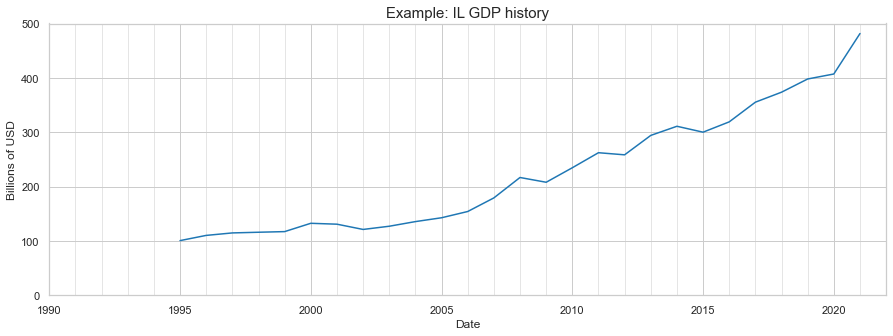

In [34]:
### WORLD BANK: WDI: GDP: EXAMPLES

### Data loading:
ser_full_gdp = pd.read_hdf(path_or_buf = str_path_wb_gdp_dataset, key = str_wb_gdp_dataset)
### Country data filtering:
str_country = 'IL'
ser_example = ser_full_gdp.loc[All, str_country] / 1000000000
display(ser_example[1::5])
### Resampling example to correct x-axis visualization:
ser_example_ys = ser_example.resample('YS').last()
### Plot initializaing:
df_to_plot = ser_example_ys.reset_index()
plt.figure(figsize = (15, 5))
sns.set_context('notebook')
ax_example = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Value')
ax_example.set(ylim = (0, 500), xlim = (date_start, date_end), ylabel = 'Billions of USD')
ax_example.set_title('Example: ' + str_country + ' GDP history', fontsize = 15)
### Major ticker options:    
ax_example.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_example.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_example.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_example.grid(visible = True, which = 'minor', linewidth = 0.5)      
### Plot drawing:
plt.show()

In [28]:
### TEMP

ser_gdp_part.unstack('Market').resample('YS').last().stack('Market')

Date        Market
1989-01-01  DM         96
            EM         84
            FM         78
            ISON       85
1990-01-01  DM         96
                     ... 
2020-01-01  ISON       99
2021-01-01  DM        100
            EM         88
            FM        100
            ISON       96
Length: 132, dtype: int32

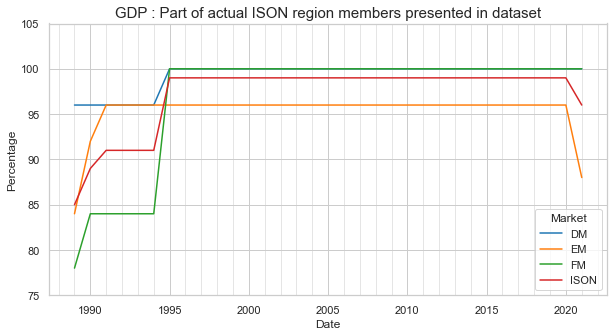

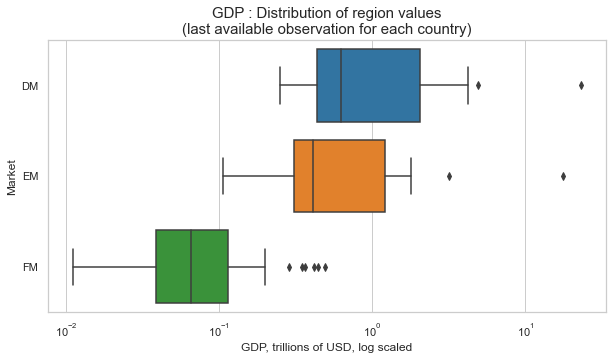

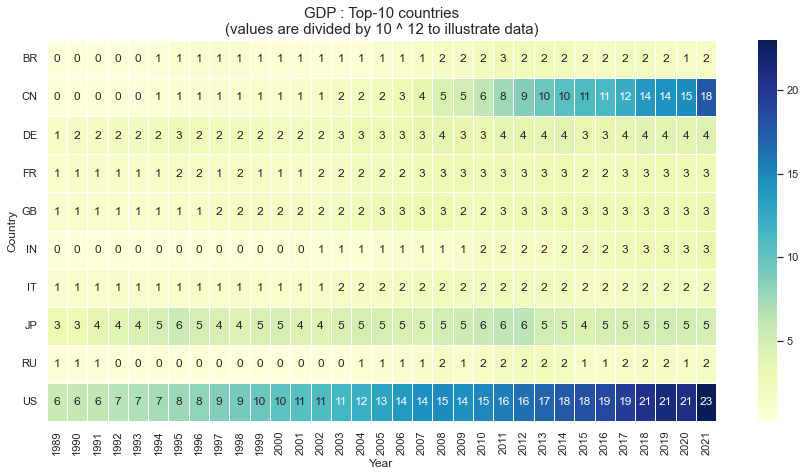

In [36]:
### WORLD BANK: WDI: GDP: DATA PRESENCE STATISTICS

### Data loading and ISONing
ser_full_gdp = pd.read_hdf(path_or_buf = str_path_wb_gdp_dataset, key = str_wb_gdp_dataset)
ser_ison_gdp = ser_full_gdp.to_frame().join(ser_ison_status).set_index('Market', append = True).squeeze().dropna()
### Calculating of coverage:
ser_gdp_count = ser_ison_gdp.groupby(['Date', 'Market']).count()
ser_gdp_count = pd.concat([ser_gdp_count, pd.concat({'ISON': ser_gdp_count.groupby('Date').sum()}, names = ['Market']).swaplevel()], axis = 0).sort_index()
ser_gdp_part = ((ser_gdp_count / ser_market_len).round(2) * 100).astype(int)
### Coverage plotting:
ser_gdp_part_ys = ser_gdp_part.unstack('Market').resample('YS').last().stack('Market')
ser_gdp_part_ys.name = 'Percentage'
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
df_to_plot = ser_gdp_part_ys.reset_index()
ax_coverage = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percentage', hue = 'Market')
ax_coverage.set_title('GDP' + ' : Part of actual ISON region members presented in dataset', fontsize = 15)
ax_coverage.set(ylim = (75, 105), ylabel = 'Percentage')
### Major ticker options:    
ax_coverage.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_coverage.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_coverage.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_coverage.grid(visible = True, which = 'minor', linewidth = 0.5)    
plt.show()   
### Distribution plotting:
df_to_plot = (ser_ison_gdp / 1000000000000).groupby(['Country', 'Market']).last().dropna().reset_index()
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_box = sns.boxplot(data = df_to_plot, x = 'Value', y = 'Market', order = list_regions)
ax_box.set_title('GDP' + ' : Distribution of region values' + '\n' + '(last available observation for each country)', fontsize = 15)
ax_box.set_xlabel('GDP, trillions of USD, log scaled')
ax_box.set_xscale('log')
plt.show()
### Largest / smallest values preparation:
int_n_countries = 10
int_n_years = 10
ser_ison_mean = ser_ison_gdp.loc[ser_ison_gdp.index.levels[0][-int_n_years : ]].groupby('Country').mean().dropna().sort_values(ascending = False)
### Leaders data preparation:
df_ison_largest = ser_ison_gdp.loc[All, ser_ison_mean[: int_n_countries].index, All].droplevel('Market').reset_index()
df_ison_largest['Year'] = df_ison_largest['Date'].dt.year
df_ison_largest = df_ison_largest.drop('Date', axis = 1).set_index(['Country', 'Year']).unstack('Year').sort_index()
### Data aggregation:
df_to_plot = df_ison_largest
df_to_plot.columns = df_to_plot.columns.droplevel(0)
int_digits = int(np.log10(df_to_plot.max().max()))
df_to_plot = (df_to_plot / (10 ** (int_digits - 1)))    
### Heatmap plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False,
                         annot = True, fmt = '0.0f')
ax_heatmap.set_title('GDP' + ' : Top-' + str(int_n_countries) + ' countries' + '\n' + 
                     '(values are divided by 10 ^ ' + str(int_digits - 1) + ' to illustrate data)' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()    

In [37]:
### CEPII DISTANCES

In [38]:
### CEPII DISTANCES: DATA EXPORT AND REPACKING

### Constants:
str_path_cepii_source = 'Data_Files/Source_Files/CEPII Distance Data/dist_cepii.xls'
### Source data export:
df_distance_source = pd.read_excel(str_path_cepii_source, index_col = [0, 1])
### Long to Short Country ID's converting:
df_distance_data = df_distance_source.join(df_country_codes.set_index('ISO LONG').squeeze(), on = 'iso_o')
df_distance_data.rename({'ISO SHORT': 'From_ID'}, axis = 1, inplace = True)
df_distance_data = df_distance_data.join(df_country_codes.set_index('ISO LONG').squeeze(), on = 'iso_d')
df_distance_data.rename({'ISO SHORT': 'To_ID'}, axis = 1, inplace = True)
### ISON countries filtering:
list_ison_countries = ser_ison_membership.index.get_level_values(1).unique()
df_distance_data = df_distance_data.dropna().set_index(['From_ID', 'To_ID']).loc[(list_ison_countries, list_ison_countries), ['dist', 'distcap', 'distw', 'distwces']]
df_distance_data = df_distance_data.astype(int)
### Result saving:
df_distance_data.to_hdf(path_or_buf = str_path_cepii_dataset, key = str_distance_dataset, mode = 'w')

Example :
 From_ID  To_ID
AU       AU        1121
         US       14802
US       AU       14802
         US        1853
Name: distw, dtype: int32
Unique "From" countries number :
 83
ISON countries not in "From" :
 {'RO', 'RS'}
Unique "To" countries number :
 83
ISON countries not in "To" :
 {'RO', 'RS'}
NaN values number :
 0
Sample bilateral pairs number vs Theoretical bilateral pairs number :
 3403 vs 3403
Asymmetric bilateral distances :
 []
Maximal bilateral distance :
 From_ID  To_ID
EC       SG       19650
SG       EC       19650
Name: distw, dtype: int32
Minimal bilateral distance :
 From_ID  To_ID
IL       JO       114
JO       IL       114
Name: distw, dtype: int32
Maximal inner distance :
 From_ID  To_ID
US       US       1853
Name: distw, dtype: int32
Minimal inner distance :
 From_ID  To_ID
MT       MT       8
Name: distw, dtype: int32


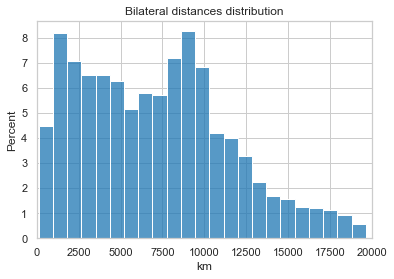

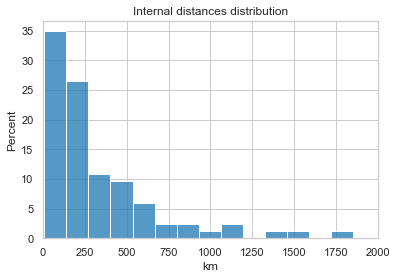

In [39]:
### CEPII DISTANCES: STATS

### Countries stats:
set_ison_countries = set(ser_ison_membership.index.get_level_values(1))
ser_dist = pd.read_hdf(path_or_buf = str_path_cepii_dataset, key = str_distance_dataset)['distw']
ser_dist_outer = ser_dist[ser_dist.index.get_level_values(0) != ser_dist.index.get_level_values(1)]
ser_dist_inner = ser_dist[ser_dist.index.get_level_values(0) == ser_dist.index.get_level_values(1)]
print('Example :\n', ser_dist.loc[['AU', 'US'], ['AU', 'US']])
set_from = set(ser_dist_outer.index.get_level_values(0))
set_to = set(ser_dist_outer.index.get_level_values(1))
print('Unique \"From\" countries number :\n', len(set_from))
print('ISON countries not in \"From\" :\n', set_ison_countries - set_from)
print('Unique \"To\" countries number :\n', len(set_to))
print('ISON countries not in \"To\" :\n', set_ison_countries - set_to)
print('NaN values number :\n', len(ser_dist[ser_dist.isna()]))
### Pairs stats:
print('Sample bilateral pairs number vs Theoretical bilateral pairs number :\n', len(ser_dist_outer) // 2, 'vs', len(set_from) * (len(set_from) - 1) // 2)
print('Asymmetric bilateral distances :\n', 
      [(iter_from, iter_to) for iter_from in set_from for iter_to in set_to if (ser_dist[iter_from, iter_to] != ser_dist[iter_to, iter_from])])
### Distances stats:
print('Maximal bilateral distance :\n', ser_dist_outer[ser_dist_outer == max(ser_dist_outer)])
print('Minimal bilateral distance :\n', ser_dist_outer[ser_dist_outer == min(ser_dist_outer)])
print('Maximal inner distance :\n', ser_dist_inner[ser_dist_inner == max(ser_dist_inner)])
print('Minimal inner distance :\n', ser_dist_inner[ser_dist_inner == min(ser_dist_inner)])
sns.set_style('whitegrid')
sns.set_context('notebook')
ax_outer = sns.histplot(ser_dist_outer.loc[sorted(list(itertools.combinations(set_from, 2)))].values, kde = False, stat = 'percent')
ax_outer.set_title('Bilateral distances distribution')
ax_outer.set(xlim = (0, 20000), xlabel = 'km')
plt.show()
ax_inner = sns.histplot(ser_dist_inner.values, kde = False, stat = 'percent')
ax_inner.set_title('Internal distances distribution')
ax_inner.set(xlim = (0, 2000), xlabel = 'km')
plt.show()

In [40]:
### IMF DOTS: BILATERAL EXPORTS & IMPORTS (MILLIONS OF USD)

In [41]:
### IMF DOTS: GENERAL DATA PREPARATION

### Constants:
All = slice(None)
dict_request_headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'}
str_imf_base_url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
str_imf_dataflow_add = 'DataFlow'
str_imf_datastructure_add = 'DataStructure/'
str_imf_codelist_add = 'CodeList/'
str_imf_dataset_add = 'CompactData/'
int_seconds_to_sleep = 5
int_imf_country_limit = 30

In [44]:
### IMF DOTS: REQUESTS SESSION INITIALIZING

request_session = requests.Session()
### For avoiding data request errors from IMF Data Service:
request_session.headers.update(dict_request_headers)

In [47]:
### IMF DOTS: DATAFLOW SEARCHING

obj_imf_dataflow_list = request_session.get(str_imf_base_url + str_imf_dataflow_add).json()
df_imf_dataflow = pd.DataFrame(obj_imf_dataflow_list['Structure']['Dataflows']['Dataflow'])
df_imf_dataflow = df_imf_dataflow.assign(Description = df_imf_dataflow['Name'].apply(pd.Series)['#text'].values)[['@id', 'Description']]
ser_imf_dataflow = df_imf_dataflow.set_index('@id', drop = True).squeeze()
### Searching DataFlow code for further requests:
str_imf_dots_id = ser_imf_dataflow[ser_imf_dataflow.str.endswith('(DOTS)')].index[0].replace('DS-', '')
print(str_imf_dots_id)

DOT


In [48]:
### IMF DOTS: DATASTRUCTURE SEARCHING

obj_imf_dots_structure = request_session.get(str_imf_base_url + str_imf_datastructure_add + str_imf_dots_id).json()
df_imf_dots_params = pd.DataFrame(obj_imf_dots_structure['Structure']['KeyFamilies']['KeyFamily']['Components']['Dimension'])\
                                [['@conceptRef', '@codelist', '@isFrequencyDimension']]
### Receiving DataFlow parameters and code lists for each of them:
print(df_imf_dots_params)

        @conceptRef                @codelist @isFrequencyDimension
0              FREQ                  CL_FREQ                  true
1          REF_AREA              CL_AREA_DOT                   NaN
2         INDICATOR         CL_INDICATOR_DOT                   NaN
3  COUNTERPART_AREA  CL_COUNTERPART_AREA_DOT                   NaN


In [49]:
### IMF DOTS: CODES DESCRIPTION SEARCHING

for int_counter, str_param_code in enumerate(df_imf_dots_params['@codelist']):
    if (int_counter == 2):
        time.sleep(int_seconds_to_sleep)    
        obj_imf_dots_param = request_session.get(str_imf_base_url + str_imf_codelist_add + str_param_code).json()
        df_imf_dots_param =  pd.DataFrame(obj_imf_dots_param['Structure']['CodeLists']['CodeList']['Code'])
        ### Receiving values for each code list:
        df_imf_dots_param = df_imf_dots_param.assign(Text = df_imf_dots_param['Description'].apply(pd.Series)['#text'].values)[['@value', 'Text']]
        print(int_counter, ':', df_imf_dots_params.iloc[int_counter, All]['@conceptRef'], ':', str_param_code, ':\n', df_imf_dots_param.head(5))
    
str_dots_freq = 'M' # 'A' # 'B' # 
#str_dots_indicator = 
list_dots_indicator = ['TXG_FOB_USD', 'TMG_CIF_USD', 'TMG_FOB_USD', 'TBG_USD']
list_ison_countries = sorted(list(map(str, ser_ison_membership.index.get_level_values(1).unique())))

2 : INDICATOR : CL_INDICATOR_DOT :
         @value                                               Text
0  TXG_FOB_USD  Goods, Value of Exports, Free on board (FOB), ...
1  TMG_CIF_USD  Goods, Value of Imports, Cost, Insurance, Frei...
2  TMG_FOB_USD  Goods, Value of Imports, Free on board (FOB), ...
3      TBG_USD          Goods, Value of Trade Balance, US Dollars


In [ ]:
### IMF DOTS: ALL INDICATORS EXTRACTION

dict_dots_bilateral = {} # Global container
str_dots_const_url = str_imf_base_url + str_imf_dataset_add + str_imf_dots_id + '/' # Beginning of request URL
### Looping for DOTS Indicators:
for str_dots_indicator in list_dots_indicator[: 2]:
    ### Session initializing:
    request_session = requests.Session()
    request_session.headers.update(dict_request_headers)    
    ### List of bilateral dataframes for future concatenation
    list_dots_bilateral = [] 
    ### Looping for reporter country groups:
    for int_ison_reporter_part in range(0, - (len(list_ison_countries) // ( - int_imf_country_limit))):
        str_dots_reporters = '+'.join(list_ison_countries[int_ison_reporter_part * int_imf_country_limit : (int_ison_reporter_part + 1) * int_imf_country_limit])
        ### Looping for partner country groups:
        for int_ison_partner_part in range(0, - (len(list_ison_countries) // ( - int_imf_country_limit))):
            str_dots_partners = '+'.join(list_ison_countries[int_ison_partner_part * int_imf_country_limit : (int_ison_partner_part + 1) * int_imf_country_limit]) 
            ### Generating complete request URL:
            str_dots_full_url = str_dots_const_url + \
                                '.'.join([str_dots_freq, str_dots_reporters, str_dots_indicator, str_dots_partners])
            ### Receiving DOTS dataset from IMF API:
            print(int_ison_reporter_part * int_imf_country_limit, '-', (int_ison_reporter_part + 1) * int_imf_country_limit, ' / ',
                  int_ison_partner_part * int_imf_country_limit, '-', (int_ison_partner_part + 1) * int_imf_country_limit, ' / ', str_dots_indicator)
            obj_dots_set = request_session.get(str_dots_full_url)
            ### Data reading as JSON:
            dict_dots_set = json.loads(obj_dots_set.text)
            ### Converting each bilateral dataset to dataframe and it's mungling:
            for dict_dots_pair in dict_dots_set['CompactData']['DataSet']['Series']:
                if isinstance(dict_dots_pair['Obs'], list):
                    df_dots_bilateral = pd.DataFrame(dict_dots_pair['Obs'])
                else:
                    df_dots_bilateral = pd.DataFrame([dict_dots_pair['Obs']])
                ### Markers checking:
                if '@OBS_STATUS' not in df_dots_bilateral.columns:
                    df_dots_bilateral['@OBS_STATUS'] = np.NaN
                ### Data extracting and mungling:
                df_dots_bilateral = df_dots_bilateral[['@TIME_PERIOD', '@OBS_VALUE', '@OBS_STATUS']]
                df_dots_bilateral.columns = ['Date', 'Value', 'Status']
                df_dots_bilateral = df_dots_bilateral.assign(Reporter_ID = dict_dots_pair['@REF_AREA'])
                df_dots_bilateral = df_dots_bilateral.assign(Partner_ID = dict_dots_pair['@COUNTERPART_AREA'])
                list_dots_bilateral.append(df_dots_bilateral)
#            break
#        break
    ### Flow level data aggregation:
    df_dots_indicator = pd.concat(list_dots_bilateral, axis = 0, ignore_index = True)
    df_dots_indicator['Date'] = pd.to_datetime(df_dots_indicator['Date']) + pd.offsets.BMonthEnd()
    df_dots_indicator = df_dots_indicator.set_index(['Date', 'Reporter_ID', 'Partner_ID'])                
    dict_dots_bilateral[str_dots_indicator] = df_dots_indicator
    del df_dots_indicator
    gc.collect()
### Full data aggregation:
df_dots_result = pd.concat(dict_dots_bilateral, axis = 1)
del dict_dots_bilateral
gc.collect()
### Structure optimization:
df_dots_flows = df_dots_result.iloc[All, [0, 2]]
del df_dots_result
gc.collect()
df_dots_flows.columns = ['Export', 'Import']
df_dots_flows = df_dots_flows.reset_index().melt(id_vars = ['Date', 'Reporter_ID', 'Partner_ID'], var_name = 'Flow', value_name = 'Value')
df_dots_flows.rename({'Reporter_ID': 'Reporter', 'Partner_ID': 'Partner'}, axis = 1, inplace = True)
df_dots_flows = df_dots_flows.astype({'Reporter': 'category', 'Partner': 'category', 'Flow': 'category', 'Value': float})
### Dataset saving:
df_dots_flows.to_hdf(path_or_buf = str_path_imf_dots_dataset, key = str_full_imf_dots_dataset, mode = 'w', format = 'table')
del df_dots_flows
gc.collect()

In [48]:
### IMF DOTS: DATA LOADING

df_dots_flows = pd.read_hdf(path_or_buf = str_path_imf_dots_dataset, key = str_full_imf_dots_dataset)
df_dots_export = df_dots_flows[(df_dots_flows['Flow'] == 'Export') & (df_dots_flows['Date'] > date_start) & (df_dots_flows['Date'] <= date_end)].dropna()

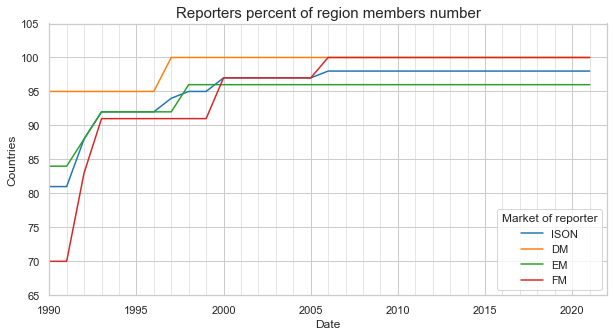

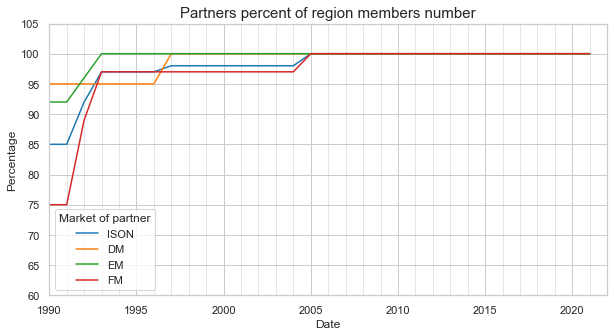

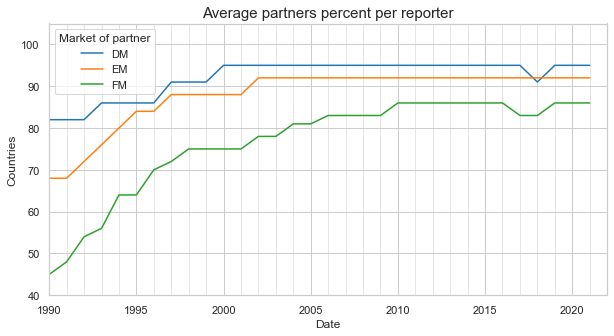

In [65]:
### IMF DOTS: STATS: EXPORT COVERAGE: PARTICIPANTS NUMBER

gc.collect()
### Adding regions of reporters and partners:
ser_ison_status.index.names = ['Country']
df_coverage_full = df_dots_export.merge(ser_ison_status, left_on = 'Reporter', right_on = 'Country').merge(ser_ison_status, left_on = 'Partner', right_on = 'Country')
df_coverage_full.rename({'Market_x': 'Reporter_Market', 'Market_y': 'Partner_Market'}, axis = 1, inplace = True)
### Reporters number calculation start:
dict_reporters = {}
### Total reporters number:
ser_iter_reporters = df_coverage_full.groupby('Date')['Reporter'].apply(lambda ser_date: len(ser_date.unique()))
ser_iter_reporters.name = 'Percent'
dict_reporters['ISON'] = (ser_iter_reporters.resample('BY').last().dropna() / dict_ison_len['ISON'] * 100).astype(int)
### Region's reporters number:
for iter_region in list_regions:
    ser_iter_reporters = df_coverage_full[df_coverage_full['Reporter_Market'] == iter_region]\
                            .groupby('Date')['Reporter'].apply(lambda ser_date: len(ser_date.unique()))
    ser_iter_reporters.name = 'Percent'
    dict_reporters[iter_region] = (ser_iter_reporters.resample('BY').last().dropna() / dict_ison_len[iter_region] * 100).astype(int)
### Data consolidating:    
df_reporters = pd.concat(dict_reporters, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_reporters.columns = ['Date', 'Market of reporter', 'Percent']
df_to_plot = df_reporters[df_reporters['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_reporters = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of reporter')
ax_reporters.set_title('Reporters percent of region members number', fontsize = 15)
ax_reporters.set(xlim = (date_start, date_end), ylim = (65, 105), ylabel = 'Countries')
### Major ticker options:    
ax_reporters.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_reporters.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_reporters.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_reporters.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()
### Partners number calculation start:
dict_partners = {}
### Total partners number:
ser_iter_partners = df_coverage_full.groupby('Date')['Partner'].apply(lambda ser_date: len(ser_date.unique()))
ser_iter_partners.name = 'Percent'
### Region's partners number:
dict_partners['ISON']  = (ser_iter_partners.resample('BY').last().dropna() / dict_ison_len['ISON'] * 100).astype(int)
for iter_region in list_regions:
    ser_iter_partners = df_coverage_full[df_coverage_full['Partner_Market'] == iter_region]\
                            .groupby('Date')['Partner'].apply(lambda ser_date: len(ser_date.unique()))
    ser_iter_partners.name = 'Percent'
    dict_partners[iter_region]  = (ser_iter_partners.resample('BY').last().dropna() / dict_ison_len[iter_region] * 100).astype(int)
### Data consolidating:        
df_partners = pd.concat(dict_partners, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_partners.columns = ['Date', 'Market of partner', 'Percent']
df_to_plot = df_partners[df_partners['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_partners = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of partner')
ax_partners.set_title('Partners percent of region members number', fontsize = 15)
ax_partners.set(xlim = (date_start, date_end), ylim = (60, 105), ylabel = 'Percentage')
### Major ticker options:    
ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()
### Average partners number calculation start:
dict_ave_partners = {}
### Region's partners average number:
for iter_region in list_regions:
    ser_iter_partners = df_coverage_full[df_coverage_full['Partner_Market'] == iter_region]\
                                .groupby(['Date', 'Reporter'])['Partner'].apply(lambda ser_date: len(ser_date.unique())).groupby('Date').mean().astype(int)
    ser_iter_partners.name = 'Percent'
    dict_ave_partners[iter_region] = (ser_iter_partners.resample('BY').last().dropna() / dict_ison_len[iter_region] * 100).astype(int)
### Data consolidating:         
df_partners = pd.concat(dict_ave_partners, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_partners.columns = ['Date', 'Market of partner', 'Percent']
df_to_plot = df_partners[df_partners['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_partners = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of partner')
ax_partners.set_title('Average partners percent per reporter', fontsize = 15)
ax_partners.set(xlim = (date_start, date_end), ylim = (40, 105), ylabel = 'Countries')
### Major ticker options:    
ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

IMF Export: Total ISON Reporters number: 84
IMF Export: Absent countries: {'TW'}


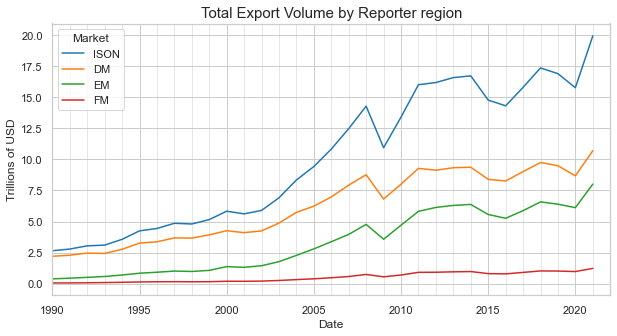

In [71]:
### IMF DOTS: STATS: EXPORT VOLUME

gc.collect()
print('IMF Export: Total ISON Reporters number:', str(len(df_dots_export['Reporter'].unique())))
print('IMF Export: Absent countries:', (set(ser_ison_status.index) - set(df_dots_export['Reporter'].unique())))
### Total export volume calculation start:
ser_dots_export_ann = df_dots_export.groupby(['Reporter', 'Partner']).apply(lambda df_group: df_group.set_index('Date').resample('BY').sum())\
                                    .squeeze().reorder_levels([2, 0, 1])
ser_dots_export_ann = ser_dots_export_ann[ser_dots_export_ann > 0.0]
dict_total_volume = {}
### ISON total volume:
ser_total_volume = ser_dots_export_ann.dropna().groupby('Date').sum() / 1000000
dict_total_volume['ISON'] = ser_total_volume
ser_ison_status.index.names = ['Reporter']
df_dots_export_isoned = ser_dots_export_ann.dropna().to_frame().join(ser_ison_status, on = 'Reporter')
### Region's total volume:
for iter_region in list_regions:
    ser_iter_volume = df_dots_export_isoned[df_dots_export_isoned['Market'] == iter_region].groupby('Date')['Value'].sum() / 1000000
    dict_total_volume[iter_region] = ser_iter_volume
### Data consolidating:    
df_volume = pd.concat(dict_total_volume).unstack(0).resample('YS').last().stack(0).reset_index()
df_volume.columns = ['Date', 'Market', 'Volume']
df_to_plot = df_volume[df_volume['Date'] < date_end]
### Total export volume plotting
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_total = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Volume', hue = 'Market')
ax_total.set_title('Total Export Volume by Reporter region', fontsize = 15)
ax_total.set(xlim = (date_start, date_end), ylabel = 'Trillions of USD')
### Major ticker options:    
ax_total.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_total.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_total.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_total.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

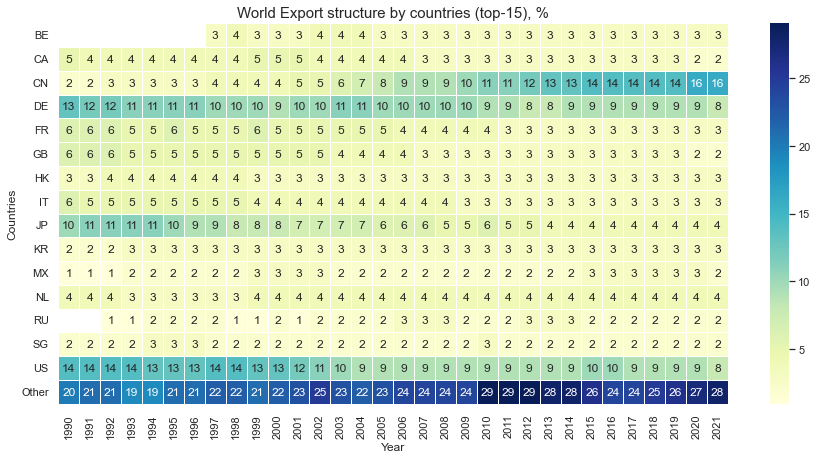

In [72]:
### IMF DOTS: STATS: EXPORT LEADERS

gc.collect()
### Stats parameter - leaders to plot:
int_top = 15
### Stats parameter - years to define leaders:
int_term = 10
### Country trade proprotion for each date:
ser_country_value = ser_dots_export_ann.groupby(['Date', 'Reporter']).sum().dropna() / 1000000
df_country_part = (ser_country_value / ser_total_volume).round(2).reset_index()
df_country_part['Year'] = df_country_part['Date'].dt.year
ser_country_part = df_country_part.set_index(['Year', 'Reporter']).drop('Date', axis = 1).squeeze().sort_index()
### Limited by term country trade volume:
ser_country_sum = ser_country_value.groupby('Reporter').apply(lambda ser_group: ser_group.iloc[-int_term :].sum()).sort_values(ascending = False)
### Top countries list:
idx_ave_top = ser_country_sum[: int_top].index
### Other countries list:
idx_ave_other = ser_country_sum[int_top :].index
### Top countries proportions extracting:
ser_country_top = (ser_country_part.loc[All, idx_ave_top] * 100)
ser_country_top.index.set_levels(ser_country_top.index.levels[1].astype('O'), level = 'Reporter', inplace = True) 
### Other countries proportions extracting:
ser_country_other = (ser_country_part.loc[All, idx_ave_other].groupby('Year').sum() * 100)
ser_country_other = pd.concat({'Other': ser_country_other[ser_country_other > 0]}, names = ['Reporter']).swaplevel()
### Data consolidating:
df_to_plot = pd.concat([ser_country_top.unstack('Year').sort_index(), ser_country_other.unstack('Year')], axis = 0)
### Results plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '.0f')
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('World Export structure by countries (top-' + str(int_top) + '), %', fontsize = 15)
plt.yticks(rotation = 0)
plt.show()   

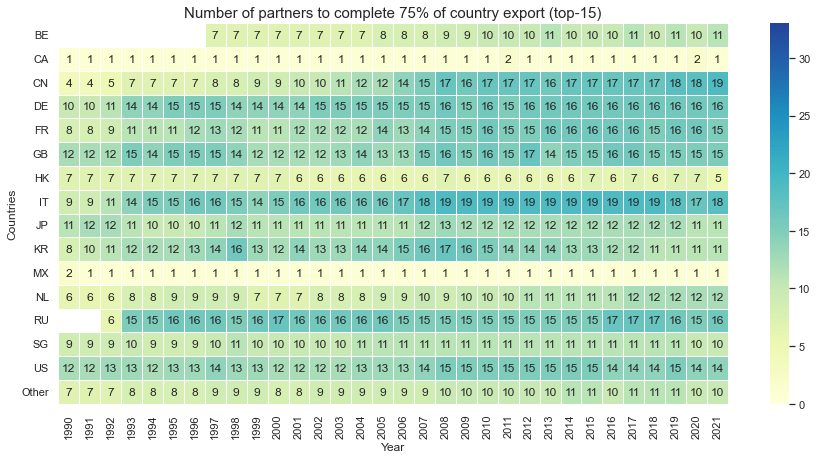

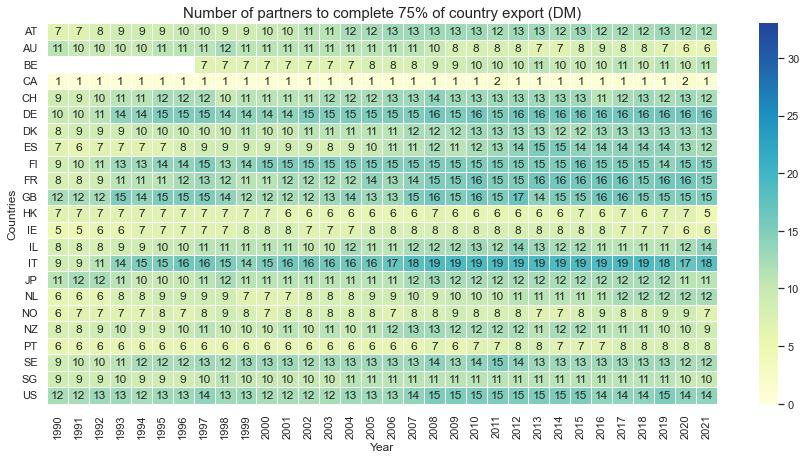

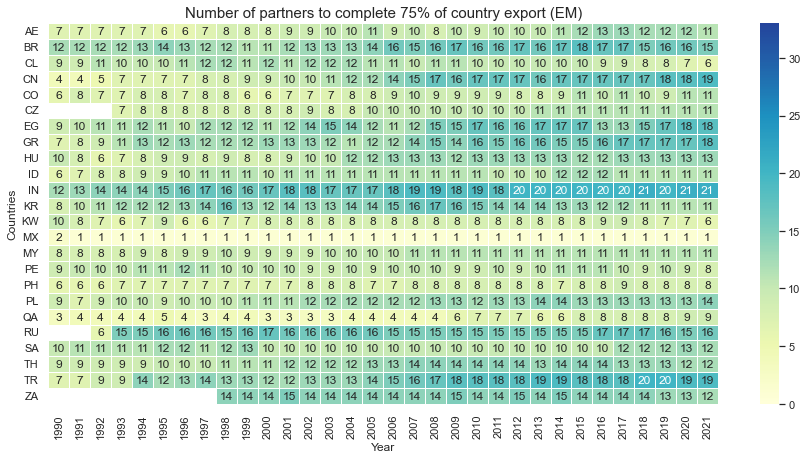

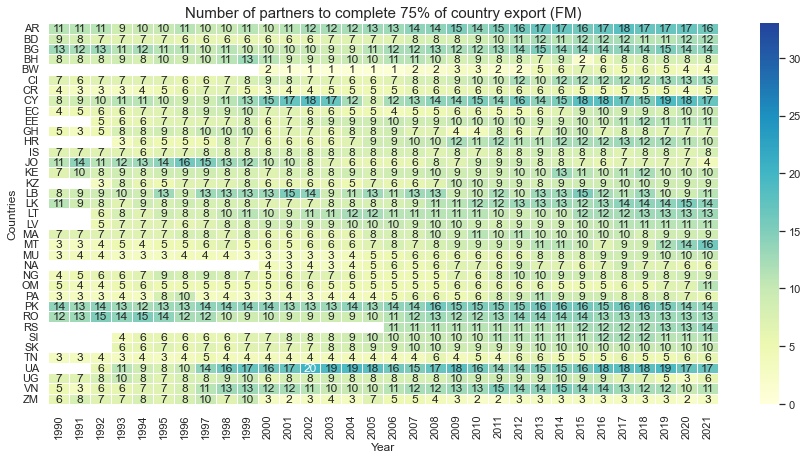

In [74]:
### IMF DOTS: STATS: NUMBER OF PARTNERS TO COMPLETE FIXED % OF EXPORT FOR COUNTRY

gc.collect()
### Defining top-% partners number calculation procedure:
def get_top_partners(ser_group, flo_perc):
    ser_by_partner = ser_group.groupby(['Date', 'Partner']).sum().dropna().sort_values(ascending = False)
    ser_cum_sum = ser_by_partner.cumsum() / ser_by_partner.sum()
    return len(ser_cum_sum[ser_cum_sum < flo_perc]) + 1
### Stats parameter - top bound:
flo_perc = 0.75
### Stats parameter - leaders to plot:
int_top = 15
### Top countries list:
idx_ave_top = ser_country_sum[: int_top].index
### Other countries list:
idx_ave_other = ser_country_sum[int_top :].index
### Partners number calculation for each Date / Reporter pair:
ser_partners = ser_dots_export_ann.groupby(['Date', 'Reporter']).apply(get_top_partners, flo_perc).dropna().astype(int)
ser_partners.name = 'Number'
df_partners = ser_partners.to_frame().join(ser_ison_status, on = 'Reporter').reset_index()
### Leaders data extraction for leaders plot:
df_top_part = df_partners[df_partners['Reporter'].isin(idx_ave_top)].copy()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part.drop(['Date', 'Market'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = df_partners[df_partners['Reporter'].isin(idx_ave_other)].groupby('Date')['Number'].mean().astype(int).reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part.drop('Date', axis = 1).squeeze().unstack('Year')
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plot plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         center = 20, vmin = 0, vmax = 33)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('Number of partners to complete ' + str(int(flo_perc * 100)) + '% of country export (top-' + str(int_top) + ')' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()
### Region's data plotting:
for iter_region in list_regions:
    ### Data extraction:    
    df_to_plot = df_partners.loc[df_partners['Market'] == iter_region].copy()
    df_to_plot['Year'] = df_to_plot['Date'].dt.year
    df_to_plot = df_to_plot.drop(['Date', 'Market'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             center = 20, vmin = 0, vmax = 33)
    ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
    ax_heatmap.set_title('Number of partners to complete ' + str(int(flo_perc * 100)) + '% of country export (' + iter_region + ')' , fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()  

In [8]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: DATA PREPARATION TO COMPARE FLOWS

gc.collect()
### Data loading:
df_dots_flows = pd.read_hdf(path_or_buf = str_path_imf_dots_dataset, key = str_full_imf_dots_dataset)
df_dots_flows = df_dots_flows[(df_dots_flows['Date'] > date_start) & (df_dots_flows['Date'] <= date_end)].dropna()
ser_export = df_dots_flows.loc[df_dots_flows['Flow'] == 'Export'].set_index(['Date', 'Reporter', 'Partner', 'Flow']).squeeze()
ser_export_ann = ser_export.groupby(['Reporter', 'Partner', 'Flow'])\
                           .apply(lambda ser_group: ser_group.droplevel(['Reporter', 'Partner', 'Flow']).resample('BY').sum()).reorder_levels([3, 0, 1, 2])
ser_import = df_dots_flows.loc[df_dots_flows['Flow'] == 'Import'].set_index(['Date', 'Reporter', 'Partner', 'Flow']).squeeze()
ser_import_ann = ser_import.groupby(['Reporter', 'Partner', 'Flow'])\
                           .apply(lambda ser_group: ser_group.droplevel(['Reporter', 'Partner', 'Flow']).resample('BY').sum()).reorder_levels([3, 0, 1, 2])
### Data concatenation:
ser_flows = pd.concat([ser_export, ser_import], axis = 0).to_frame().join(ser_ison_status, on = 'Reporter').set_index('Market', append = True).squeeze()
ser_flows_ann = pd.concat([ser_export_ann, ser_import_ann], axis = 0).to_frame().join(ser_ison_status, on = 'Reporter').set_index('Market', append = True).squeeze()

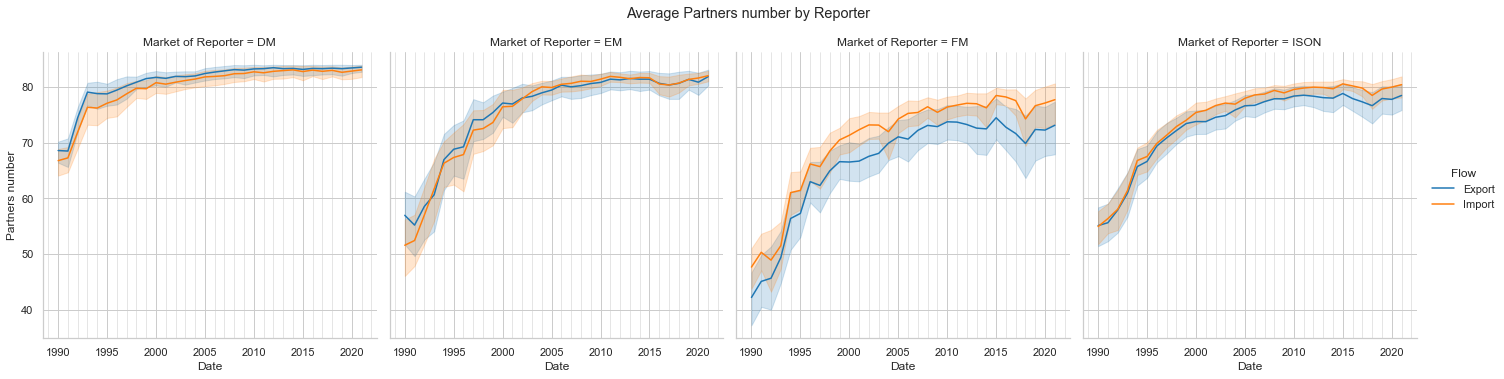

Number of observations for each flow: 
 Flow
Export    2301302
Import    2345386
dtype: int64


In [30]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: COVERAGE COMPARING

gc.collect()
### Average partners number for Date / Reporter:
dict_obs_mean = {}
ser_reporter_mean = ser_flows.groupby(['Date', 'Reporter', 'Flow', 'Market']).count()
dict_obs_mean['ISON'] = ser_reporter_mean.round(0).droplevel('Market').dropna().astype(int)
for iter_region in list_regions:
    dict_obs_mean[iter_region] = ser_reporter_mean.loc[All, All, All, iter_region].round(0).dropna().astype(int)
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_obs_mean, axis = 0, names = ['Market of Reporter']).unstack(['Market of Reporter', 'Reporter', 'Flow']).resample('YS').last()\
                                                                               .stack(['Market of Reporter', 'Reporter', 'Flow']).reset_index()
df_to_plot.rename({0: 'Value'}, axis = 1, inplace = True)
fig_mean_obs = sns.relplot(data = df_to_plot, x = 'Date', y = 'Value', col = 'Market of Reporter', hue = 'Flow', kind = 'line')
fig_mean_obs.fig.suptitle('Average Partners number by Reporter', y = 1.05)
fig_mean_obs.set_ylabels('Partners number')
### Axes customizing:
for iter_ax in fig_mean_obs.axes.ravel():
    ### Major ticker options:    
    iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5)                    
plt.show()
print('Number of observations for each flow:', '\n', ser_flows.unstack('Flow').count())

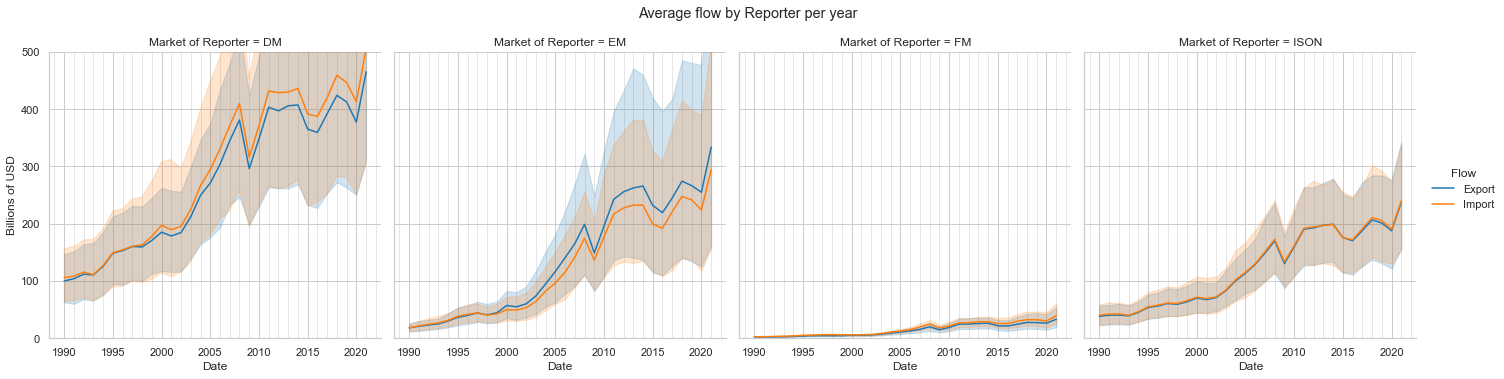

In [52]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: VOLUME COMPARING

gc.collect()
### Trade volume calculation:
dict_obs_sum = {}
ser_reporter_sum = ser_flows_ann.groupby(['Date', 'Reporter', 'Flow', 'Market']).sum() / 1000
dict_obs_sum['ISON'] = ser_reporter_sum.round(0)[ser_reporter_sum > 0].droplevel('Market').round(2).dropna()
for iter_region in list_regions:
    dict_obs_sum[iter_region] = ser_reporter_sum[ser_reporter_sum > 0].loc[All, All, All, iter_region].round(2).dropna()
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_obs_sum, axis = 0, names = ['Market of Reporter']).unstack(['Market of Reporter', 'Reporter', 'Flow']).resample('YS').last()\
                                                                              .stack(['Market of Reporter', 'Reporter', 'Flow']).reset_index()
df_to_plot.rename({0: 'Value'}, axis = 1, inplace = True)
fig_mean_obs = sns.relplot(data = df_to_plot, x = 'Date', y = 'Value', col = 'Market of Reporter', hue = 'Flow', kind = 'line')
fig_mean_obs.fig.suptitle('Average flow by Reporter per year', y = 1.05)
fig_mean_obs.set_ylabels('Billions of USD')
fig_mean_obs.set(ylim = (0, 500))
### Axes customizing:
for iter_ax in fig_mean_obs.axes.ravel():
    ### Major ticker options:    
    iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

In [41]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: DATA PREPARATION TO INCORPORATE FLOWS

gc.collect()
### Data loading:
df_dots_flows = pd.read_hdf(path_or_buf = str_path_imf_dots_dataset, key = str_full_imf_dots_dataset)
df_dots_flows = df_dots_flows[(df_dots_flows['Date'] > date_start) & (df_dots_flows['Date'] <= date_end)].dropna()
ser_export = df_dots_flows.loc[df_dots_flows['Flow'] == 'Export'].set_index(['Date', 'Reporter', 'Partner', 'Flow']).squeeze()
ser_import = df_dots_flows.loc[df_dots_flows['Flow'] == 'Import'].set_index(['Date', 'Reporter', 'Partner', 'Flow']).squeeze()
del df_dots_flows
gc.collect()
### Data aggregation:
ser_import_rev = ser_import[:]
ser_import_rev.index.set_names('Partner_Inv', level = 1, inplace = True)
ser_import_rev.index.set_names('Reporter', level = 2, inplace = True)
ser_import_rev.index.set_names('Partner', level = 1, inplace = True)
ser_import_rev = ser_import_rev.swaplevel('Reporter', 'Partner').sort_index()
df_export_aug = pd.concat([ser_export.droplevel('Flow'), ser_import_rev.droplevel('Flow')], axis = 1, 
                           names = 'Source Flow', keys = ['Export', 'Import'])
df_export_aug = df_export_aug.join(ser_ison_status, on = 'Reporter').set_index('Market', append = True)
df_export_aug = df_export_aug.drop('World', axis = 0, level = 'Reporter').drop('World', axis = 0, level = 'Partner')

In [43]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: ANNUAL DATA PREPARATION

gc.collect()
dict_export_aug_ann = {}
dict_export_aug_ann['Export'] = df_export_aug['Export'].groupby(['Reporter', 'Partner', 'Market'])\
                                                       .apply(lambda df_group: df_group.droplevel(['Reporter', 'Partner', 'Market']).resample('BY').sum())\
                                                       .replace({0.0: np.NaN}).dropna().reorder_levels([3, 0, 1, 2]).sort_index()
dict_export_aug_ann['Import'] = df_export_aug['Import'].groupby(['Reporter', 'Partner', 'Market'])\
                                                       .apply(lambda df_group: df_group.droplevel(['Reporter', 'Partner', 'Market']).resample('BY').sum())\
                                                       .replace({0.0: np.NaN}).dropna().reorder_levels([3, 0, 1, 2]).sort_index()
df_export_aug_ann = pd.concat(dict_export_aug_ann, axis = 1)
del dict_export_aug_ann

In [94]:
### TEMP

display(df_export_aug.loc[('2021', 'ZM', 'ZA', All), All].sum())
display(df_export_aug_ann.loc[('2021-12-31', 'ZM', 'ZA', All), All])

Export    285.268645
Import    259.143804
dtype: float64

,,,,Export,Import
Date,Reporter,Partner,Market,,
2021-12-31,ZM,ZA,FM,285.268645,259.143804


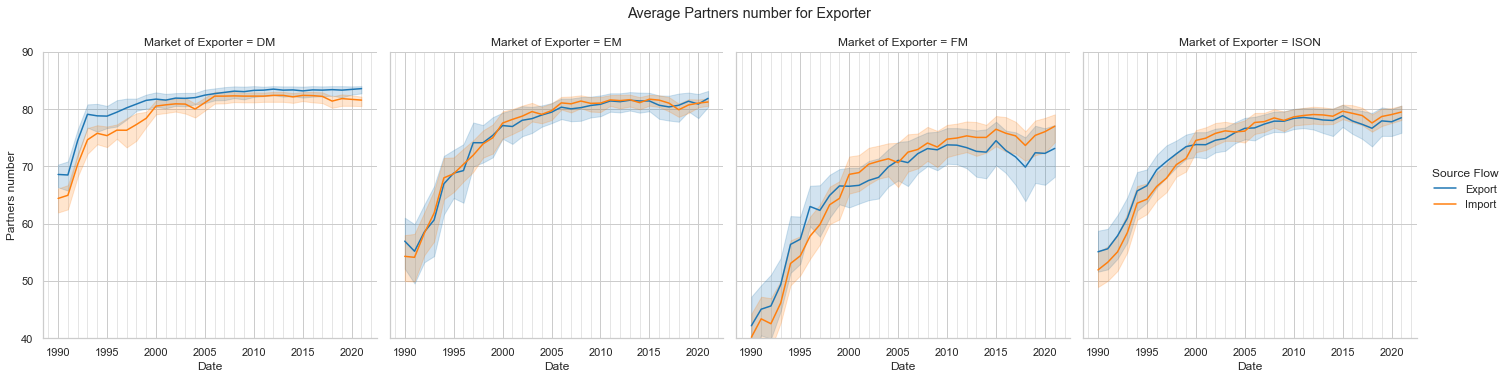

In [49]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: COVERAGE COMPARING

gc.collect()
### Coverage data container:
dict_unique_mean = {}
### Partners number calculation:
dict_unique_mean['Export'] = df_export_aug['Export'].groupby(['Date', 'Reporter', 'Market']).count()
dict_unique_mean['Import'] = df_export_aug['Import'].groupby(['Date', 'Reporter', 'Market']).count()
ser_unique_mean = pd.concat(dict_unique_mean, axis = 0, names = ['Source Flow']).round(0).astype(int)
ser_unique_mean = ser_unique_mean[ser_unique_mean > 0.0]
ser_unique_mean.name = 'Partners Number'
del dict_unique_mean
gc.collect()
dict_unique_source = {}
dict_unique_source['ISON'] = ser_unique_mean.droplevel('Market').dropna()
for iter_region in list_regions:
    dict_unique_source[iter_region] = ser_unique_mean.loc[All, All, All, iter_region].dropna()
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_unique_source, axis = 0, names = ['Market of Exporter']).unstack(['Market of Exporter', 'Reporter', 'Source Flow']).resample('YS').last()\
                                                                                    .stack(['Market of Exporter', 'Reporter', 'Source Flow']).reset_index()
df_to_plot.rename({0: 'Partners Number'}, axis = 1, inplace = True)
fig_mean_unique = sns.relplot(data = df_to_plot, x = 'Date', y = 'Partners Number', col = 'Market of Exporter', hue = 'Source Flow', kind = 'line')
fig_mean_unique.fig.suptitle('Average Partners number for Exporter', y = 1.05)
fig_mean_unique.set_ylabels('Partners number')
fig_mean_unique.set(ylim = (40, 90))
### Axes customizing:
for iter_ax in fig_mean_unique.axes.ravel():
    ### Major ticker options:    
    iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

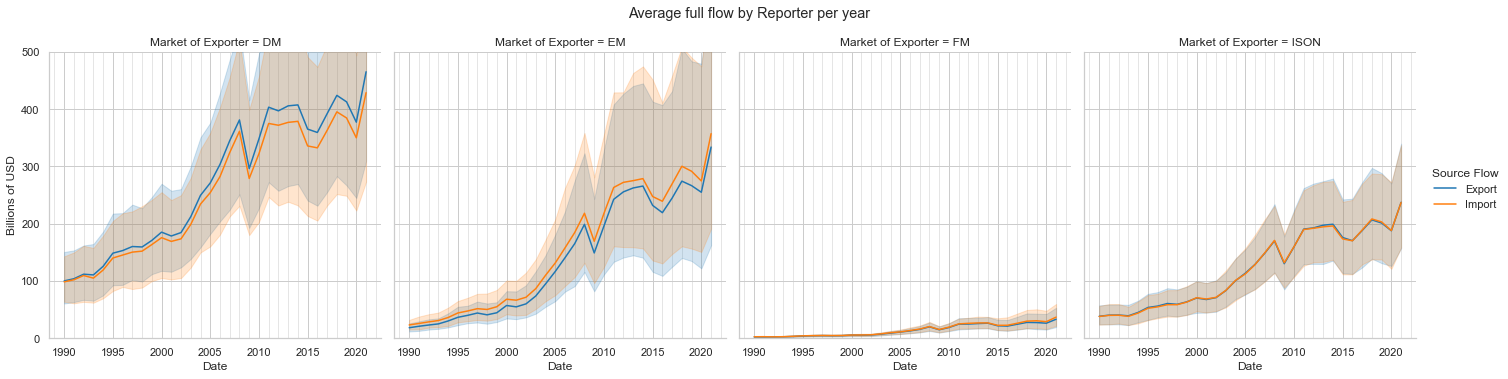

In [95]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: TOTAL OBSERVATIONS VOLUME

gc.collect()
### Valome calculation:
dict_unique_sum = {}
dict_unique_sum['Export'] = df_export_aug_ann['Export'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
dict_unique_sum['Import'] = df_export_aug_ann['Import'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
ser_unique_sum = pd.concat(dict_unique_sum, axis = 0, names = ['Source Flow']).round(2)
ser_unique_sum.name = 'Export volume'
del dict_unique_sum
gc.collect()
dict_unique_source = {}
dict_unique_source['ISON'] = ser_unique_sum[ser_unique_sum > 0.0].droplevel('Market').dropna()
for iter_region in list_regions:
    dict_unique_source[iter_region] = ser_unique_sum[ser_unique_sum > 0.0].loc[All, All, All, iter_region].dropna()
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_unique_source, axis = 0, names = ['Market of Exporter']).unstack(['Market of Exporter', 'Reporter', 'Source Flow']).resample('YS').last()\
                                                                              .stack(['Market of Exporter', 'Reporter', 'Source Flow']).reset_index()
df_to_plot.rename({0: 'Export volume'}, axis = 1, inplace = True)
fig_mean_unique = sns.relplot(data = df_to_plot, x = 'Date', y = 'Export volume', col = 'Market of Exporter', hue = 'Source Flow', kind = 'line')
fig_mean_unique.fig.suptitle('Average full flow by Reporter per year', y = 1.05)
fig_mean_unique.set_ylabels('Billions of USD')
fig_mean_unique.set(ylim = (0, 500))
### Axes customizing:
for iter_ax in fig_mean_unique.axes.ravel():
    ### Major ticker options:    
    iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5) 	
plt.show()

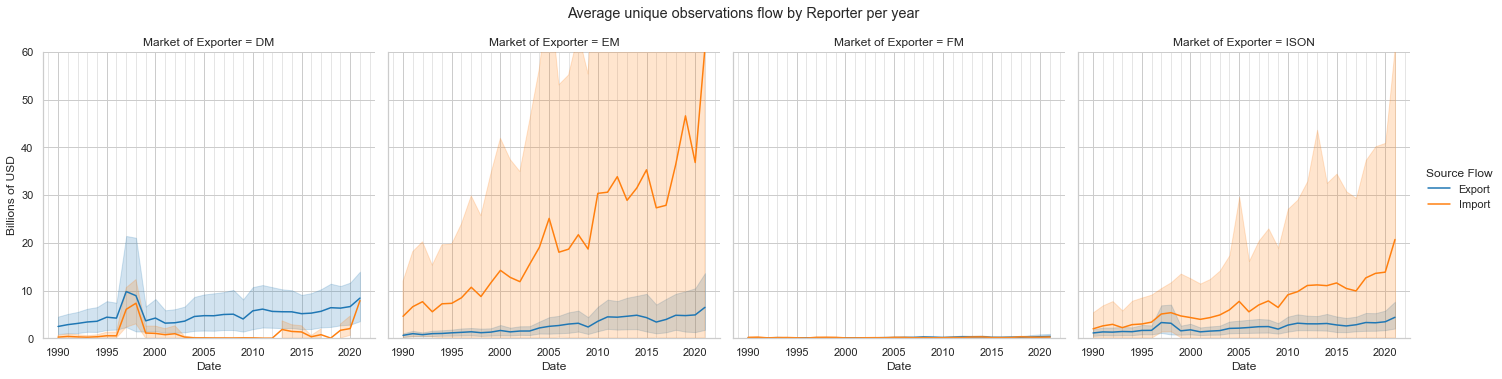

In [54]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: UNIQUE OBSERVATIONS VOLUME

gc.collect()

dict_unique_sum = {}
dict_unique_sum['Export'] = df_export_aug.loc[df_export_aug['Export'].notna() & df_export_aug['Import'].isna(), 'Export']\
                                         .groupby(['Date', 'Reporter', 'Market']).sum() / 1000
dict_unique_sum['Export'] = dict_unique_sum['Export'].unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])   
dict_unique_sum['Import'] = df_export_aug.loc[df_export_aug['Export'].isna() & df_export_aug['Import'].notna(), 'Import']\
                                         .groupby(['Date', 'Reporter', 'Market']).sum() / 1000
dict_unique_sum['Import'] = dict_unique_sum['Import'].unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market']) 
ser_unique_sum = pd.concat(dict_unique_sum, axis = 0, names = ['Source Flow']).round(2)
ser_unique_sum.name = 'Export volume'
del dict_unique_sum
gc.collect()
dict_unique_source = {}
dict_unique_source['ISON'] = ser_unique_sum[ser_unique_sum > 0.0].droplevel('Market').dropna()
for iter_region in list_regions:
    dict_unique_source[iter_region] = ser_unique_sum[ser_unique_sum > 0.0].loc[All, All, All, iter_region].dropna()
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_unique_source, axis = 0, names = ['Market of Exporter']).unstack(['Market of Exporter', 'Reporter', 'Source Flow']).resample('YS').last()\
                                                                              .stack(['Market of Exporter', 'Reporter', 'Source Flow']).reset_index()
df_to_plot.rename({0: 'Export volume'}, axis = 1, inplace = True)
fig_mean_unique = sns.relplot(data = df_to_plot, x = 'Date', y = 'Export volume', col = 'Market of Exporter', hue = 'Source Flow', kind = 'line')
fig_mean_unique.fig.suptitle('Average unique observations flow by Reporter per year', y = 1.05)
fig_mean_unique.set_ylabels('Billions of USD')
fig_mean_unique.set(ylim = (0, 60))
### Axes customizing:
for iter_ax in fig_mean_unique.axes.ravel():
    ### Major ticker options:    
    iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5) 	
plt.show()

In [101]:
### TEMP

gc.collect()
#print(ser_inter_sum[ser_inter_sum > 0.0].sum())
#print(ser_unique_sum[ser_unique_sum > 0.0].sum())
ser_inter_exp = df_export_aug.dropna()['Export'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
ser_inter_exp = ser_inter_exp.unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
ser_total_exp = df_export_aug_ann['Export'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
ser_unique_exp = df_export_aug.loc[df_export_aug['Export'].notna() & df_export_aug['Import'].isna(), 'Export']\
                                         .groupby(['Date', 'Reporter', 'Market']).sum() / 1000
ser_unique_exp = ser_unique_exp.unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
print('Total:', ser_total_exp.sum())
print('Intersected:', ser_inter_exp.sum())
print('Unique:', ser_unique_exp.sum())
print('Intersected:', ser_inter_exp.sum() + ser_unique_exp.sum())
print('Unique:', ser_unique_exp.sum() / ser_total_exp.sum() * 100)


Total: 322921.11998766
Intersected: 316996.6950980726
Unique: 5924.424889587394
Intersected: 322921.11998766
Unique: 1.8346353096427352


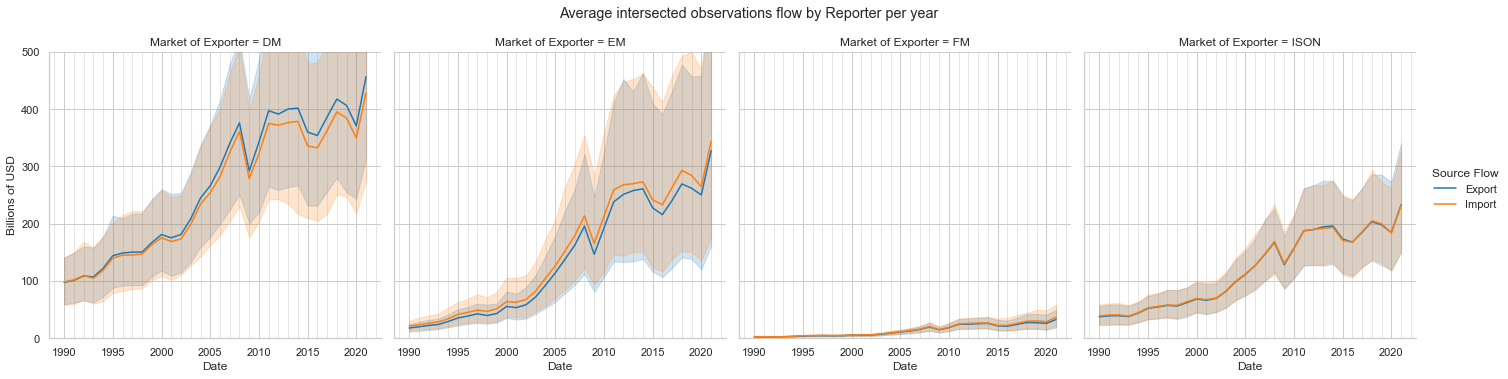

In [96]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: INTERSECTED OBSERVATIONS VOLUME

gc.collect()

dict_inter_sum = {}
dict_inter_sum['Export'] = df_export_aug.dropna()['Export'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
dict_inter_sum['Export'] = dict_inter_sum['Export'].unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
dict_inter_sum['Import'] = df_export_aug.dropna()['Import'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
dict_inter_sum['Import'] = dict_inter_sum['Import'].unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
ser_inter_sum = pd.concat(dict_inter_sum, axis = 0, names = ['Source Flow']).round(2)
ser_inter_sum.name = 'Export volume'
del dict_inter_sum
gc.collect()
dict_inter_source = {}
dict_inter_source['ISON'] = ser_inter_sum[ser_inter_sum > 0.0].droplevel('Market').dropna()
for iter_region in list_regions:
    dict_inter_source[iter_region] = ser_inter_sum[ser_inter_sum > 0.0].loc[All, All, All, iter_region].dropna()
### Average export volume plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_inter_source, axis = 0, names = ['Market of Exporter']).unstack(['Market of Exporter', 'Reporter', 'Source Flow']).resample('YS').last()\
                                                                                   .stack(['Market of Exporter', 'Reporter', 'Source Flow']).reset_index()
df_to_plot.rename({0: 'Export volume'}, axis = 1, inplace = True)
fig_mean_inter = sns.relplot(data = df_to_plot, x = 'Date', y = 'Export volume', col = 'Market of Exporter', hue = 'Source Flow', kind = 'line')
fig_mean_inter.fig.suptitle('Average intersected observations flow by Reporter per year', y = 1.05)
fig_mean_inter.set_ylabels('Billions of USD')
fig_mean_inter.set(ylim = (0, 500))
### Axes customizing:
for iter_ax in fig_mean_inter.axes.ravel():
    ### Major ticker options:    
    iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5)
plt.show()

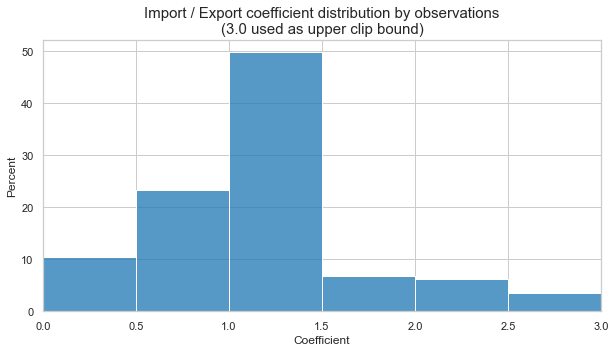

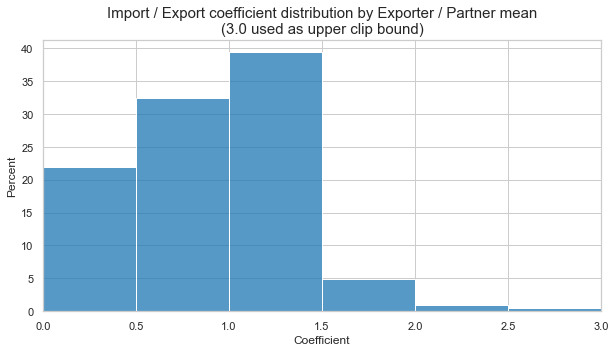

In [103]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: INTERSECTED OBSERVATIONS ANALYSIS

gc.collect()
### Observations with the largest absolute difference berween sources:
df_inter_aug = (df_export_aug.dropna() / 1000).round(2)
df_inter_aug['Difference'] = (df_inter_aug['Export'] - df_inter_aug['Import']).abs()
df_inter_aug.loc[df_inter_aug['Difference'].nlargest(20).index]
### Import / Export Coefficient distribution by observation:
flo_upper_bound = 3.0
df_inter_aug['Coefficient'] = (df_inter_aug['Import'] / df_inter_aug['Export']).round(2).clip(upper = flo_upper_bound)
df_to_plot = df_inter_aug.dropna().loc[df_inter_aug['Export'] > 0.001, 'Coefficient'].reset_index()
sns.set_style('whitegrid')
sns.set_context('notebook')
plt.figure(figsize = (10, 5))
ax_coeff_dist = sns.histplot(data = df_to_plot, x = 'Coefficient', stat = 'percent', bins = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, flo_upper_bound])
ax_coeff_dist.set_title('Import / Export coefficient distribution by observations\n' + '(' + str(flo_upper_bound) + ' used as upper clip bound)', fontsize = 15)
ax_coeff_dist.set(xlim = (0.0, flo_upper_bound))
plt.show()
### Import / Export Coefficient distribution by Exporter / Partner / Commodity averages:
flo_upper_bound = 3.0
df_to_plot = df_inter_aug.dropna().loc[df_inter_aug['Export'] > 0.001].groupby(['Reporter', 'Partner'])['Coefficient'].mean().reset_index()
sns.set_style('whitegrid')
sns.set_context('notebook')
plt.figure(figsize = (10, 5))
ax_coeff_dist = sns.histplot(data = df_to_plot, x = 'Coefficient', stat = 'percent', bins = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, flo_upper_bound])
ax_coeff_dist.set_title('Import / Export coefficient distribution by Exporter / Partner mean\n' + '(' \
                        + str(flo_upper_bound) + ' used as upper clip bound)', fontsize = 15)
ax_coeff_dist.set(xlim = (0.0, flo_upper_bound))
plt.show()

In [133]:
### IMF DOTS: CIF COEFFICIENTS CALCULATION

gc.collect()

### Bounds to filter bilateral Import to Export ratio before median calculation:
flo_lower_bound = 1.0
flo_upper_bound = 2.0

### Bilateral median calculation procedure:
def get_obs_median(df_comm):
    ### Export to Import ratio:
    ser_obs_coeff = df_comm['Import'] / df_comm['Export']
    ### Ratio filtering:
    ser_obs_coeff = ser_obs_coeff.loc[(ser_obs_coeff >= flo_lower_bound) & (ser_obs_coeff <= flo_upper_bound)]
    ### Filtered timeseries median as a result:
    return round(ser_obs_coeff.median(), 2)

### Calulation CIF coefficient for all commodities:
ser_cif_median = df_export_aug.groupby(['Reporter', 'Partner']).apply(get_obs_median)
ser_cif_median.fillna(ser_cif_median.median(), inplace = True)
ser_cif_median.name = 'CIF_Coefficient'

In [137]:
### IMF DOTS: IMPORT DATA INCORPORATION:

### Adding CIF coefficients to dataset:
df_export_cif = df_export_aug.merge(ser_cif_median, left_index = True, right_index = True)
df_export_cif = df_export_cif.reorder_levels(['Date', 'Reporter', 'Partner', 'Market'])
### Import correction:
df_export_cif['Import_Corrected'] = df_export_cif['Import'] / df_export_cif['CIF_Coefficient']
### Combining Export & Import data:
df_export_cif['Export_Augmented'] = df_export_cif['Export'].combine_first(df_export_cif['Import_Corrected'])
df_export_cif.drop('CIF_Coefficient', axis = 1, inplace = True)

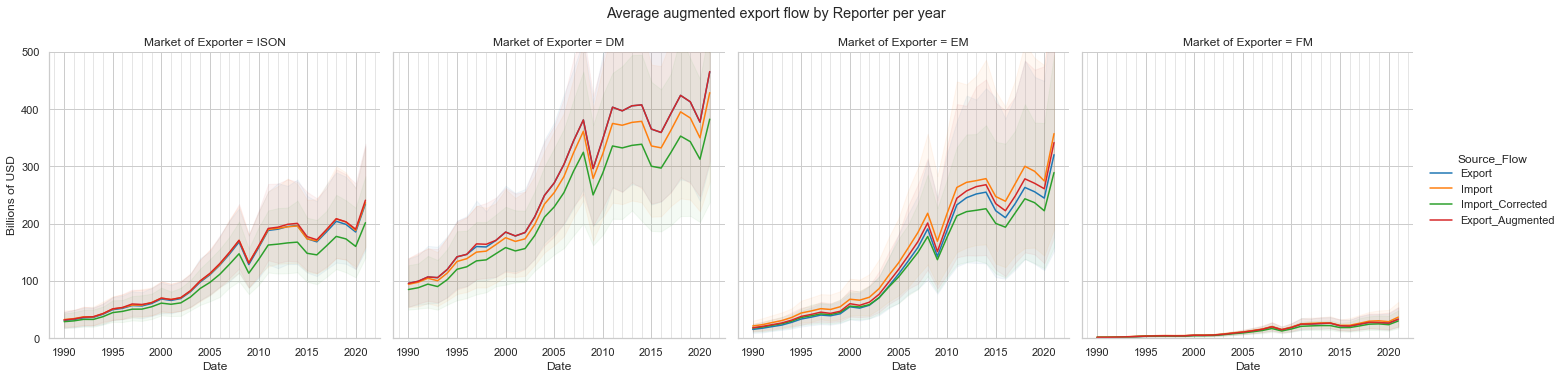

In [151]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: VISUALIZATION

gc.collect()
### Annualiziation:
dict_export_cif_ann = {}
for iter_flow in df_export_cif.columns:
    dict_export_cif_ann[iter_flow] = df_export_cif[iter_flow].unstack(['Reporter', 'Partner', 'Market']).resample('YS').sum().stack(['Reporter', 'Partner', 'Market'])
    dict_export_cif_ann[iter_flow].replace({0.0: np.NaN}, inplace = True)
df_export_cif_ann = pd.concat(dict_export_cif_ann, axis = 1)
df_options_sum = df_export_cif_ann.groupby(['Date', 'Reporter', 'Market']).sum() / 1000
ser_options_sum = df_options_sum.reset_index().melt(id_vars = ['Date', 'Reporter', 'Market'], var_name = 'Source_Flow', value_name = 'Export_Volume')\
                                .set_index(['Date', 'Reporter', 'Market', 'Source_Flow']).squeeze()
### Regions data aggregation:
dict_options_sum = {}
dict_options_sum['ISON'] = ser_options_sum.dropna().droplevel('Market')
for iter_region in list_regions:
    dict_options_sum[iter_region] = ser_options_sum.dropna().loc[All, All, iter_region, All]
### Export volume plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_options_sum, axis = 0, names = ['Market of Exporter']).reset_index()
df_to_plot.rename({0: 'Value'}, axis = 1, inplace = True)
fig_mean_unique = sns.relplot(data = df_to_plot, x = 'Date', y = 'Export_Volume', col = 'Market of Exporter', hue = 'Source_Flow', kind = 'line', 
                              err_kws = {'alpha': 0.05})
fig_mean_unique.fig.suptitle('Average augmented export flow by Reporter per year', y = 1.05)
fig_mean_unique.set_ylabels('Billions of USD')
fig_mean_unique.set(ylim = (0, 500))
### Axes customizing:
for iter_ax in fig_mean_unique.axes.ravel():
    ### Major ticker options:    
    iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5) 	
plt.show()

In [165]:
### TEMP

df_export_cif.dtypes

Date                datetime64[ns]
Reporter                  category
Partner                   category
Market                    category
Export                     float32
Import                     float32
Import_Corrected           float32
Export_Augmented           float32
dtype: object

In [166]:
### IMF DOTS: IMPORT DATA INCORPORATION: RESULTS SAVING

### Dataset saving:
df_export_cif = df_export_cif.astype('float32')
df_export_cif = df_export_cif.reset_index()
df_export_cif = df_export_cif.astype({'Reporter': 'category', 'Partner': 'category', 'Market': 'category'})
df_export_cif.to_hdf(path_or_buf = str_path_imf_dots_combined, key = str_full_imf_dots_combined, mode = 'w', format = 'table')
del df_export_cif
gc.collect()

73

In [8]:
### IMF CPIS: BILATERAL EQUITY & DEBT INVESTMENT POSITIONS

In [193]:
### IMF CPIS: GENERAL DATA PREPARATION

### Constants:
All = slice(None)
dict_request_headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'}
str_imf_base_url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
str_imf_dataflow_add = 'DataFlow'
str_imf_datastructure_add = 'DataStructure/'
str_imf_codelist_add = 'CodeList/'
str_imf_dataset_add = 'CompactData/'
int_seconds_to_sleep = 5
int_imf_country_limit = 30

In [194]:
### IMF CPIS: REQUESTS SESSION INITIALIZING

request_session = requests.Session()
### For avoiding data request errors from IMF Data Service:
request_session.headers.update(dict_request_headers)

In [195]:
### IMF CPIS: DATAFLOW SEARCHING

obj_imf_dataflow_list = request_session.get(str_imf_base_url + str_imf_dataflow_add).json()
df_imf_dataflow = pd.DataFrame(obj_imf_dataflow_list['Structure']['Dataflows']['Dataflow'])
df_imf_dataflow = df_imf_dataflow.assign(Description = df_imf_dataflow['Name'].apply(pd.Series)['#text'].values)[['@id', 'Description']]
ser_imf_dataflow = df_imf_dataflow.set_index('@id', drop = True).squeeze()
### Searching DataFlow code for further requests:
str_imf_cpis_id = ser_imf_dataflow[ser_imf_dataflow.str.contains('CPIS')].index[0].replace('DS-', '')
print(str_imf_cpis_id)

CPIS


In [196]:
### IMF CPIS: DATASTRUCTURE SEARCHING

obj_imf_cpis_structure = request_session.get(str_imf_base_url + str_imf_datastructure_add + str_imf_cpis_id).json()
df_imf_cpis_params = pd.DataFrame(obj_imf_cpis_structure['Structure']['KeyFamilies']['KeyFamily']['Components']['Dimension'])\
                                [['@conceptRef', '@codelist', '@isFrequencyDimension']]
### Receiving DataFlow parameters and code lists for each of them:
print(df_imf_cpis_params)

          @conceptRef          @codelist @isFrequencyDimension
0                FREQ            CL_FREQ                  true
1            REF_AREA       CL_AREA_CPIS                   NaN
2           INDICATOR  CL_INDICATOR_CPIS                   NaN
3          REF_SECTOR     CL_SECTOR_CPIS                   NaN
4  COUNTERPART_SECTOR     CL_SECTOR_CPIS                   NaN
5    COUNTERPART_AREA       CL_AREA_CPIS                   NaN


In [197]:
### IMF CPIS: CODES DESCRIPTION SEARCHING

for int_counter, str_param_code in enumerate(df_imf_cpis_params['@codelist']):
    if (int_counter >= 1):
        time.sleep(int_seconds_to_sleep)    
        obj_imf_cpis_param = request_session.get(str_imf_base_url + str_imf_codelist_add + str_param_code).json()
        df_imf_cpis_param =  pd.DataFrame(obj_imf_cpis_param['Structure']['CodeLists']['CodeList']['Code'])
        ### Receiving values for each code list:
        df_imf_cpis_param = df_imf_cpis_param.assign(Text = df_imf_cpis_param['Description'].apply(pd.Series)['#text'].values)[['@value', 'Text']]
        print(int_counter, ':', df_imf_cpis_params.iloc[int_counter, All]['@conceptRef'], ':', str_param_code, ':\n', df_imf_cpis_param.head(5))
    
str_cpis_freq = 'A' # 'B' # 
str_cpis_asset_indicator = 'I_A_T_T_T_BP6_USD' 
str_cpis_liability_indicator = 'I_L_T_T_T_BP6_USD'
str_cpis_ref_sector = 'T'
str_cpis_cp_sector = 'T'
list_ison_countries = sorted(list(map(str, ser_ison_membership.index.get_level_values(1).unique())))
# 0: FREQ == 'B' # Semi-annual frequency - they don't have Quaterly or Monthly frequency data
# 1: REF_AREA == '??' # Country
# 2: INDICATOR  == 'I_A_T_T_T_BP6_USD' # Assets, Total Investment, BPM6, US Dollars & I_L_T_T_T_BP6_USD    Liabilities, Total Investment, BPM6, US Dollars
# 3: REF_SECTOR == 'T' # Total Holdings (all sectors)
# 4: COUNTERPART_SECTOR  == 'T' # Total Holdings (all sectors)
# 5: COUNTERPART_AREA == '??' # Country

1 : REF_AREA : CL_AREA_CPIS :
   @value            Text
0     AF     Afghanistan
1     AL         Albania
2     DZ         Algeria
3     AS  American Samoa
4     AD         Andorra
2 : INDICATOR : CL_INDICATOR_CPIS :
               @value                                               Text
0  I_A_T_T_T_BP6_USD         Assets, Total Investment, BPM6, US Dollars
1  I_A_E_T_T_BP6_USD                   Assets, Equity, BPM6, US Dollars
2  I_A_D_T_T_BP6_USD          Assets, Debt Securities, BPM6, US Dollars
3  I_A_D_L_T_BP6_USD  Assets, Debt Securities, Long-term, BPM6, US D...
4  I_A_D_S_T_BP6_USD  Assets, Debt Securities, Short-term, BPM6, US ...
3 : REF_SECTOR : CL_SECTOR_CPIS :
   @value                                               Text
0      T                                     Total Holdings
1     FC                             Financial Corporations
2     DC                        Deposit Taking Corporations
3     CB                                       Central Bank
4    ODX  Depos

In [198]:
### IMF CPIS ASSETS: REPORTED TOTAL PORTFOLIO INVESTMENT ASSET DATASET RETRIEVING

list_cpis_bilateral = [] # List of bilateral dataframes for future concatenation
str_cpis_const_url = str_imf_base_url + str_imf_dataset_add + str_imf_cpis_id + '/' # Beggining of request URL
### Looping for reporter country groups:
for int_ison_reporter_part in range(0, - (len(list_ison_countries) // ( - int_imf_country_limit))):
    str_cpis_reporters = '+'.join(list_ison_countries[int_ison_reporter_part * int_imf_country_limit : (int_ison_reporter_part + 1) * int_imf_country_limit])
    ### Looping for partner country groups:
    for int_ison_partner_part in range(0, - (len(list_ison_countries) // ( - int_imf_country_limit))):
        str_cpis_partners = '+'.join(list_ison_countries[int_ison_partner_part * int_imf_country_limit : (int_ison_partner_part + 1) * int_imf_country_limit])    
        ### Generating complete request URL:
        str_cpis_full_url = str_cpis_const_url + \
                            '.'.join([str_cpis_freq, str_cpis_reporters, str_cpis_asset_indicator, str_cpis_ref_sector, str_cpis_ref_sector, str_cpis_partners])
        ### Receiving CPIS dataset from IMF API:
        print(int_ison_reporter_part * int_imf_country_limit, '-', (int_ison_reporter_part + 1) * int_imf_country_limit, ' / ',
              int_ison_partner_part * int_imf_country_limit, '-', (int_ison_partner_part + 1) * int_imf_country_limit)
        obj_cpis_set = request_session.get(str_cpis_full_url)
        ### Data reading as JSON:
        dict_cpis_set = json.loads(obj_cpis_set.text.replace('@OBS_STATUS', '@OBS_VALUE'))
        ### Converting each bilateral dataset to dataframe and it's mungling:
        for dict_cpis_pair in dict_cpis_set['CompactData']['DataSet']['Series']:
            if isinstance(dict_cpis_pair['Obs'], list):
                df_cpis_bilateral = pd.DataFrame(dict_cpis_pair['Obs'])
            else:
                df_cpis_bilateral = pd.DataFrame([dict_cpis_pair['Obs']])
            df_cpis_bilateral = df_cpis_bilateral[['@TIME_PERIOD', '@OBS_VALUE']]
            df_cpis_bilateral.columns = ['Date', 'Value']
            df_cpis_bilateral = df_cpis_bilateral.assign(Reporter_ID = dict_cpis_pair['@REF_AREA'])
            df_cpis_bilateral = df_cpis_bilateral.assign(Partner_ID = dict_cpis_pair['@COUNTERPART_AREA'])
            list_cpis_bilateral.append(df_cpis_bilateral)   
### Bilateral dataset aggregating:
df_cpis = pd.concat(list_cpis_bilateral, axis = 0, ignore_index = True)
df_cpis = df_cpis[df_cpis['Reporter_ID'] != df_cpis['Partner_ID']]
df_cpis.loc[df_cpis['Value'] == 'C', 'Value'] = np.NaN
df_cpis.loc[df_cpis['Value'] == '-', 'Value'] = np.NaN
df_cpis = df_cpis.astype({'Reporter_ID': 'str', 'Partner_ID': 'str', 'Value': 'float32'})
### Dataframe converting to standartized format series:
df_cpis['Date'] = pd.to_datetime(df_cpis['Date']) + pd.offsets.BYearEnd()
ser_asset_cpis_data = df_cpis.set_index(['Date', 'Reporter_ID', 'Partner_ID']).squeeze()
### Series saving:
ser_asset_cpis_data.to_hdf(path_or_buf = str_path_imf_cpis_dataset, key = str_asset_imf_cpis_dataset, mode = 'w')

0 - 30  /  0 - 30
0 - 30  /  30 - 60
0 - 30  /  60 - 90
30 - 60  /  0 - 30
30 - 60  /  30 - 60
30 - 60  /  60 - 90
60 - 90  /  0 - 30
60 - 90  /  30 - 60
60 - 90  /  60 - 90


In [25]:
### IMF CPIS ASSETS: TEST

ser_test = pd.read_hdf(path_or_buf = str_path_imf_cpis_dataset, key = str_asset_imf_cpis_dataset)
ser_test.loc[All, ['IL', 'US'], ['IL', 'US']].sort_index()

Date        Reporter_ID  Partner_ID
1997-12-31  IL           US              1427.234009
            US           IL             12207.000000
2001-12-31  IL           US              5850.000000
            US           IL             21233.212891
2002-12-31  IL           US              7420.000000
            US           IL             20109.000000
2003-12-31  IL           US              8438.000000
            US           IL             28664.000000
2004-12-31  IL           US             10524.000000
            US           IL             34315.234375
2005-12-30  IL           US             14446.000000
            US           IL             44313.000000
2006-12-29  IL           US             21353.000000
            US           IL             41517.000000
2007-12-31  IL           US             27653.000000
            US           IL             54250.000000
2008-12-31  IL           US             23387.000000
            US           IL             46064.000000
2009-12-31

In [ ]:
### IMF CPIS LIABILITIES: REPORTED TOTAL PORTFOLIO INVESTMENT LIABILITY DATASET RETRIEVING

list_cpis_bilateral = [] # List of bilateral dataframes for future concatenation
str_cpis_const_url = str_imf_base_url + str_imf_dataset_add + str_imf_cpis_id + '/' # Beggining of request URL
### Looping for reporter country groups:
for int_ison_reporter_part in range(0, - (len(list_ison_countries) // ( - int_imf_country_limit))):
    str_cpis_reporters = '+'.join(list_ison_countries[int_ison_reporter_part * int_imf_country_limit : (int_ison_reporter_part + 1) * int_imf_country_limit])
    ### Looping for partner country groups:
    for int_ison_partner_part in range(0, - (len(list_ison_countries) // ( - int_imf_country_limit))):
        str_cpis_partners = '+'.join(list_ison_countries[int_ison_partner_part * int_imf_country_limit : (int_ison_partner_part + 1) * int_imf_country_limit])    
        ### Generating complete request URL:
        str_cpis_full_url = str_cpis_const_url + \
                            '.'.join([str_cpis_freq, str_cpis_reporters, str_cpis_liability_indicator, str_cpis_ref_sector, str_cpis_ref_sector, str_cpis_partners])
        ### Receiving CPIS dataset from IMF API:
        print(int_ison_reporter_part * int_imf_country_limit, '-', (int_ison_reporter_part + 1) * int_imf_country_limit, ' / ',
              int_ison_partner_part * int_imf_country_limit, '-', (int_ison_partner_part + 1) * int_imf_country_limit)        
        obj_cpis_set = request_session.get(str_cpis_full_url)
        ### Data reading as JSON:
        dict_cpis_set = json.loads(obj_cpis_set.text.replace('@OBS_STATUS', '@OBS_VALUE'))        
        ### Converting each bilateral dataset to dataframe and it's mungling:
        for dict_cpis_pair in dict_cpis_set['CompactData']['DataSet']['Series']:
            if isinstance(dict_cpis_pair['Obs'], list):
                df_cpis_bilateral = pd.DataFrame(dict_cpis_pair['Obs'])
            else:
                df_cpis_bilateral = pd.DataFrame([dict_cpis_pair['Obs']])
            df_cpis_bilateral = df_cpis_bilateral[['@TIME_PERIOD', '@OBS_VALUE']]
            df_cpis_bilateral.columns = ['Date', 'Value']
            df_cpis_bilateral = df_cpis_bilateral.assign(Reporter_ID = dict_cpis_pair['@REF_AREA'])
            df_cpis_bilateral = df_cpis_bilateral.assign(Partner_ID = dict_cpis_pair['@COUNTERPART_AREA'])
            list_cpis_bilateral.append(df_cpis_bilateral)   
### Bilateral dataset aggregating:
df_cpis = pd.concat(list_cpis_bilateral, axis = 0, ignore_index = True)
df_cpis = df_cpis[df_cpis['Reporter_ID'] != df_cpis['Partner_ID']]
df_cpis.loc[df_cpis['Value'] == 'C', 'Value'] = np.NaN
df_cpis.loc[df_cpis['Value'] == '-', 'Value'] = np.NaN
df_cpis = df_cpis.astype({'Reporter_ID': 'str', 'Partner_ID': 'str', 'Value': 'float32'})
### Dataframe converting to stadartized format series:
df_cpis['Date'] = pd.to_datetime(df_cpis['Date']) + pd.offsets.BYearEnd()
ser_liability_cpis_data = df_cpis.set_index(['Date', 'Reporter_ID', 'Partner_ID']).squeeze()
### Series saving:
ser_liability_cpis_data.to_hdf(path_or_buf = str_path_imf_cpis_dataset, key = str_liability_imf_cpis_dataset, mode = 'r+')

In [23]:
### IMF CPIS LIABILITIES: TEST

ser_test = pd.read_hdf(path_or_buf = str_path_imf_cpis_dataset, key = str_liability_imf_cpis_dataset)
ser_test.loc[All, ['IL', 'US'], ['IL', 'US']].sort_index()

Date        Reporter_ID  Partner_ID
1997-12-31  IL           US            23469.263672
2001-12-31  IL           US            33878.000000
2002-12-31  IL           US            22088.000000
2003-12-31  IL           US            38927.000000
2004-12-31  IL           US            47307.000000
2005-12-30  IL           US            36607.000000
2006-12-29  IL           US            41663.000000
2007-12-31  IL           US            45654.000000
2008-12-31  IL           US            33499.000000
2009-12-31  IL           US            44335.000000
2010-12-31  IL           US            42909.000000
2011-12-30  IL           US            44762.000000
2012-12-31  IL           US            38732.000000
2013-12-31  IL           US            53317.000000
2014-12-31  IL           US            56346.000000
2015-12-31  IL           US            56999.000000
2016-12-30  IL           US            50454.000000
2017-12-29  IL           US            59811.000000
2018-12-31  IL           US 

In [8]:
### IMF CPIS POSITIONS: EXAMPLES

ser_cpis_asset = pd.read_hdf(path_or_buf = str_path_imf_cpis_dataset, key = str_asset_imf_cpis_dataset)
ser_cpis_liability = pd.read_hdf(path_or_buf = str_path_imf_cpis_dataset, key = str_liability_imf_cpis_dataset)
ser_cpis_full = pd.concat([ser_cpis_asset, ser_cpis_liability], keys = ['Asset', 'Liability'], names = ['Position'])
list_to_plot = ['IL', 'US']
str_date_to_compare = '2020-12-31'
print(ser_cpis_full.loc[All, ['1997-12-31', '2020-12-31'], list_to_plot, list_to_plot].unstack(['Position']))

Position                                   Asset     Liability
Date       Reporter_ID Partner_ID                             
1997-12-31 IL          US            1427.234009  23469.263672
           US          IL           12207.000000           NaN
2020-12-31 IL          US          119013.000000  89933.000000
           US          IL           94555.000000           NaN


<Figure size 1080x360 with 0 Axes>

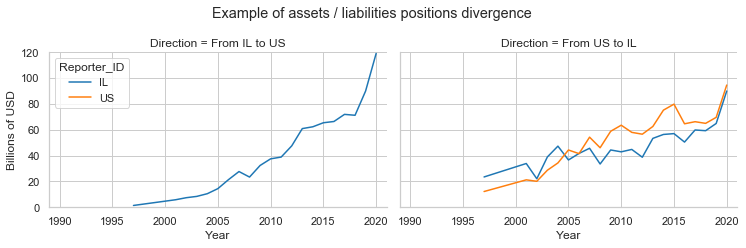

In [9]:
### IMF CPIS POSITIONS: EXAMPLES

df_to_plot = ser_cpis_full.loc[All, All, list_to_plot, list_to_plot].reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot['Direction'] = ((df_to_plot['Position'] == 'Asset') & (df_to_plot['Reporter_ID'] == 'IL')) | \
                          ((df_to_plot['Position'] == 'Liability') & (df_to_plot['Reporter_ID'] == 'US'))
df_to_plot.loc[~df_to_plot['Direction'], 'Direction'] = 'From US to IL'
df_to_plot.loc[df_to_plot['Direction'] == True, 'Direction'] = 'From IL to US'
df_to_plot['Value'] = df_to_plot['Value'] / 1000
sns.set_style('whitegrid')
plt.figure(figsize = (15, 5))
sns.set_context('notebook')
fig_example = sns.relplot(data = df_to_plot, x = 'Year', y = 'Value', col = 'Direction', hue = 'Reporter_ID', kind = 'line', height = 3.5, aspect = 1.5,
                          facet_kws = dict(legend_out = False))
fig_example.set(ylim = (0, 120), xlim = (date_start.year, date_end.year), ylabel = 'Billions of USD')
fig_example.fig.subplots_adjust(top = 0.80)
fig_example.fig.suptitle('Example of assets / liabilities positions divergence')
plt.show()

In [10]:
### IMF CPIS: STATS: POSITIONS COMPLETENESS

gc.collect()
df_flows = ser_cpis_full.unstack('Position')
df_flows.columns = ['Asset', 'Liability']
ser_ison_mapper = ser_ison_membership.copy()
ser_ison_mapper.index.set_names('Reporter_ID', level = -1, inplace = True)
df_ison_flows = df_flows.join(ser_ison_mapper)
df_ison_flows.rename({'Market': 'Reporter_Market'}, axis = 1, inplace = True)
ser_ison_mapper.index.set_names('Partner_ID', level = -1, inplace = True)
df_ison_flows = df_ison_flows.join(ser_ison_mapper)
df_ison_flows.rename({'Market': 'Partner_Market'}, axis = 1, inplace = True)
df_ison_flows.dropna(subset = ['Reporter_Market', 'Partner_Market'], inplace = True)
df_ison_stats = df_ison_flows.reset_index(['Partner_ID', 'Reporter_ID'], drop = True).set_index(['Reporter_Market', 'Partner_Market'], append = True)
print('ISON reporters quantity:', len(set(df_flows.index.get_level_values('Reporter_ID'))))
print('Absent ISON members as reporters:', set(ser_ison_membership.index.get_level_values('Country')) - set(df_flows.index.get_level_values('Reporter_ID')))
print('ISON partners quantity:', len(set(df_flows.index.get_level_values('Partner_ID'))))
print('Absent ISON members as partners:', set(ser_ison_membership.index.get_level_values('Country')) - set(df_flows.index.get_level_values('Partner_ID')))

ISON reporters quantity: 66
Absent ISON members as reporters: {'NG', 'UG', 'KE', 'HR', 'ZM', 'AE', 'MA', 'BW', 'OM', 'QA', 'RS', 'GH', 'TW', 'TN', 'LK', 'CI', 'EC', 'JO', 'VN'}
ISON partners quantity: 85
Absent ISON members as partners: set()


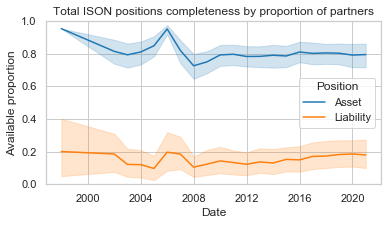

In [11]:
### IMF CPIS: STATS: FLOWS COMPLETENESS

ser_ison_mem_count = ser_ison_membership.groupby('Date').value_counts().groupby('Date').sum()
ser_ison_mem_count.name = 'ISON'

#df_ison_partners = df_ison_flows
df_ison_partners = df_ison_flows.drop('Partner_Market', axis = 1).set_index('Reporter_Market', append = True).groupby(['Date', 'Reporter_ID', 'Reporter_Market']).count()

df_ison_partners = df_ison_partners.join(ser_ison_mem_count)
df_ison_partners = pd.concat([df_ison_partners['Asset'] / df_ison_partners['ISON'], df_ison_partners['Liability'] / df_ison_partners['ISON']], axis = 1)
df_ison_partners.columns = ['Asset', 'Liability']
ser_ison_partners = df_ison_partners.stack()
ser_ison_partners.name = 'Proportion'
ser_ison_partners.index.rename('Position', level = -1, inplace = True)
sns.set_style('whitegrid')
plt.figure(figsize = (6, 3))
sns.set_context('notebook')
ax_completeness = sns.lineplot(data = ser_ison_partners.reset_index(), x = 'Date', y = 'Proportion', hue = 'Position')
ax_completeness.set(ylabel = 'Available proportion', title = 'Total ISON positions completeness by proportion of partners', ylim = (0.0, 1.0))
plt.show()

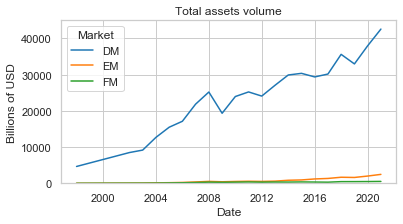

In [12]:
### IMF STATS: STATS: TOTAL TRADE VOLUME

ser_ison_status = ser_ison_membership.loc[date_end]
ser_ison_status.index.names = ['Reporter_ID']

ser_market_flows = df_flows['Asset'].groupby(['Date','Reporter_ID']).sum().to_frame().join(ser_ison_status).loc[: date_end].set_index('Market', append = True)
df_market_flows = ser_market_flows.groupby(['Date', 'Market']).sum() / 1000
df_to_plot = df_market_flows.reset_index()
sns.set_style('whitegrid')
plt.figure(figsize = (6, 3))
sns.set_context('notebook')
ax_sum_flows = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Asset', hue = 'Market')
ax_sum_flows.set(ylim = (0, 45000), ylabel = 'Billions of USD', title = 'Total assets volume')
plt.show()

In [14]:
### IMF CPIS: STATS: POSITIONS COMPARING

gc.collect()
df_straight_flows = df_flows.loc[: date_end]
df_straight_flows.columns = ['Straight_Asset', 'Straight_Liability']
df_reversed_flows = df_flows.loc[: date_end]
df_reversed_flows.index.names = ['Date', 'Partner_ID', 'Reporter_ID']
df_reversed_flows.columns = ['Reversed_Liability', 'Reversed_Asset']
df_reversed_flows = df_reversed_flows[['Reversed_Asset', 'Reversed_Liability']].reorder_levels([0, 2, 1])
print('Straight data first row:\n', df_straight_flows.iloc[: 1])
print('Reversed data first row:\n', df_reversed_flows.iloc[: 1])
df_straight_flows.sort_index(inplace = True)
df_reversed_flows.sort_index(inplace = True)
df_compare_flows = pd.concat([df_straight_flows, df_reversed_flows], axis = 1)

Straight data first row:
                                    Straight_Asset  Straight_Liability
Date       Reporter_ID Partner_ID                                    
1997-12-31 AR          AE                     0.0                 NaN
Reversed data first row:
                                    Reversed_Asset  Reversed_Liability
Date       Reporter_ID Partner_ID                                    
1997-12-31 AE          AR                     NaN                 0.0


In [ ]:
### IMF CPIS: STATS: POSITIONS COMPARING

int_min_rank_to_check = 5
int_max_coeff = 2

gc.collect()

dict_to_compare = {}
dict_to_compare['Asset'] = df_compare_flows[['Straight_Asset', 'Reversed_Asset']]
dict_to_compare['Liability'] = df_compare_flows[['Straight_Liability', 'Reversed_Liability']]
dict_united = {}

for iter_flow in dict_to_compare:
    df_iter_flow = dict_to_compare[iter_flow]
    print('Proportion of', iter_flow, 'values available:\n', round(df_iter_flow.count() / len(df_iter_flow.index), 2))
    set_straight = set(df_iter_flow['Straight_' + iter_flow].dropna().index)
    set_reversed = set(df_iter_flow['Reversed_' + iter_flow].dropna().index)
    print('Proportion of', iter_flow, 'unique straight observations:\n', round(len(set_straight - set_reversed) / len(df_iter_flow.index), 2))
    print('Proportion of', iter_flow, 'unique reversed observations:\n', round(len(set_reversed - set_straight) / len(df_iter_flow.index), 2))    
    print('Proportion of', iter_flow, 'union of straight and reversed observations:\n', round(len(set_reversed | set_straight) / len(df_iter_flow.index), 2))   

    int_anomaly_counter = 0
    for (iter_num, iter_missed) in enumerate(sorted(list(set_reversed - set_straight))):
        if divmod(iter_num, 1000)[-1] == 0:
            print(iter_num, '/', iter_missed)
        ser_iter_date = df_iter_flow['Straight_' + iter_flow].loc[iter_missed[0], iter_missed[1], All]
        flo_iter_missed = df_iter_flow['Reversed_' + iter_flow][iter_missed]
        ser_iter_date.loc[iter_missed] = flo_iter_missed
        if ((ser_iter_date.rank(ascending = False)[iter_missed] < int_min_rank_to_check + 1) & (flo_iter_missed > 1.0)):
            flo_iter_max = df_iter_flow['Straight_' + iter_flow].loc[All, iter_missed[1], iter_missed[2]].max()
            if (not np.isnan(flo_iter_max)):
                if (flo_iter_missed > int_max_coeff * flo_iter_max):
#                    print('Greater than historical max:\n', df_iter_flow['Reversed_' + iter_flow][[iter_missed]])
                    int_anomaly_counter += 1
                    ser_iter_date.loc[iter_missed] = np.NaN
    print(iter_flow, 'anomaly proportion:', round(int_anomaly_counter / iter_num, 2))

    dict_united[iter_flow] = df_iter_flow['Straight_' + iter_flow].combine_first(df_iter_flow['Reversed_' + iter_flow])

In [112]:
### IMF CPIS: POSITIONS COMBINING
	
gc.collect()
pd.concat(dict_united, axis = 1).to_hdf(path_or_buf = str_path_imf_cpis_combined, key = str_full_imf_cpis_combined, mode = 'w')

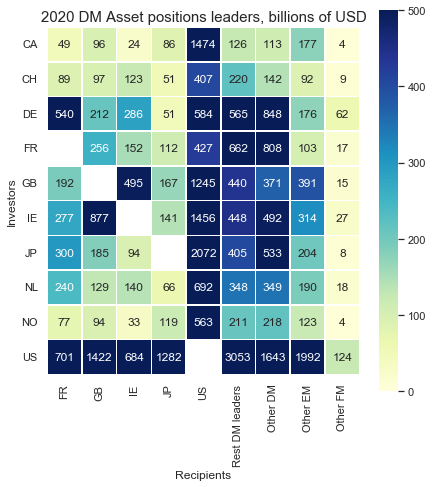

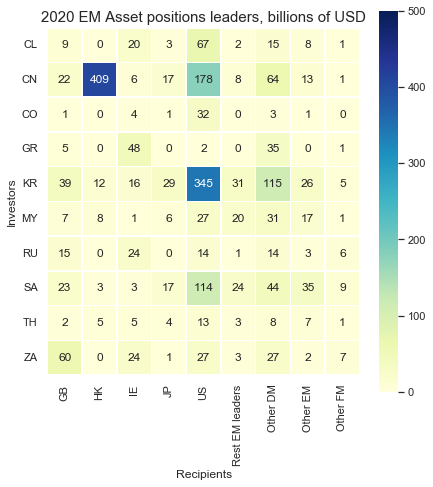

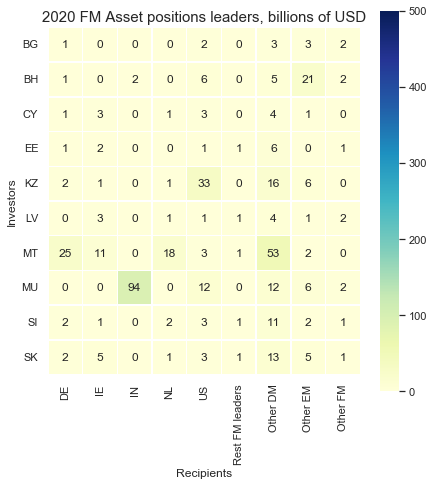

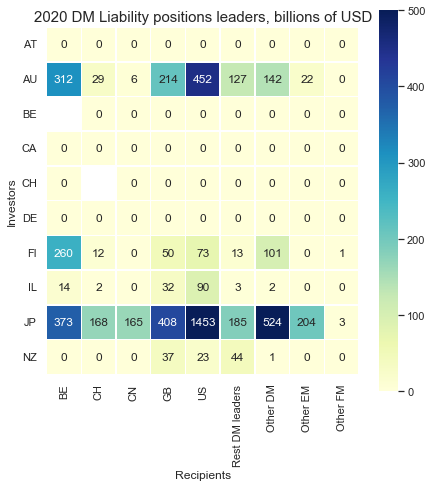

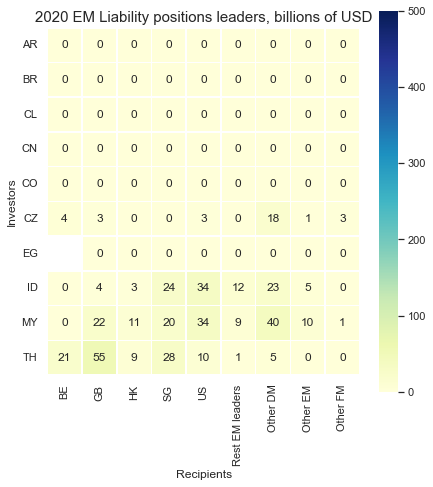

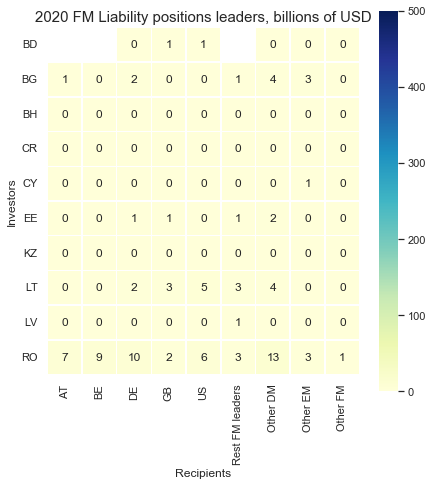

In [19]:
### IMF CPIS: STATS: INVESTMENT VOLUME 2020

int_top_reporters = 10
int_top_partners = 5

df_ison_value = df_ison_flows.set_index(['Reporter_Market', 'Partner_Market'], append = True)
df_ison_last = df_ison_value.loc['2020'].groupby(['Reporter_ID', 'Partner_ID', 'Reporter_Market', 'Partner_Market']).sum() / 1000

for iter_flow in df_ison_last.columns:
    for iter_market in ['DM', 'EM', 'FM']:
        df_iter_last = df_ison_last.loc[(All, All, iter_market, All), iter_flow].droplevel('Reporter_Market')
        list_reporter_leaders = df_iter_last.groupby('Reporter_ID').sum().nlargest(int_top_reporters).index.to_list()
        df_iter_lead = df_iter_last.loc[list_reporter_leaders]
        list_partner_leaders = df_iter_lead.groupby('Partner_ID').sum().nlargest(int_top_partners).index.to_list()
        df_top_part = df_iter_lead.loc[All, list_partner_leaders].groupby(['Reporter_ID', 'Partner_ID']).sum().unstack('Partner_ID')
        list_lost_leaders = set(list_reporter_leaders) - set(list_partner_leaders)
        df_lost_part = df_iter_lead.loc[All, list_lost_leaders].groupby('Reporter_ID').sum().to_frame()
        df_lost_part.columns = ['Rest ' + iter_market + ' leaders']        
        list_other_partners = list(set(df_iter_lead.index.get_level_values('Partner_ID')) - set(list_partner_leaders) - set(list_lost_leaders))
        df_other_part = df_iter_lead.loc[All, list_other_partners].groupby(['Reporter_ID', 'Partner_Market']).sum().unstack('Partner_Market')
        df_other_part.columns = ['Other ' + iter_col for iter_col in df_other_part.columns]
        df_iter_heat = pd.concat([df_top_part, df_lost_part, df_other_part], axis = 1, sort = False)

        plt.figure(figsize = (7, 7))
        ax_heatmap = sns.heatmap(df_iter_heat, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = True, annot = True, 
                                 fmt = '.0f', center = 250, vmin = 0, vmax = 500)
        ax_heatmap.set(xlabel = 'Recipients', ylabel = 'Investors')
        ax_heatmap.set_title('2020 ' + iter_market + ' ' + iter_flow + ' positions leaders, billions of USD', fontsize = 15)
        plt.yticks(rotation = 0)
        plt.show()
#        break
#    break

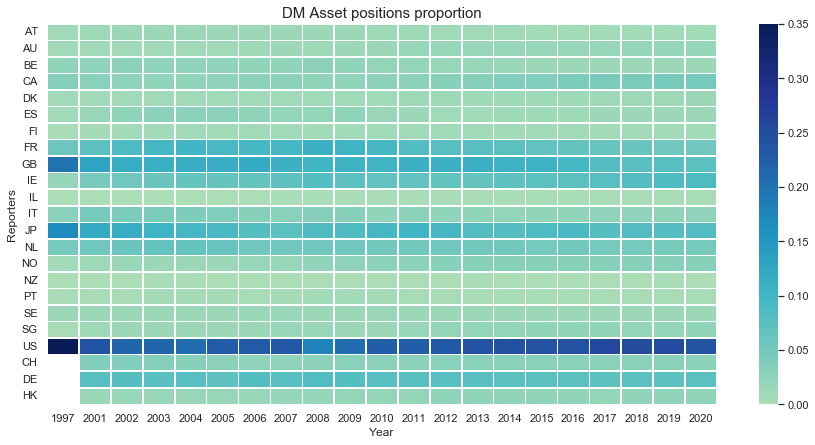

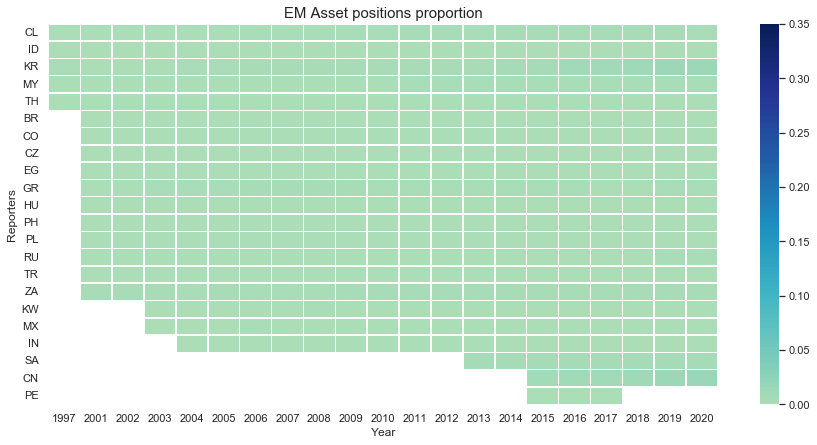

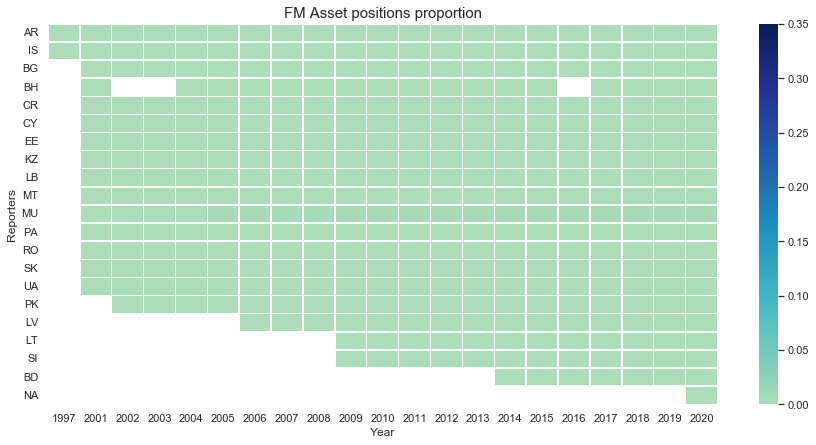

In [31]:
### IMF CPIS: STATS: TRADE PROPROTIONS HISTORY

df_market_history = ser_market_flows / 1000
df_market_history = df_market_history.reset_index('Date')
df_market_history['Year'] = df_market_history['Date'].dt.year

df_market_history = df_market_history.set_index('Year', append = True).drop('Date', axis = 1)

ser_market_sum = df_market_history.groupby('Year').sum().squeeze()
ser_market_sum.name = 'Sum'
df_market_history = df_market_history.join(ser_market_sum)
df_market_history['Proportion'] = df_market_history['Asset'] / df_market_history['Sum']

for iter_market in ['DM', 'EM', 'FM']:
    df_iter_history = df_market_history.loc[(All, iter_market, All), ['Proportion']].droplevel('Market').unstack('Year').droplevel(0, axis = 1)    
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_iter_history, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = False, 
                            fmt = '.0f', center = 0.1, vmin = 0.0, vmax = 0.35)
    ax_heatmap.set(xlabel = 'Year', ylabel = 'Reporters')
    ax_heatmap.set_title(iter_market + ' Asset positions proportion', fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()   

In [8]:
### OECD FDI: FOREIGN DIRECT INVESTMENT

In [9]:
### OECD FDI: GENERAL DATA PREPARATION

### Constants:
All = slice(None)
str_oecd_base_url = 'https://stats.oecd.org/sdmx-json/data/'
str_oecd_structure_url = 'https://stats.oecd.org/restsdmx/sdmx.ashx/GetDataStructure/'
str_fdi_flow_dataset_add = 'FDI_FLOW_CTRY'
str_fdi_pos_dataset_add = 'FDI_POS_CTRY'

In [18]:
### OECD FDI: REQUESTS SESSION INITIALIZING

request_session = requests.Session()
### For avoiding data request errors:
request_session.headers.update({'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'})

In [19]:
### OECD FDI: FDI POSITION STRUCTURE REQUEST

obj_oecd_structure = request_session.get(str_oecd_structure_url + str_fdi_pos_dataset_add)
xml_tree_root = et.fromstring(obj_oecd_structure.content)
dict_concepts = {}
dict_dimensions = {}
dict_codelists = {}
for xml_tree_child in xml_tree_root:
    if xml_tree_child.tag.endswith('Concepts'):
        for xml_tree_grand in xml_tree_child:
            str_concept_id = xml_tree_grand.attrib['id']
            str_concept_name = xml_tree_grand[0].text
            dict_concepts[str_concept_id] = str_concept_name
    if xml_tree_child.tag.endswith('KeyFamilies'):
        for xml_tree_family in xml_tree_child:
            for xml_tree_component in xml_tree_family:
                if xml_tree_component.tag.endswith('Components'):
                    for xml_tree_measure in xml_tree_component:
                        if xml_tree_measure.tag.endswith('Dimension'):
                            str_concept_id = xml_tree_measure.attrib['conceptRef']
                            str_concept_cl_id = xml_tree_measure.attrib['codelist']
                            dict_dimensions[str_concept_id] = str_concept_cl_id
    if xml_tree_child.tag.endswith('CodeLists'):       
        for num_tree_grand, xml_tree_grand in enumerate(xml_tree_child):
            str_codelist_id = xml_tree_grand.attrib['id']
            dict_codelist = {}
            for xml_tree_codelist in xml_tree_grand:                
                if xml_tree_codelist.tag.endswith('Code'):
                    str_code_id = xml_tree_codelist.attrib['value']
                    str_code_value = xml_tree_codelist[0].text
                    dict_codelist[str_code_id] = str_code_value
            dict_codelists[str_codelist_id] = dict_codelist

In [20]:
### OECD FDI: DIMENSIONS

pd.concat([pd.Series(dict_concepts), pd.Series(dict_dimensions)], axis = 1, sort = False).dropna()

,0,1
COU,Reporting country,CL_FDI_POS_CTRY_COU
MEASURE,Currency,CL_FDI_POS_CTRY_MEASURE
MEASURE_PRINCIPLE,Measurement principle,CL_FDI_POS_CTRY_MEASURE_PRINCIPLE
FDI_TYPE,Type of FDI,CL_FDI_POS_CTRY_FDI_TYPE
TYPE_ENTITY,Type of entity,CL_FDI_POS_CTRY_TYPE_ENTITY
ACCOUNTING_ENTRY,Accounting entry,CL_FDI_POS_CTRY_ACCOUNTING_ENTRY
LEVEL_COUNTERPART,Level of counterpart,CL_FDI_POS_CTRY_LEVEL_COUNTERPART
COUNTERPART_AREA,Partner country/territory,CL_FDI_POS_CTRY_COUNTERPART_AREA
TIME,Year,CL_FDI_POS_CTRY_TIME


In [21]:
### OECD FDI: FDI POSITION CONCEPT SOURCE CODELISTS:

dict_codelists['CL_FDI_POS_CTRY_ACCOUNTING_ENTRY']

{'NET': 'Net ', 'A': 'Assets ', 'L': 'Liabilities '}

In [22]:
### OECD FDI: FDI POSITION PARAMETERS PREPARATION: Non-country parameters:

### Currency:
str_measure = 'USD'
### Direction:
str_direction = '+'.join(['DI', 'DO'])
### Investment type:
str_fdi_type = 'LE_FA_F'
### Residence defining:
str_residence = 'ALL'
### Accounting way:
str_accounting = '+'.join(['NET', 'A', 'L']) # 'NET' # 
### Level counterpart(???):
str_counterpart = 'IMC'

In [23]:
### OECD FDI: FDI POSITION PARAMETERS PREPARATION: Reporters and partners control and preparation

### ISON Countries collecting:
df_ison_countries = df_country_codes.set_index('ISO SHORT', append = True).reset_index('COUNTRY', drop = True)
df_ison_countries = df_ison_countries.reindex(ser_ison_membership.index.get_level_values(1).unique().to_list())
ser_ison_countries = df_ison_countries.reset_index().set_index('ISO LONG').squeeze()
### OECD reporters vs ISON members:
ser_oecd_reporters = pd.Series(dict_codelists['CL_FDI_POS_CTRY_COU'])
ser_oecd_reporters = ser_oecd_reporters.to_frame().join(ser_ison_countries).drop(0, axis = 1).squeeze()
for iter_iso_long in (ser_oecd_reporters[ser_oecd_reporters.isna()].index.get_level_values(0)):
    if iter_iso_long in ser_ison_countries.index:
        print('OECD Reporter country with no ISON match:', iter_iso_long)
### ISON countries with no OECD reporter match:
set_no_reporters = set(ser_ison_countries.dropna().index) - set(ser_oecd_reporters.index)
print('ISON countries with no OECD reporter match:', set_no_reporters, '(', len(set_no_reporters), ')')           
### OECD partners vs ISON members:
ser_oecd_partners = pd.Series(dict_codelists['CL_FDI_POS_CTRY_COUNTERPART_AREA'])
ser_oecd_partners = ser_oecd_partners.to_frame().join(ser_ison_countries).drop(0, axis = 1).squeeze()
for iter_iso_long in (ser_oecd_partners[ser_oecd_partners.isna()].index.get_level_values(0)):
    if iter_iso_long in ser_ison_countries.index:
        print('OECD Partner country with no ISON match:', iter_iso_long)
### ISON countries with no OECD partner match:
set_no_partners = set(ser_ison_countries.dropna().index) - set(ser_oecd_partners.index)
print('ISON countries with no OECD partner match:', set_no_partners, '(', len(set_no_partners), ')')
### Lists preparation:
str_reporters_all = '+'.join(ser_oecd_reporters.dropna().index.to_list())
str_partners_all = '+'.join(ser_oecd_partners.dropna().index.to_list())

ISON countries with no OECD reporter match: {'KEN', 'IND', 'PAK', 'BHR', 'NGA', 'ECU', 'ARG', 'HKG', 'BGR', 'BGD', 'CIV', 'LKA', 'TUN', 'MLT', 'PHL', 'ZMB', 'JOR', 'ROU', 'QAT', 'SGP', 'MUS', 'VNM', 'SAU', 'IDN', 'HRV', 'KAZ', 'PAN', 'RUS', 'CYP', 'ARE', 'NAM', 'MAR', 'UGA', 'ZAF', 'EGY', 'CHN', 'OMN', 'CRI', 'GHA', 'KWT', 'LBN', 'UKR', 'BRA', 'TWN', 'BWA', 'MYS', 'PER', 'SRB', 'THA'} ( 49 )
ISON countries with no OECD partner match: {'ROU'} ( 1 )


In [24]:
### OECD FDI: FDI POSITION REQUEST CONSTRUCTING

str_fdi_pos_request_params = '.'.join([str_reporters_all, str_measure, str_direction, str_fdi_type, str_residence, str_accounting, str_counterpart, str_partners_all])
str_fdi_pos_request = str_oecd_base_url + str_fdi_pos_dataset_add + '/' + str_fdi_pos_request_params + '/all?startTime=1980&endTime=2020&detail=DataOnly'
obj_fdi_pos_dataset = request_session.get(str_fdi_pos_request).json()
#str_fdi_flow_request

In [25]:
### OECD FDI: FDI POSITION INDEX DATA COLLECTING:

### Dates:
list_idx_dates = []
for tup_date in obj_fdi_pos_dataset['structure']['dimensions']['observation'][0]['values']:
    list_idx_dates.append(pd.to_datetime(tup_date['id']) + pd.offsets.BYearEnd())
### Parameters:    
list_idx_library = []
for iter_position in obj_fdi_pos_dataset['structure']['dimensions']['series']:
    list_param_values = []
    for tup_parameter in iter_position['values']:
        list_param_values.append(tup_parameter['id'])            
    list_idx_library.append(list_param_values)
### Result:
list_idx_library.append(list_idx_dates)
### Converting to dictionary for future replacing:
list_idx_dict = []
for iter_list in list_idx_library:
    list_idx_dict.append(dict(zip(map(str, range(len(iter_list))), iter_list)))

In [26]:
### OECD FDI: FDI POSITION DATASET RESAMPLING

dict_datasets_res = {}
dict_datasets_source = obj_fdi_pos_dataset['dataSets'][0]['series']
### Parameters and date indexes integration:
for iter_dataset in dict_datasets_source:
    dict_observations = dict_datasets_source[iter_dataset]['observations']
    for iter_observation in dict_observations:
        str_iter_idx = iter_dataset + ':' + iter_observation
        flo_iter_value = dict_observations[iter_observation][0]
        dict_datasets_res[str_iter_idx] = flo_iter_value

In [27]:
### OECD FDI: FDI POSITION DATASET REINDEXATION

df_fdi_pos_data = pd.Series(dict_datasets_res)
df_fdi_pos_data.index = pd.MultiIndex.from_arrays(zip(*df_fdi_pos_data.index.str.split(':')))
int_levels_number = df_fdi_pos_data.index.nlevels
df_fdi_pos_data = df_fdi_pos_data.reset_index()
### Replacing numbers with parameter values:
for iter_level in range(int_levels_number):
    df_fdi_pos_data['level_' + str(iter_level)].replace(list_idx_dict[iter_level], inplace = True)
    ### Replacing long ISO names with short ISO names:
    if (iter_level == 0):
        df_fdi_pos_data['level_' + str(iter_level)].replace(dict(zip(ser_oecd_reporters.index, ser_oecd_reporters)), inplace = True)
    elif (iter_level == 7):
        df_fdi_pos_data['level_' + str(iter_level)].replace(dict(zip(ser_oecd_partners.index, ser_oecd_partners)), inplace = True)      
    ### Directions renaming:
    elif (iter_level == 2):
        df_fdi_pos_data['level_' + str(iter_level)].replace({'DI': 'Inward', 'DO': 'Outward'}, inplace = True)
    ### Flow types renaming:
    elif (iter_level == 5):
        df_fdi_pos_data['level_' + str(iter_level)].replace({'NET': 'Net', 'A': 'Asset', 'L': 'Liability'}, inplace = True)      

### Indexes defining:
ser_fdi_pos_data = df_fdi_pos_data.drop(['level_3', 'level_4', 'level_6'], axis = 1)\
                    .set_index(['level_2', 'level_8', 'level_0', 'level_7', 'level_1', 'level_5']).squeeze()
ser_fdi_pos_data.index.names = ['Direction', 'Date', 'Reporter_ID', 'Partner_ID', 'Currency', 'Accounting']
ser_fdi_pos_data.sort_index(inplace = True)
ser_fdi_pos_data = ser_fdi_pos_data[ser_fdi_pos_data.index.get_level_values('Reporter_ID') != ser_fdi_pos_data.index.get_level_values('Partner_ID')]
ser_fdi_pos_data.name = 'FDI Positions'

In [28]:
### OECD FDI: FDI POSITION DATASET CONVERTING TO ASSET / LIABILITY DIMENSION: EMPTY VALUES FILLING

df_fdi_pos_acc = ser_fdi_pos_data.droplevel('Currency').unstack('Accounting')

df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Outward') & 
                   (df_fdi_pos_acc['Net'] < 0.0) & (df_fdi_pos_acc['Asset'].isna() & df_fdi_pos_acc['Liability'].isna()), 'Liability'] = -df_fdi_pos_acc['Net']
df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Outward') & 
                   (df_fdi_pos_acc['Net'] >= 0.0) & (df_fdi_pos_acc['Asset'].isna() & df_fdi_pos_acc['Liability'].isna()), 'Asset'] = df_fdi_pos_acc['Net']
df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Inward') & 
                   (df_fdi_pos_acc['Net'] < 0.0) & (df_fdi_pos_acc['Asset'].isna() & df_fdi_pos_acc['Liability'].isna()), 'Asset'] = -df_fdi_pos_acc['Net']
df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Inward') & 
                   (df_fdi_pos_acc['Net'] >= 0.0) & (df_fdi_pos_acc['Asset'].isna() & df_fdi_pos_acc['Liability'].isna()), 'Liability'] = df_fdi_pos_acc['Net']
print('Only Net is filled:\n', df_fdi_pos_acc[df_fdi_pos_acc['Net'].notna() & (df_fdi_pos_acc['Asset'].isna() & df_fdi_pos_acc['Liability'].isna())])

df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Outward') & df_fdi_pos_acc['Net'].isna(), 'Net'] = \
                                                                      df_fdi_pos_acc['Asset'] - df_fdi_pos_acc['Liability']
df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Inward') & df_fdi_pos_acc['Net'].isna(), 'Net'] = \
                                                                      df_fdi_pos_acc['Liability'] - df_fdi_pos_acc['Asset']
print('Empty Net value when Asset & Liability are filled:\n', 
      df_fdi_pos_acc[df_fdi_pos_acc['Net'].isna() & df_fdi_pos_acc['Asset'].notna() & df_fdi_pos_acc['Liability'].notna()])

df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Outward') & df_fdi_pos_acc['Net'].isna() & df_fdi_pos_acc['Asset'].notna(), 'Net'] = \
                                                                                                                                      df_fdi_pos_acc['Asset']
df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Outward') & df_fdi_pos_acc['Net'].isna() & df_fdi_pos_acc['Liability'].notna(), 'Net'] = \
                                                                                                                                     -df_fdi_pos_acc['Liability']
df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Inward') & df_fdi_pos_acc['Net'].isna() & df_fdi_pos_acc['Asset'].notna(), 'Net'] = \
                                                                                                                                    -df_fdi_pos_acc['Asset']
df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Inward') & df_fdi_pos_acc['Net'].isna() & df_fdi_pos_acc['Liability'].notna(), 'Net'] = \
                                                                                                                                     df_fdi_pos_acc['Liability']
print('Empty Net value when Asset or Liability are filled:\n', 
      df_fdi_pos_acc[df_fdi_pos_acc['Net'].isna() & (df_fdi_pos_acc['Asset'].notna() | df_fdi_pos_acc['Liability'].notna())])

df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Outward') & 
                   df_fdi_pos_acc['Net'].notna() & df_fdi_pos_acc['Asset'].notna() & df_fdi_pos_acc['Liability'].isna(), 'Liability'] = \
                                                                                      df_fdi_pos_acc['Asset'] - df_fdi_pos_acc['Net']
df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Outward') & 
                   df_fdi_pos_acc['Net'].notna() & df_fdi_pos_acc['Asset'].isna() & df_fdi_pos_acc['Liability'].notna(), 'Asset'] = \
                                                                              df_fdi_pos_acc['Net'] + df_fdi_pos_acc['Liability']
df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Inward') & 
                   df_fdi_pos_acc['Net'].notna() & df_fdi_pos_acc['Asset'].notna() & df_fdi_pos_acc['Liability'].isna(), 'Liability'] = \
                                                                                      df_fdi_pos_acc['Net'] + df_fdi_pos_acc['Asset']
df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Inward') & 
                   df_fdi_pos_acc['Net'].notna() & df_fdi_pos_acc['Asset'].isna() & df_fdi_pos_acc['Liability'].notna(), 'Asset'] = \
                                                                              df_fdi_pos_acc['Liability'] - df_fdi_pos_acc['Net']
print('Empty Net / Asset / Liability value when two others are filled:\n', set(df_fdi_pos_acc.dropna(thresh = 2).index) - set(df_fdi_pos_acc.dropna().index))

Only Net is filled:
 Empty DataFrame
Columns: [Asset, Liability, Net]
Index: []
Empty Net value when Asset & Liability are filled:
 Empty DataFrame
Columns: [Asset, Liability, Net]
Index: []
Empty Net value when Asset or Liability are filled:
 Empty DataFrame
Columns: [Asset, Liability, Net]
Index: []
Empty Net / Asset / Liability value when two others are filled:
 set()


In [29]:
### OECD FDI: FDI POSITION DATASET CONVERTING TO ASSET / LIABILITY DIMENSION: CALCULATING

ser_fdi_pos_acc = df_fdi_pos_acc.stack('Accounting', dropna = False).unstack('Direction').sort_index().loc[(All, All, All, ['Asset', 'Liability']), All].sum(axis = 1)
ser_fdi_pos_acc = ser_fdi_pos_acc.reorder_levels([-1, 0, 1, 2]).sort_index()
ser_fdi_pos_acc.index.rename('Position', level = 0, inplace = True)

In [31]:
### OECD FDI: FDI POSITIONS SAVING

ser_fdi_pos_acc.to_hdf(path_or_buf = str_path_fdi_dataset, key = str_fdi_pos_oecd_dataset, mode = 'w')

In [32]:
### OECD FDI: FDI POSITIONS: TEST

ser_test = pd.read_hdf(path_or_buf = str_path_fdi_dataset, key = str_fdi_pos_oecd_dataset)
ser_test.loc[All, All, ['IL', 'US'], ['IL', 'US']].sort_index()

Position   Date        Reporter_ID  Partner_ID
Asset      2011-12-30  IL           US            13197.709998
                       US           IL            12472.000000
           2012-12-31  IL           US            18012.276303
                       US           IL            11715.000000
           2013-12-31  IL           US            11991.566771
                       US           IL            11065.000000
           2014-12-31  IL           US            11364.862797
                       US           IL            13977.000000
           2015-12-31  IL           US            10776.000000
                       US           IL            13863.000000
           2016-12-30  IL           US            10517.000000
                       US           IL            14149.000000
           2017-12-29  IL           US            11133.000000
                       US           IL            30195.000000
           2018-12-31  IL           US            12017.000000
        

In [38]:
### OECD FDI: FDI POSITIONS: EXAMPLES

ser_fdi_pos = pd.read_hdf(path_or_buf = str_path_fdi_dataset, key = str_fdi_pos_oecd_dataset)
ser_fdi_pos.name = 'Value'
list_to_plot = ['IL', 'US']
print(ser_fdi_pos.loc[All, ['2011-12-30', '2020-12-31'], list_to_plot, list_to_plot].unstack(['Position']))

Position                                  Asset     Liability
Date       Reporter_ID Partner_ID                            
2011-12-30 IL          US          13197.709998  15509.973318
           US          IL          12472.000000  12753.000000
2020-12-31 US          IL          41780.000000  16571.000000


<Figure size 1080x360 with 0 Axes>

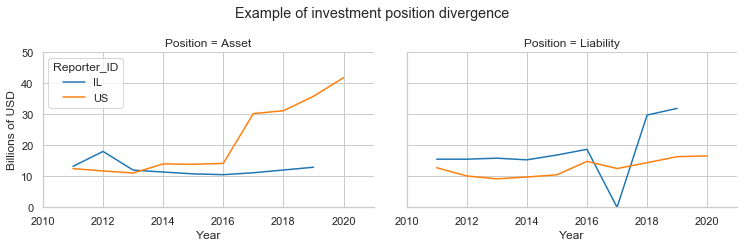

In [39]:
### OECD FDI: FDI POSITIONS: EXAMPLES

df_to_plot = ser_fdi_pos.loc[All, All, list_to_plot, list_to_plot].reset_index()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot['Direction'] = ((df_to_plot['Position'] == 'Liability') & (df_to_plot['Reporter_ID'] == 'IL')) | \
                          ((df_to_plot['Position'] == 'Asset') & (df_to_plot['Reporter_ID'] == 'US'))
df_to_plot.loc[~df_to_plot['Direction'], 'Direction'] = 'From US to IL'
df_to_plot.loc[df_to_plot['Direction'] == True, 'Direction'] = 'From IL to US'
df_to_plot['Value'] = df_to_plot['Value'] / 1000
sns.set_style('whitegrid')
plt.figure(figsize = (15, 5))
sns.set_context('notebook')
fig_example = sns.relplot(data = df_to_plot, x = 'Year', y = 'Value', col = 'Position', hue = 'Reporter_ID', kind = 'line', height = 3.5, aspect = 1.5,
                          facet_kws = dict(legend_out = False))
fig_example.fig.subplots_adjust(wspace = 0.1)
fig_example.set(ylim = (0.0, 50.0), xlim = (2010, date_end.year), ylabel = 'Billions of USD')
fig_example.fig.subplots_adjust(top = 0.8)
fig_example.fig.suptitle('Example of investment position divergence')
plt.show()

In [41]:
### OECD FDI: STATS: POSITIONS COMPLETENESS

gc.collect()
df_flows = ser_fdi_pos.unstack('Position')
df_flows.columns = ['Asset', 'Liability']
ser_ison_mapper = ser_ison_membership.copy()
ser_ison_mapper.index.set_names('Reporter_ID', level = -1, inplace = True)
df_ison_flows = df_flows.join(ser_ison_mapper)
df_ison_flows.rename({'Market': 'Reporter_Market'}, axis = 1, inplace = True)
ser_ison_mapper.index.set_names('Partner_ID', level = -1, inplace = True)
df_ison_flows = df_ison_flows.join(ser_ison_mapper)
df_ison_flows.rename({'Market': 'Partner_Market'}, axis = 1, inplace = True)
df_ison_flows.dropna(subset = ['Reporter_Market', 'Partner_Market'], inplace = True)
df_ison_stats = df_ison_flows.reset_index(['Partner_ID', 'Reporter_ID'], drop = True).set_index(['Reporter_Market', 'Partner_Market'], append = True)
print('ISON reporters quantity:', len(set(df_flows.index.get_level_values('Reporter_ID'))))
print('Absent ISON members as reporters:', set(ser_ison_membership.index.get_level_values('Country')) - set(df_flows.index.get_level_values('Reporter_ID')))
print('ISON partners quantity:', len(set(df_flows.index.get_level_values('Partner_ID'))))
print('Absent ISON members as partners:', set(ser_ison_membership.index.get_level_values('Country')) - set(df_flows.index.get_level_values('Partner_ID')))

ISON reporters quantity: 35
Absent ISON members as reporters: {'EG', 'MY', 'NG', 'BH', 'PE', 'PH', 'CR', 'MA', 'RS', 'CY', 'BR', 'BG', 'LB', 'TW', 'PA', 'VN', 'MX', 'LK', 'CI', 'HK', 'TH', 'UA', 'AE', 'NA', 'ID', 'CN', 'MU', 'RO', 'RU', 'ZA', 'SA', 'PK', 'KZ', 'QA', 'BD', 'ZM', 'AR', 'MT', 'HR', 'BW', 'KE', 'OM', 'EC', 'KW', 'GH', 'TN', 'UG', 'SG', 'JO', 'IN'}
ISON partners quantity: 84
Absent ISON members as partners: {'RO'}


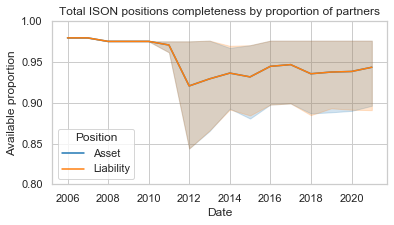

In [43]:
### OECD FDI: STATS: POSITIONS COMPLETENESS

ser_ison_mem_count = ser_ison_membership.groupby('Date').value_counts().groupby('Date').sum()
ser_ison_mem_count.name = 'ISON'

#df_ison_partners = df_ison_flows
df_ison_partners = df_ison_flows.drop('Partner_Market', axis = 1).set_index('Reporter_Market', append = True).groupby(['Date', 'Reporter_ID', 'Reporter_Market']).count()

df_ison_partners = df_ison_partners.join(ser_ison_mem_count)
df_ison_partners = pd.concat([df_ison_partners['Asset'] / df_ison_partners['ISON'], df_ison_partners['Liability'] / df_ison_partners['ISON']], axis = 1)
df_ison_partners.columns = ['Asset', 'Liability']
ser_ison_partners = df_ison_partners.stack()
ser_ison_partners.name = 'Proportion'
ser_ison_partners.index.rename('Position', level = -1, inplace = True)
sns.set_style('whitegrid')
plt.figure(figsize = (6, 3))
sns.set_context('notebook')
ax_completeness = sns.lineplot(data = ser_ison_partners.reset_index(), x = 'Date', y = 'Proportion', hue = 'Position')
ax_completeness.set(ylabel = 'Available proportion', title = 'Total ISON positions completeness by proportion of partners', ylim = (0.8, 1.0))
plt.show()

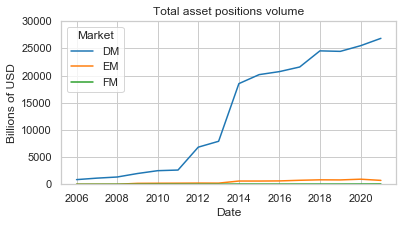

In [46]:
### OECD FDI: STATS: TOTAL OUTWARD INVESTMENT VOLUME

ser_ison_status = ser_ison_membership.loc[date_end]
ser_ison_status.index.names = ['Reporter_ID']

ser_market_flows = df_flows['Asset'].groupby(['Date','Reporter_ID']).sum().to_frame().join(ser_ison_status).loc[: date_end].set_index('Market', append = True)
df_market_flows = ser_market_flows.groupby(['Date', 'Market']).sum() / 1000
df_to_plot = df_market_flows.reset_index()
sns.set_style('whitegrid')
plt.figure(figsize = (6, 3))
sns.set_context('notebook')
ax_sum_flows = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Asset', hue = 'Market', hue_order = ['DM', 'EM', 'FM'])
ax_sum_flows.set(ylim = (0, 30000), ylabel = 'Billions of USD', title = 'Total asset positions volume')
plt.show()

In [49]:
### OECD FDI: STATS: FLOWS COMPARING

gc.collect()
df_straight_flows = df_flows.loc[: date_end]
df_straight_flows.columns = ['Straight_Asset', 'Straight_Liability']
df_reversed_flows = df_flows.loc[: date_end]
df_reversed_flows.index.names = ['Date', 'Partner_ID', 'Reporter_ID']
df_reversed_flows.columns = ['Reversed_Liability', 'Reversed_Asset']
df_reversed_flows = df_reversed_flows[['Reversed_Asset', 'Reversed_Liability']].reorder_levels([0, 2, 1])
print('Straight data first row:\n', df_straight_flows.iloc[-1 : ])
print('Reversed data first row:\n', df_reversed_flows.iloc[-1 : ])
df_straight_flows.sort_index(inplace = True)
df_reversed_flows.sort_index(inplace = True)
df_compare_flows = pd.concat([df_straight_flows, df_reversed_flows], axis = 1)

Straight data first row:
                                    Straight_Asset  Straight_Liability
Date       Reporter_ID Partner_ID                                    
2020-12-31 US          ZM                    22.0                 0.0
Reversed data first row:
                                    Reversed_Asset  Reversed_Liability
Date       Reporter_ID Partner_ID                                    
2020-12-31 ZM          US                     0.0                22.0


In [51]:
### OECD FDI: STATS: POSITIONS COMPARING

int_min_rank_to_check = 5
int_max_coeff = 2

gc.collect()

dict_to_compare = {}
dict_to_compare['Asset'] = df_compare_flows[['Straight_Asset', 'Reversed_Asset']]
dict_to_compare['Liability'] = df_compare_flows[['Straight_Liability', 'Reversed_Liability']]
dict_united = {}

for iter_flow in dict_to_compare:
    df_iter_flow = dict_to_compare[iter_flow]
    print('Proportion of', iter_flow, 'values available:\n', round(df_iter_flow.count() / len(df_iter_flow.index), 2))
    set_straight = set(df_iter_flow['Straight_' + iter_flow].dropna().index)
    set_reversed = set(df_iter_flow['Reversed_' + iter_flow].dropna().index)
    print('Proportion of', iter_flow, 'unique straight observations:\n', round(len(set_straight - set_reversed) / len(df_iter_flow.index), 2))
    print('Proportion of', iter_flow, 'unique reversed observations:\n', round(len(set_reversed - set_straight) / len(df_iter_flow.index), 2))    
    print('Proportion of', iter_flow, 'union of straight and reversed observations:\n', round(len(set_reversed | set_straight) / len(df_iter_flow.index), 2))   

    int_anomaly_counter = 0
    for (iter_num, iter_missed) in enumerate(sorted(list(set_reversed - set_straight))):
        if divmod(iter_num, 1000)[-1] == 0:
            print(iter_num, '/', iter_missed)
        ser_iter_date = df_iter_flow['Straight_' + iter_flow].loc[iter_missed[0], iter_missed[1], All]
        flo_iter_missed = df_iter_flow['Reversed_' + iter_flow][iter_missed]
        ser_iter_date.loc[iter_missed] = flo_iter_missed
        if ((ser_iter_date.rank(ascending = False)[iter_missed] < int_min_rank_to_check + 1) & (flo_iter_missed > 1.0)):
            flo_iter_max = df_iter_flow['Straight_' + iter_flow].loc[All, iter_missed[1], iter_missed[2]].max()
            if (not np.isnan(flo_iter_max)):
                if (flo_iter_missed > int_max_coeff * flo_iter_max):
#                    print('Greater than historical max:\n', df_iter_flow['Reversed_' + iter_flow][[iter_missed]])
                    int_anomaly_counter += 1
                    ser_iter_date.loc[iter_missed] = np.NaN
    print(iter_flow, 'anomaly proportion:', round(int_anomaly_counter / iter_num, 2))

    dict_united[iter_flow] = df_iter_flow['Straight_' + iter_flow].combine_first(df_iter_flow['Reversed_' + iter_flow])

Proportion of Asset values available:
 Straight_Asset    0.6
Reversed_Asset    0.6
dtype: float64
Proportion of Asset unique straight observations:
 0.4
Proportion of Asset unique reversed observations:
 0.4
Proportion of Asset union of straight and reversed observations:
 1.0
0 / (Timestamp('2005-12-30 00:00:00'), 'AE', 'CO')
1000 / (Timestamp('2007-12-31 00:00:00'), 'CA', 'LV')
2000 / (Timestamp('2008-12-31 00:00:00'), 'ZA', 'HU')
3000 / (Timestamp('2010-12-31 00:00:00'), 'DK', 'SI')
4000 / (Timestamp('2011-12-30 00:00:00'), 'IS', 'FR')
5000 / (Timestamp('2012-12-31 00:00:00'), 'JP', 'IE')
6000 / (Timestamp('2013-12-31 00:00:00'), 'EG', 'DE')
7000 / (Timestamp('2013-12-31 00:00:00'), 'TN', 'NL')
8000 / (Timestamp('2014-12-31 00:00:00'), 'LK', 'IS')
9000 / (Timestamp('2015-12-31 00:00:00'), 'BH', 'GB')
10000 / (Timestamp('2015-12-31 00:00:00'), 'PE', 'CZ')
11000 / (Timestamp('2016-12-30 00:00:00'), 'GH', 'NL')
12000 / (Timestamp('2016-12-30 00:00:00'), 'TN', 'GB')
13000 / (Timestamp('

In [52]:
### OECD FDI: POSITIONS COMBINING
	
gc.collect()
pd.concat(dict_united, axis = 1).to_hdf(path_or_buf = str_path_oecd_fdi_combined, key = str_full_oecd_fdi_combined, mode = 'w')

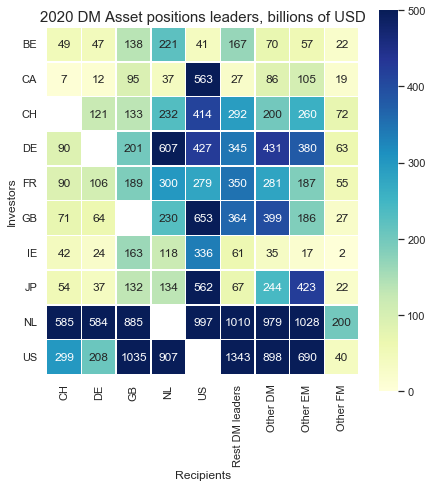

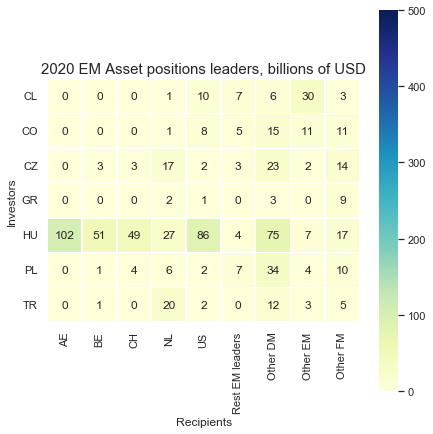

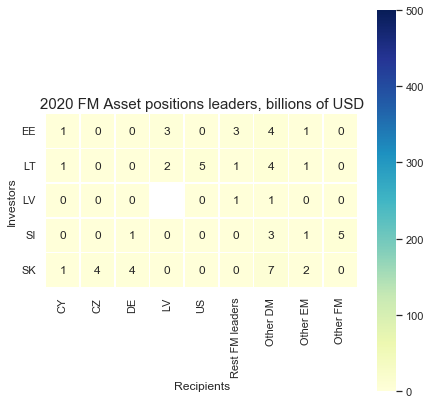

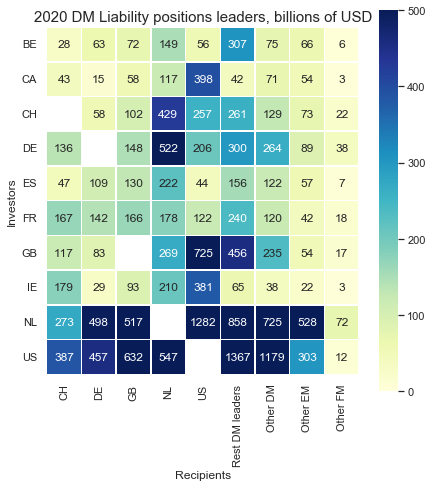

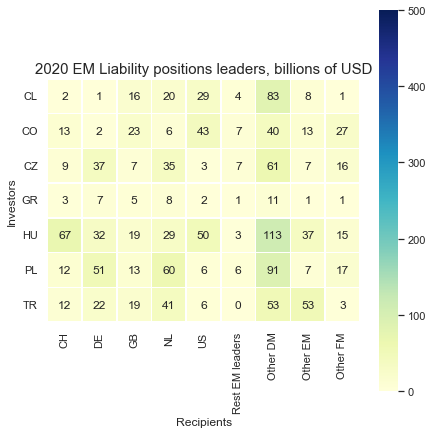

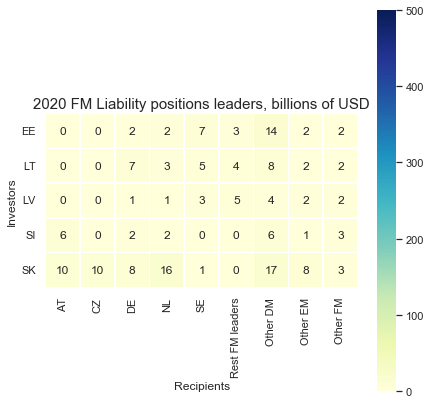

In [53]:
### OECD FDI: STATS: ASSET INVESTMENT VOLUME 2020

int_top_reporters = 10
int_top_partners = 5

df_ison_value = df_ison_flows.set_index(['Reporter_Market', 'Partner_Market'], append = True)
df_ison_last = df_ison_value.loc['2020'].groupby(['Reporter_ID', 'Partner_ID', 'Reporter_Market', 'Partner_Market']).sum() / 1000

for iter_flow in df_ison_last.columns:
    for iter_market in ['DM', 'EM', 'FM']:
        df_iter_last = df_ison_last.loc[(All, All, iter_market, All), iter_flow].droplevel('Reporter_Market')
        list_reporter_leaders = df_iter_last.groupby('Reporter_ID').sum().nlargest(int_top_reporters).index.to_list()
        df_iter_lead = df_iter_last.loc[list_reporter_leaders]
        list_partner_leaders = df_iter_lead.groupby('Partner_ID').sum().nlargest(int_top_partners).index.to_list()
        df_top_part = df_iter_lead.loc[All, list_partner_leaders].groupby(['Reporter_ID', 'Partner_ID']).sum().unstack('Partner_ID')
        list_lost_leaders = set(list_reporter_leaders) - set(list_partner_leaders)
        df_lost_part = df_iter_lead.loc[All, list_lost_leaders].groupby('Reporter_ID').sum().to_frame()
        df_lost_part.columns = ['Rest ' + iter_market + ' leaders']        
        list_other_partners = list(set(df_iter_lead.index.get_level_values('Partner_ID')) - set(list_partner_leaders) - set(list_lost_leaders))
        df_other_part = df_iter_lead.loc[All, list_other_partners].groupby(['Reporter_ID', 'Partner_Market']).sum().unstack('Partner_Market')
        df_other_part.columns = ['Other ' + iter_col for iter_col in df_other_part.columns]
        df_iter_heat = pd.concat([df_top_part, df_lost_part, df_other_part], axis = 1, sort = False)

        plt.figure(figsize = (7, 7))
        ax_heatmap = sns.heatmap(df_iter_heat, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = True, annot = True, 
                                 fmt = '.0f', center = 250, vmin = 0, vmax = 500)
        ax_heatmap.set(xlabel = 'Recipients', ylabel = 'Investors')
        ax_heatmap.set_title('2020 ' + iter_market + ' ' + iter_flow + ' positions leaders, billions of USD', fontsize = 15)
        plt.yticks(rotation = 0)
        plt.show()
#        break
#    break

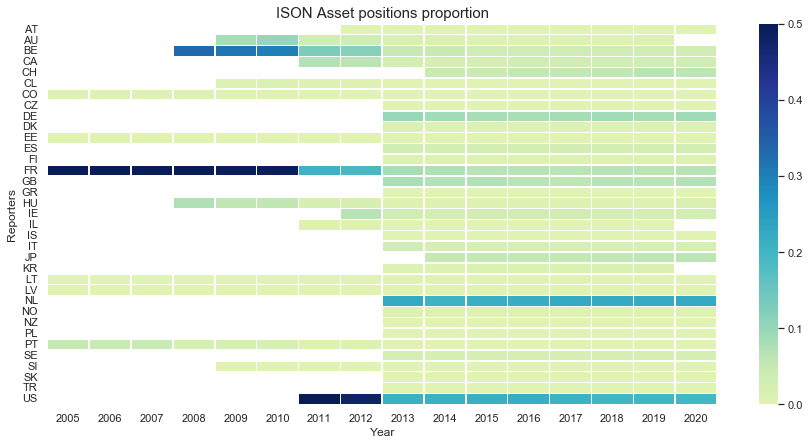

In [54]:
### OECD FDI: STATS: OUTWARD INVESTMENT PROPROTIONS HISTORY

df_market_history = ser_market_flows / 1000
df_market_history = df_market_history.reset_index('Date')
df_market_history['Year'] = df_market_history['Date'].dt.year

df_market_history = df_market_history.set_index('Year', append = True).drop('Date', axis = 1)

ser_market_sum = df_market_history.groupby('Year').sum().squeeze()
ser_market_sum.name = 'Sum'
df_market_history = df_market_history.join(ser_market_sum)
df_market_history['Proportion'] = df_market_history['Asset'] / df_market_history['Sum']

#for iter_market in ['DM', 'EM', 'FM']:
#    df_iter_history = df_market_history.loc[(All, iter_market, All), ['Proportion']].droplevel('Market').unstack('Year').droplevel(0, axis = 1).sort_index()   
#    plt.figure(figsize = (15, 7))
#    ax_heatmap = sns.heatmap(df_iter_history, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = False, 
#                            fmt = '.0f', center = 0.15, vmin = 0.0, vmax = 0.50)
#    ax_heatmap.set(xlabel = 'Year', ylabel = 'Reporters')
#    ax_heatmap.set_title(iter_market + ' Outward positions proportion', fontsize = 15)
#    plt.yticks(rotation = 0)
#    plt.show()  
    
df_iter_history = df_market_history['Proportion'].droplevel('Market').unstack('Year').sort_index()   
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_iter_history, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = False, 
                         fmt = '.0f', center = 0.20, vmin = 0.0, vmax = 0.50)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Reporters')
ax_heatmap.set_title('ISON Asset positions proportion', fontsize = 15)
plt.yticks(rotation = 0)
plt.show()      

In [8]:
### BIS: BILATERAL BANK LENDING

In [9]:
### BIS: GET LBS DATAFLOW

### Session start:
request_session = requests.Session()
str_bis_base_url = 'https://stats.bis.org/api/v1/'
str_bis_dataflow_add = 'dataflow/BIS/all/latest?references=none&detail=allstubs'
### SDMX structure of dataflows list loading:
obj_bis_dataflow_list = request_session.get(str_bis_base_url + str_bis_dataflow_add)
xml_tree_root = et.fromstring(obj_bis_dataflow_list.content)
### Searching for LBS dataflow:
for xml_tree_child_level_0 in xml_tree_root:
    if xml_tree_child_level_0.tag.endswith('Structures'):
        for xml_tree_child_level_1 in xml_tree_child_level_0:
            if xml_tree_child_level_1.tag.endswith('Dataflows'):
                for xml_tree_child_level_2 in xml_tree_child_level_1:
                    str_dataflow_description = xml_tree_child_level_2[0].text
                    if ((str_dataflow_description.find('BIS') > -1) & (str_dataflow_description.find('location') > -1) & (str_dataflow_description.find('bank') > -1)):
                        str_dataflow_id = xml_tree_child_level_2.attrib['id']
                        print(str_dataflow_description, ':', str_dataflow_id)  

BIS locational banking : WS_LBS_D_PUB


In [10]:
### BIS: GET LBS DATA STRUCTURE

str_bis_data_structure_add = 'structure/BIS/' + str_dataflow_id + '/latest?references=none&detail=full'
### SDMX structure of dataflow loading:
obj_bis_data_stucture = request_session.get(str_bis_base_url + str_bis_data_structure_add)
xml_tree_root = et.fromstring(obj_bis_data_stucture.content)
### Searching for LBS datastructure:
for xml_tree_child_level_0 in xml_tree_root:
    if xml_tree_child_level_0.tag.endswith('Structures'):
        for xml_tree_child_level_1 in xml_tree_child_level_0:
            if xml_tree_child_level_1.tag.endswith('Dataflows'):
                for xml_tree_child_level_2 in xml_tree_child_level_1:
                    if xml_tree_child_level_2.tag.endswith('Dataflow'):
                        for xml_tree_child_level_3 in xml_tree_child_level_2:
                            if xml_tree_child_level_3.tag.endswith('Structure'):
                                for xml_tree_child_level_4 in xml_tree_child_level_3:
                                    str_data_structure_id = xml_tree_child_level_4.attrib['id']
                                    print('Datastructure:', str_data_structure_id)

Datastructure: BIS_LBS_DISS


In [11]:
### BIS: GET LBS REQUEST STRUCTURE

str_bis_request_structure_add = 'datastructure/BIS/' + str_data_structure_id + '/latest?references=none&detail=full'
### SDMX request structure list loading:
obj_bis_request_stucture = request_session.get(str_bis_base_url + str_bis_request_structure_add)
xml_tree_root = et.fromstring(obj_bis_request_stucture.content)
### Dummy containers creating:
dict_concepts = {}
dict_codelists = {}
### LBS request positions collecting:
for xml_tree_child_level_0 in xml_tree_root:
    if xml_tree_child_level_0.tag.endswith('Structures'):
        for xml_tree_child_level_1 in xml_tree_child_level_0:
            if xml_tree_child_level_1.tag.endswith('DataStructures'):            
                for xml_tree_child_level_2 in xml_tree_child_level_1:
                    if xml_tree_child_level_2.tag.endswith('DataStructure'):  
                        for xml_tree_child_level_3 in xml_tree_child_level_2:
                            if xml_tree_child_level_3.tag.endswith('DataStructureComponents'): 
                                for xml_tree_child_level_4 in xml_tree_child_level_3:
                                    if xml_tree_child_level_4.tag.endswith('DimensionList'):           
                                        for xml_tree_child_level_5 in xml_tree_child_level_4:
                                            if xml_tree_child_level_5.tag.endswith('Dimension'):
                                                int_position = int(xml_tree_child_level_5.attrib['position'])
                                                for xml_tree_child_level_6 in xml_tree_child_level_5:
                                                    if xml_tree_child_level_6.tag.endswith('ConceptIdentity'):
                                                        for xml_tree_child_level_7 in xml_tree_child_level_6:
                                                            if xml_tree_child_level_7.tag.endswith('Ref'):
                                                                dict_concepts[int_position] = xml_tree_child_level_7.attrib['id']
                                                    elif xml_tree_child_level_6.tag.endswith('LocalRepresentation'):
                                                        for xml_tree_child_level_7 in xml_tree_child_level_6:
                                                            if xml_tree_child_level_7.tag.endswith('Enumeration'):
                                                                for xml_tree_child_level_8 in xml_tree_child_level_7:
                                                                    if xml_tree_child_level_8.tag.endswith('Ref'):
                                                                        dict_codelists[int_position] = xml_tree_child_level_8.attrib['id']
### LBS request structure consolidating:                                                                        
df_lbs_concept = pd.concat([pd.Series(dict_concepts), pd.Series(dict_codelists)], axis = 1, keys = ['Concept', 'Codelist'])
print('Request structure:\n', df_lbs_concept)

Request structure:
             Concept            Codelist
1              FREQ             CL_FREQ
2         L_MEASURE       CL_STOCK_FLOW
3        L_POSITION       CL_L_POSITION
4           L_INSTR          CL_L_INSTR
5           L_DENOM    CL_CURRENCY_3POS
6       L_CURR_TYPE      CL_L_CURR_TYPE
7      L_PARENT_CTY  CL_BIS_IF_REF_AREA
8   L_REP_BANK_TYPE      CL_L_BANK_TYPE
9         L_REP_CTY  CL_BIS_IF_REF_AREA
10      L_CP_SECTOR         CL_L_SECTOR
11     L_CP_COUNTRY  CL_BIS_IF_REF_AREA
12       L_POS_TYPE       CL_L_POS_TYPE
13      TIME_PERIOD                 NaN


In [12]:
### BIS: GET LBS CONCEPTS OPTIONS

### Dummy container creating:
df_lbs_concept['Options'] = np.NaN
### Searching for LBS concepts options:
for iter_pos, iter_row in df_lbs_concept.iterrows():
    if isinstance(iter_row['Codelist'], str):
        dict_options = {}
        str_lbs_codelist_add = 'codelist/BIS/' + iter_row['Codelist'] + '/latest?references=none&detail=full'
        ### SDMX codelist options list loading:
        obj_bis_codelist_options = request_session.get(str_bis_base_url + str_lbs_codelist_add)
        xml_tree_root = et.fromstring(obj_bis_codelist_options.content)
        ### LBS reqCodelists options collecting:
        for xml_tree_child_level_0 in xml_tree_root:
            if xml_tree_child_level_0.tag.endswith('Structures'):
                for xml_tree_child_level_1 in xml_tree_child_level_0:
                    if xml_tree_child_level_1.tag.endswith('Codelists'):
                        for xml_tree_child_level_2 in xml_tree_child_level_1:
                            if xml_tree_child_level_2.tag.endswith('Codelist'):
                                for xml_tree_child_level_3 in xml_tree_child_level_2:
                                    if xml_tree_child_level_3.tag.endswith('Code'):
                                        str_option_id = xml_tree_child_level_3.attrib['id']
                                        for xml_tree_child_level_4 in xml_tree_child_level_3:
                                            if xml_tree_child_level_4.tag.endswith('Name'):
                                                dict_options[str_option_id] = xml_tree_child_level_4.text
        iter_row['Options'] = dict_options
        df_lbs_concept.loc[iter_pos] = iter_row
        
print('Request structure & options:\n', df_lbs_concept)

Request structure & options:
             Concept            Codelist  \
1              FREQ             CL_FREQ   
2         L_MEASURE       CL_STOCK_FLOW   
3        L_POSITION       CL_L_POSITION   
4           L_INSTR          CL_L_INSTR   
5           L_DENOM    CL_CURRENCY_3POS   
6       L_CURR_TYPE      CL_L_CURR_TYPE   
7      L_PARENT_CTY  CL_BIS_IF_REF_AREA   
8   L_REP_BANK_TYPE      CL_L_BANK_TYPE   
9         L_REP_CTY  CL_BIS_IF_REF_AREA   
10      L_CP_SECTOR         CL_L_SECTOR   
11     L_CP_COUNTRY  CL_BIS_IF_REF_AREA   
12       L_POS_TYPE       CL_L_POS_TYPE   
13      TIME_PERIOD                 NaN   

                                              Options  
1   {'A': 'Annual', 'B': 'Daily - business week (n...  
2   {'F': 'FX and break adjusted change (BIS calcu...  
3   {'B': 'Local claims', 'C': 'Total claims', 'D'...  
4   {'A': 'All instruments', 'D': 'Debt securities...  
5   {'ADP': 'Andorran Peseta', 'AED': 'UAE dirham'...  
6   {'A': 'All currencies (=D+F

In [39]:
### BIS: SELECTING LBS CONCEPTS OPTIONS

int_pos = 9
# 1 to 12
print(df_lbs_concept.loc[int_pos, 'Concept'], '/', df_lbs_concept.loc[int_pos, 'Codelist'], ':\n', end = '')
print(pd.Series(df_lbs_concept.loc[int_pos, 'Options']))
#  1 - FREQUENCY - 'Q': 'Quaterly'
#  2 - MEASURE - 'S': Amounts outstanding / Stocks'
#  3 - BALANCE SHEET POSITION - 'C': 'Total claims' / 'L': 'Total liabilities'
#  4 - TYPE OF INSTRUMENTS - 'A': 'All instruments'
#  5 - CURRENCY DENOMINATION - 'TO1': 'All currencies'
#  6 - CURRENCY TYPE - 'A': 'All currencies'
#  7 - PARENT COUNTRY - '5J': 'All countries'
#  8 - TYPE OF REPORTING INSTITUTION - 'A': 'All reporting banks/institutions (domestic, foreign, consortium and unclassified)'
#  9 - REPORTING COUNTRY - we need to construct request for all ISON countries as reporters
# 10 - COUNTERPARTY SECTOR - 'A': 'All sectors'
# 11 - COUNTERPARTY COUNTRY - we need to construct request for all ISON countries as partners
# 12 - POSITION TYPE - 'N': 'Cross-border'
# 13 - TIME PERIOD

L_REP_CTY / CL_BIS_IF_REF_AREA :
00                                               Others
11    Technical residual (Non-residents / Cross-border)
1A                         US banks in offshore centres
1B                     International banking facilities
1C                          International organisations
                            ...                        
ZA                                         South Africa
ZM                                               Zambia
ZR                                                Zaire
ZW                                             Zimbabwe
_Z                                       Not applicable
Length: 426, dtype: object


In [37]:
### TEMP

pd.Series(df_lbs_concept.loc[int_pos, 'Options']).loc['5J']

'All countries (total)'

In [44]:
### BIS: ANNUAL REQUESTS

### Container initializing:
list_lbs_data = []
### Looping over needed date range year-by year:
for iter_year in range(date_start.year, date_end.year + 1): # [1989, 1990]: # 
    str_bis_data_year_add = 'data/' + str_dataflow_id + '/Q.S..A.TO1.A.5J.A..A..N/all?startPeriod=' \
                            + str(iter_year) + '-Q1&endPeriod=' + str(iter_year) + '-Q4&detail=dataonly'    
    ### SDMX structure of dataflow loading:
    obj_bis_data_annual = request_session.get(str_bis_base_url + str_bis_data_year_add)
    xml_tree_root = et.fromstring(obj_bis_data_annual.content)
    ### LBS data collecting:
    for xml_tree_child_level_0 in xml_tree_root:
        if xml_tree_child_level_0.tag.endswith('DataSet'):
            for xml_tree_child_level_1 in xml_tree_child_level_0:
                if xml_tree_child_level_1.tag.endswith('Series'):
                    ### Series attributes getting:
                    str_position = xml_tree_child_level_1.attrib['L_POSITION']
                    str_rep_country = xml_tree_child_level_1.attrib['L_REP_CTY']
                    str_cp_country = xml_tree_child_level_1.attrib['L_CP_COUNTRY']
                    ### Series values getting:
                    dict_values = {}
                    for xml_tree_child_level_2 in xml_tree_child_level_1:
                        if xml_tree_child_level_2.tag.endswith('Obs'):
                            dict_values[xml_tree_child_level_2.attrib['TIME_PERIOD']] = xml_tree_child_level_2.attrib['OBS_VALUE']
                    ### Transforming data to series:
                    list_lbs_data.append(pd.concat([pd.Series(dict_values)], keys = [(str_position, str_rep_country, str_cp_country)], 
                                                    names = ['Position', 'Reporter_ID', 'Partner_ID']))
    print(str(iter_year), ': data loaded')

2017 : data loaded
2018 : data loaded
2019 : data loaded
2020 : data loaded
2021 : data loaded


In [60]:
### BIS: DATA MANIPULATING

gc.collect()
### Converting container to series:
ser_lbs_quarter = pd.concat(list_lbs_data)
### Period index preparing:
ser_lbs_quarter.index.names = ser_lbs_quarter.index.names[: -1] + ['Quarter']
ser_lbs_quarter.index = ser_lbs_quarter.index.set_levels(pd.to_datetime(ser_lbs_quarter.index.levels[-1]) + pd.offsets.BQuarterEnd(), level = 'Quarter')
### ISON filtering:
set_ison_countries = set(ser_ison_membership.index.get_level_values(1))
ser_lbs_quarter = ser_lbs_quarter.loc[All, list(set_ison_countries), list(set_ison_countries), All]
#### Data type casting:
ser_lbs_quarter = ser_lbs_quarter.astype(float).sort_index()
### Zero years to NaN (there are no full zero years in original quaterly data) after resampling:
ser_lbs_quarter = ser_lbs_quarter.replace({0.0: np.NaN})
### Index ordering:
ser_lbs_quarter.index.names = ser_lbs_quarter.index.names[: -1] + ['Date']
ser_lbs_quarter = ser_lbs_quarter.reorder_levels([0, 3, 1, 2])
ser_lbs_quarter.name = 'Value'
#### Resampling to annual frequency:
#ser_lbs_year = ser_lbs_quarter.groupby(['Position', 'Reporter_ID', 'Partner_ID'])\
#                              .apply(lambda iter_group: iter_group.droplevel(['Position', 'Reporter_ID', 'Partner_ID']).resample('BY').sum())
#### Zero years to NaN (there are no full zero years in original quaterly data) after resampling:
#ser_lbs_year = ser_lbs_year.replace({0.0: np.NaN})
#### Index ordering:
#ser_lbs_year.index.names = ser_lbs_year.index.names[: -1] + ['Date']
#ser_lbs_year = ser_lbs_year.reorder_levels([0, 3, 1, 2])
#ser_lbs_year.name = 'Value'

In [62]:
### BIS: DATA SAVING

#ser_lbs_year.loc['C'].to_hdf(path_or_buf = str_path_bis_dataset, key = str_bis_claim_dataset, mode = 'w')
#ser_lbs_year.loc['L'].to_hdf(path_or_buf = str_path_bis_dataset, key = str_bis_liability_dataset, mode = 'r+')
ser_lbs_quarter.loc['C'].to_hdf(path_or_buf = str_path_bis_dataset, key = str_bis_claim_dataset, mode = 'w')
ser_lbs_quarter.loc['L'].to_hdf(path_or_buf = str_path_bis_dataset, key = str_bis_liability_dataset, mode = 'r+')

In [88]:
### BIS POSITIONS: TEST

ser_test = pd.read_hdf(path_or_buf = str_path_bis_dataset, key = str_bis_claim_dataset)
ser_test.loc[All, ['IL', 'US'], ['IL', 'US']].sort_index()
ser_test = pd.read_hdf(path_or_buf = str_path_bis_dataset, key = str_bis_liability_dataset)
ser_test.loc[All, ['IL', 'US'], ['IL', 'US']].sort_index()

Date        Reporter_ID  Partner_ID
1989-03-31  US           IL              892.0
1989-06-30  US           IL              816.0
1989-09-29  US           IL              928.0
1989-12-29  US           IL              984.0
1990-03-30  US           IL              912.0
                                        ...   
2020-12-31  US           IL            15148.0
2021-03-31  US           IL            16103.0
2021-06-30  US           IL            16943.0
2021-09-30  US           IL            17498.0
2021-12-31  US           IL            18665.0
Name: Value, Length: 132, dtype: float64

In [8]:
### BIS POSITIONS: EXAMPLES

ser_lbs_claim = pd.read_hdf(path_or_buf = str_path_bis_dataset, key = str_bis_claim_dataset)
ser_lbs_liability = pd.read_hdf(path_or_buf = str_path_bis_dataset, key = str_bis_liability_dataset)
ser_lbs_full = pd.concat([ser_lbs_claim, ser_lbs_liability], keys = ['Claim', 'Liability'], names = ['Position'])
list_to_plot = ['GB', 'US']
str_date_to_compare = '2020-12-31'
print(ser_lbs_full.loc[All, ['1989-12-29', '2020-12-31'], list_to_plot, list_to_plot].unstack(['Position']))

Position                               Claim  Liability
Date       Reporter_ID Partner_ID                      
1989-12-29 GB          US           129684.0   153403.0
           US          GB            70913.0   103940.0
2020-12-31 GB          US          1440098.0  1341772.0
           US          GB           911363.0   846275.0


<Figure size 1080x360 with 0 Axes>

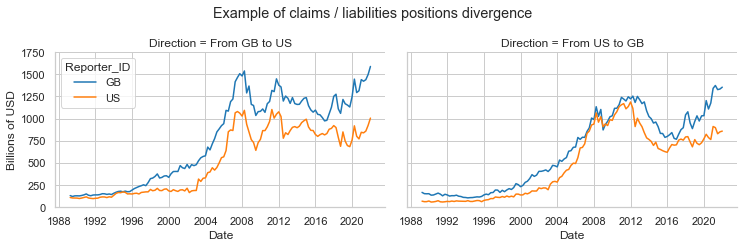

In [9]:
### BIS LBS POSITIONS: EXAMPLES

df_to_plot = ser_lbs_full.loc[All, All, list_to_plot, list_to_plot].reset_index()
#df_to_plot['Quarter'] = df_to_plot['Date'].dt.year
df_to_plot['Direction'] = ((df_to_plot['Position'] == 'Claim') & (df_to_plot['Reporter_ID'] == 'GB')) | \
                          ((df_to_plot['Position'] == 'Liability') & (df_to_plot['Reporter_ID'] == 'US'))
df_to_plot.loc[~df_to_plot['Direction'], 'Direction'] = 'From US to GB'
df_to_plot.loc[df_to_plot['Direction'] == True, 'Direction'] = 'From GB to US'
df_to_plot['Value'] = df_to_plot['Value'] / 1000
sns.set_style('whitegrid')
plt.figure(figsize = (15, 5))
sns.set_context('notebook')
fig_example = sns.relplot(data = df_to_plot, x = 'Date', y = 'Value', col = 'Direction', hue = 'Reporter_ID', kind = 'line', height = 3.5, aspect = 1.5,
                          facet_kws = dict(legend_out = False))
fig_example.set(ylim = (0, 1750), ylabel = 'Billions of USD')
fig_example.fig.subplots_adjust(top = 0.8)
fig_example.fig.suptitle('Example of claims / liabilities positions divergence')
plt.show()

In [10]:
### BIS LBS POSITIONS: STATS: FLOWS COMPLETENESS

gc.collect()
df_flows = ser_lbs_full.unstack('Position')
df_flows.columns = ['Claim', 'Liability']
ser_ison_mapper = ser_ison_membership.copy()
ser_ison_mapper.index.set_names('Reporter_ID', level = -1, inplace = True)
df_ison_flows = df_flows.join(ser_ison_mapper)
df_ison_flows.rename({'Market': 'Reporter_Market'}, axis = 1, inplace = True)
ser_ison_mapper.index.set_names('Partner_ID', level = -1, inplace = True)
df_ison_flows = df_ison_flows.join(ser_ison_mapper)
df_ison_flows.rename({'Market': 'Partner_Market'}, axis = 1, inplace = True)
df_ison_flows.dropna(subset = ['Reporter_Market', 'Partner_Market'], inplace = True)
df_ison_stats = df_ison_flows.reset_index(['Partner_ID', 'Reporter_ID'], drop = True).set_index(['Reporter_Market', 'Partner_Market'], append = True)
print('ISON reporters quantity:', len(set(df_flows.index.get_level_values('Reporter_ID'))))
print('Absent ISON members as reporters:', set(ser_ison_membership.index.get_level_values('Country')) - set(df_flows.index.get_level_values('Reporter_ID')))
print('ISON partners quantity:', len(set(df_flows.index.get_level_values('Partner_ID'))))
print('Absent ISON members as partners:', set(ser_ison_membership.index.get_level_values('Country')) - set(df_flows.index.get_level_values('Partner_ID')))

ISON reporters quantity: 26
Absent ISON members as reporters: {'PL', 'LT', 'PA', 'TR', 'NZ', 'KW', 'ZM', 'EG', 'TH', 'RO', 'AR', 'SG', 'MT', 'MU', 'LB', 'PT', 'BW', 'LK', 'BD', 'SK', 'CN', 'JO', 'BG', 'UA', 'OM', 'SI', 'QA', 'AE', 'PK', 'RU', 'NO', 'KZ', 'KE', 'IN', 'CY', 'LV', 'CI', 'CO', 'IL', 'MY', 'CR', 'EE', 'HU', 'RS', 'NG', 'CZ', 'TN', 'BH', 'PE', 'HR', 'UG', 'MA', 'EC', 'IS', 'ID', 'VN', 'NA', 'SA', 'GH'}
ISON partners quantity: 85
Absent ISON members as partners: set()


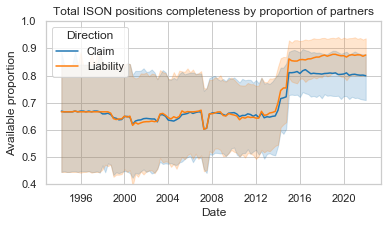

In [11]:
### BIS LBS POSITIONS: STATS: FLOWS COMPLETENESS

ser_ison_mem_count = ser_ison_membership.groupby('Date').value_counts().groupby('Date').sum()
ser_ison_mem_count.name = 'ISON'

#df_ison_partners = df_ison_flows
df_ison_partners = df_ison_flows.drop('Partner_Market', axis = 1).set_index('Reporter_Market', append = True).groupby(['Date', 'Reporter_ID', 'Reporter_Market']).count()

df_ison_partners = df_ison_partners.join(ser_ison_mem_count)
df_ison_partners = pd.concat([df_ison_partners['Claim'] / df_ison_partners['ISON'], df_ison_partners['Liability'] / df_ison_partners['ISON']], axis = 1)
df_ison_partners.columns = ['Claim', 'Liability']
ser_ison_partners = df_ison_partners.stack()
ser_ison_partners.name = 'Proportion'
ser_ison_partners.index.rename('Direction', level = -1, inplace = True)
sns.set_style('whitegrid')
plt.figure(figsize = (6, 3))
sns.set_context('notebook')
ax_completeness = sns.lineplot(data = ser_ison_partners.reset_index(), x = 'Date', y = 'Proportion', hue = 'Direction')
ax_completeness.set(ylabel = 'Available proportion', title = 'Total ISON positions completeness by proportion of partners', ylim = (0.4, 1.0))
plt.show()

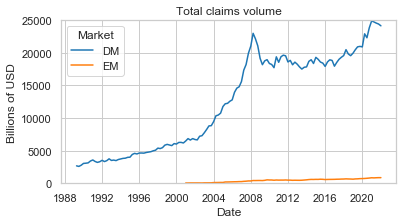

In [12]:
### BIS LBS POSITIONS: STATS: TOTAL POSITIONS VOLUME

ser_ison_status = ser_ison_membership.loc[date_end]
ser_ison_status.index.names = ['Reporter_ID']

ser_market_flows = df_flows['Claim'].groupby(['Date','Reporter_ID']).sum().to_frame().join(ser_ison_status).loc[: date_end].set_index('Market', append = True)
df_market_flows = ser_market_flows.groupby(['Date', 'Market']).sum() / 1000
df_to_plot = df_market_flows.reset_index()
sns.set_style('whitegrid')
plt.figure(figsize = (6, 3))
sns.set_context('notebook')
ax_sum_flows = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Claim', hue = 'Market')
ax_sum_flows.set(ylim = (0, 25000), ylabel = 'Billions of USD', title = 'Total claims volume')
plt.show()

In [15]:
### BIS LBS: STATS: FLOWS COMPARING

gc.collect()
df_straight_flows = df_flows.loc[: date_end]
df_straight_flows.columns = ['Straight_Claim', 'Straight_Liability']
df_reversed_flows = df_flows.loc[: date_end]
df_reversed_flows.index.names = ['Date', 'Partner_ID', 'Reporter_ID']
df_reversed_flows.columns = ['Reversed_Liability', 'Reversed_Claim']
df_reversed_flows = df_reversed_flows[['Reversed_Claim', 'Reversed_Liability']].reorder_levels([0, 2, 1])
print('Straight data first row:\n', df_straight_flows.iloc[-1 : ])
print('Reversed data first row:\n', df_reversed_flows.iloc[-1 : ])
df_straight_flows.sort_index(inplace = True)
df_reversed_flows.sort_index(inplace = True)
df_compare_flows = pd.concat([df_straight_flows, df_reversed_flows], axis = 1)

Straight data first row:
                                    Straight_Claim  Straight_Liability
Date       Reporter_ID Partner_ID                                    
2021-12-31 ZA          ZM                   215.0               267.0
Reversed data first row:
                                    Reversed_Claim  Reversed_Liability
Date       Reporter_ID Partner_ID                                    
2021-12-31 ZM          ZA                   267.0               215.0


In [ ]:
### BIS LBS: STATS: POSITIONS COMPARING

int_min_rank_to_check = 5
int_max_coeff = 2

gc.collect()

dict_to_compare = {}
dict_to_compare['Claim'] = df_compare_flows[['Straight_Claim', 'Reversed_Claim']]
dict_to_compare['Liability'] = df_compare_flows[['Straight_Liability', 'Reversed_Liability']]
dict_united = {}

for iter_flow in dict_to_compare:
    df_iter_flow = dict_to_compare[iter_flow]
    print('Proportion of', iter_flow, 'values available:\n', round(df_iter_flow.count() / len(df_iter_flow.index), 2))
    set_straight = set(df_iter_flow['Straight_' + iter_flow].dropna().index)
    set_reversed = set(df_iter_flow['Reversed_' + iter_flow].dropna().index)
    print('Proportion of', iter_flow, 'unique straight observations:\n', round(len(set_straight - set_reversed) / len(df_iter_flow.index), 2))
    print('Proportion of', iter_flow, 'unique reversed observations:\n', round(len(set_reversed - set_straight) / len(df_iter_flow.index), 2))    
    print('Proportion of', iter_flow, 'union of straight and reversed observations:\n', round(len(set_reversed | set_straight) / len(df_iter_flow.index), 2))   

    int_anomaly_counter = 0
    for (iter_num, iter_missed) in enumerate(sorted(list(set_reversed - set_straight))):
        if divmod(iter_num, 1000)[-1] == 0:
            print(iter_num, '/', iter_missed)
        ser_iter_date = df_iter_flow['Straight_' + iter_flow].loc[iter_missed[0], iter_missed[1], All]
        flo_iter_missed = df_iter_flow['Reversed_' + iter_flow][iter_missed]
        ser_iter_date.loc[iter_missed] = flo_iter_missed
        if ((ser_iter_date.rank(ascending = False)[iter_missed] < int_min_rank_to_check + 1) & (flo_iter_missed > 1.0)):
            flo_iter_max = df_iter_flow['Straight_' + iter_flow].loc[All, iter_missed[1], iter_missed[2]].max()
            if (not np.isnan(flo_iter_max)):
                if (flo_iter_missed > int_max_coeff * flo_iter_max):
#                    print('Greater than historical max:\n', df_iter_flow['Reversed_' + iter_flow][[iter_missed]])
                    int_anomaly_counter += 1
                    ser_iter_date.loc[iter_missed] = np.NaN
    print(iter_flow, 'anomaly_proportion:', round(int_anomaly_counter / iter_num, 2))

    dict_united[iter_flow] = df_iter_flow['Straight_' + iter_flow].combine_first(df_iter_flow['Reversed_' + iter_flow])

In [19]:
### BIS LBS: FLOWS COMBINING
	
gc.collect()
pd.concat(dict_united, axis = 1).to_hdf(path_or_buf = str_path_bis_lbs_combined, key = str_full_bis_lbs_combined, mode = 'w')

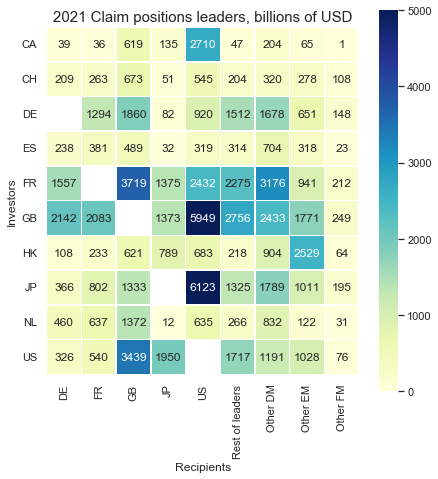

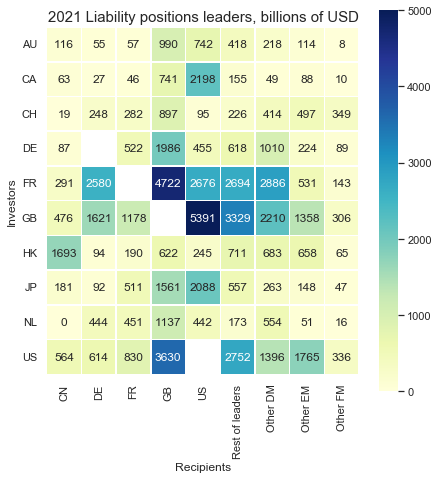

In [95]:
### BIS LBS POSITIONS: STATS: LENDING VOLUME 2021

int_top_reporters = 10
int_top_partners = 5

df_ison_value = df_ison_flows.set_index(['Reporter_Market', 'Partner_Market'], append = True)
df_ison_last = df_ison_value.loc['2021'].groupby(['Reporter_ID', 'Partner_ID', 'Reporter_Market', 'Partner_Market']).sum() / 1000

for iter_flow in df_ison_last.columns:
    df_iter_last = df_ison_last.loc[All, iter_flow].droplevel('Reporter_Market')
    list_reporter_leaders = df_iter_last.groupby('Reporter_ID').sum().nlargest(int_top_reporters).index.to_list()
    df_iter_lead = df_iter_last.loc[list_reporter_leaders]
    list_partner_leaders = df_iter_lead.groupby('Partner_ID').sum().nlargest(int_top_partners).index.to_list()
    df_top_part = df_iter_lead.loc[All, list_partner_leaders].groupby(['Reporter_ID', 'Partner_ID']).sum().unstack('Partner_ID')
    list_lost_leaders = set(list_reporter_leaders) - set(list_partner_leaders)
    df_lost_part = df_iter_lead.loc[All, list_lost_leaders].groupby('Reporter_ID').sum().to_frame()
    df_lost_part.columns = ['Rest of leaders']        
    list_other_partners = list(set(df_iter_lead.index.get_level_values('Partner_ID')) - set(list_partner_leaders) - set(list_lost_leaders))
    df_other_part = df_iter_lead.loc[All, list_other_partners].groupby(['Reporter_ID', 'Partner_Market']).sum().unstack('Partner_Market')
    df_other_part.columns = ['Other ' + iter_col for iter_col in df_other_part.columns]    
    df_iter_heat = pd.concat([df_top_part, df_lost_part, df_other_part], axis = 1, sort = False)
    
    plt.figure(figsize = (7, 7))
    ax_heatmap = sns.heatmap(df_iter_heat, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = True, annot = True, 
                             fmt = '.0f', center = 2500, vmin = 0, vmax = 5000)
    ax_heatmap.set(xlabel = 'Recipients', ylabel = 'Investors')
    ax_heatmap.set_title('2021 ' + iter_flow + ' positions leaders, billions of USD', fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()

#    break

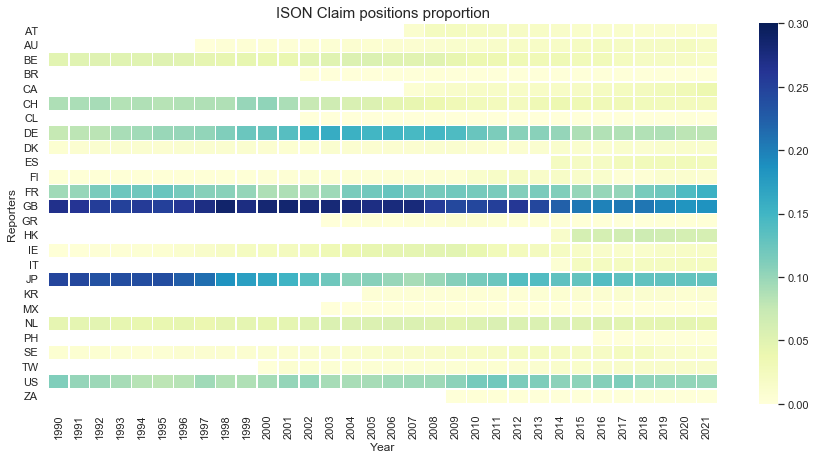

In [117]:
### BIS LBS POSITIONS: STATS: OUTWARD INVESTMENT PROPROTIONS HISTORY

df_market_history = ser_market_flows.unstack(['Reporter_ID', 'Market']).resample('BY').sum()[1 : -1].replace({0.0: np.NaN}).stack(['Reporter_ID', 'Market']) / 1000
df_market_history = df_market_history.reset_index('Date')
df_market_history['Year'] = df_market_history['Date'].dt.year

df_market_history = df_market_history.set_index('Year', append = True).drop('Date', axis = 1)

ser_market_sum = df_market_history.groupby('Year').sum().squeeze()
ser_market_sum.name = 'Sum'
df_market_history = df_market_history.join(ser_market_sum)
df_market_history['Proportion'] = df_market_history['Claim'] / df_market_history['Sum']
   
df_iter_history = df_market_history['Proportion'].droplevel('Market').unstack('Year').sort_index()   
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_iter_history, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = False, 
                         fmt = '.0f', center = 0.15, vmin = 0.0, vmax = 0.30)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Reporters')
ax_heatmap.set_title('ISON Claim positions proportion', fontsize = 15)
plt.yticks(rotation = 0)
plt.show()      

In [12]:
### RETURNS LOADING AND CONTROL

### Bloomberg data loading:
ser_returns = pd.read_hdf(str_path_bb_hdf, key = str_key_ret_monthly)
ser_mmr = pd.read_hdf(str_path_bb_hdf, key = str_key_mmr)

### List of countries with de-facto equal returns (to impact on hedged returns calculating)
ser_ret_similarity_test = ser_returns.unstack('Currency').groupby('Country').apply(lambda df_country: (df_country['LOC'] - df_country['USD']).abs().mean())
set_ret_usd_only = set(ser_ret_similarity_test.loc[ser_ret_similarity_test < flo_returns_similarity].index)
### List of countries with unsufficient data quantity:
ser_ret_completeness_test = ser_returns.groupby('Country').apply(lambda ser_country: ser_country.count() / len(ser_country.index))
set_not_complete = set(ser_ret_completeness_test.loc[ser_ret_completeness_test < flo_returns_completeness].index)
### Filtering uncomplete countries:
ser_returns.loc[All, All, set_not_complete] = np.NaN
### Returns options preparing:
dict_ser_ret = {}
### Returns in local currency:
dict_ser_ret['LOC'] = ser_returns.loc['LOC', All, All].droplevel(0)
### Returns in USD:
dict_ser_ret['USD'] = ser_returns.loc['USD', All, All].droplevel(0)
### Hedged returns in local currency:
dict_ser_hedged = {}
### Filling data for countries with no MMR data:
set_ison_countries = set(dict_ser_ret['LOC'].index.get_level_values(1).unique())
set_mmr_countries = set(ser_mmr.index.get_level_values(1).unique())
set_no_mmr_countries = (set_ison_countries - set_mmr_countries) | set_ret_usd_only
set_to_hedge_countries = set_mmr_countries - set_no_mmr_countries
dict_ser_hedged['No_MMR'] = dict_ser_ret['USD'].loc[All, set_no_mmr_countries]
### Money Market rates shifting forward:
ser_mmr_shifted = ser_mmr.groupby('Country').shift(1)
### Filling data for other countries:
df_ser_hedged = pd.DataFrame()
df_ser_hedged['Returns LOC'] = dict_ser_ret['LOC'].loc[All, set_to_hedge_countries]
df_ser_hedged = df_ser_hedged.join(ser_mmr_shifted, how = 'left')
df_ser_hedged.columns = ['Returns LOC', 'MMR LOC']
dict_ser_hedged['MMR_Based'] = df_ser_hedged.groupby('Country', group_keys = False)\
                               .apply(lambda df_country: (1 + df_country['Returns LOC']) * (1 + ser_mmr_shifted.loc[All, 'US'] / 12) / (1 + df_country['MMR LOC'] / 12) - 1)
#dict_ser_hedged['MMR_Based'] = df_ser_hedged.groupby('Country', group_keys = False)\
#                               .apply(lambda df_country: (1 + df_country['Returns LOC']) * (((1 + ser_mmr.loc[All, 'US']) / (1 + df_country['MMR LOC'])) ** (1 /12)) - 1)
### Aggregating hedged returns:
dict_ser_ret['HEDGED'] = pd.concat(dict_ser_hedged).droplevel(0).sort_index()